Project/homework
There are two tasks to choose from. Do one or the other (obligatory).

House Prices prediction. Practice data review, cleaning/preparing, feature engineering. Finally, build a model for a price prediction.
Predict the "cut" feature from the diamonds dataset.
This homework is obligatory. Please send colab link to kwant@agh.edu.pl before 13.03.2024.

## CHECK PY VERSION AND DISABLE WARRNING FROM SEABORN
# https://github.com/mwaskom/seaborn/issues/3462
# I'm using PyPy instead of CPython. For speed only

In [1]:
import platform
v = platform.python_version_tuple();
print(v)
if float(v[1]) < 10:
    raise Exception("MUST USE Python 3.10 to use MATCH expression!")

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

('3', '10', '12')


In [2]:
!pip install gdown numpy pandas seaborn matplotlib

In [3]:
# House Price

import gdown
gdown.download('https://drive.google.com/uc?id=1Z74AfhGE64qhyuO9Hgfj56xCJpZHocmA', 'house.zip', quiet=False)

!unzip -o house.zip

Downloading...
From: https://drive.google.com/uc?id=1Z74AfhGE64qhyuO9Hgfj56xCJpZHocmA
To: /home/mg/AI_ML_Course/ex_1/house.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204k/204k [00:00<00:00, 1.44MB/s]

Archive:  house.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
!cat data_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

dates_columns = ['YearBuilt','YearRemodAdd','GarageYrBlt']

test_data_csv = pd.read_csv("test.csv", parse_dates=dates_columns)
all_id_unique = test_data_csv['Id'].is_unique;
if all_id_unique:
    print("ALL ID ARE UNIQUE!")
else:
    print("NON_Unique IDS!!")



ALL ID ARE UNIQUE!


# Read CSV with prices, append it to the current

In [6]:
sample_submission_csv = pd.read_csv("sample_submission.csv")
all_id_unique = sample_submission_csv['Id'].is_unique;
if all_id_unique:
    print("ALL ID ARE UNIQUE!")
else:
    print("NON_Unique IDS!!")

test_data_csv = pd.merge(test_data_csv, sample_submission_csv, on="Id")

#We can switch to Id as index!
test_data_csv = test_data_csv.set_index('Id')

ALL ID ARE UNIQUE!


# CONVERT DATES

In [7]:
#Convert Dates
#print(test_data_csv["YrSold"].isnull().any())
#print(test_data_csv["MoSold"].isnull().any())
year_month = ["YrSold",'MoSold']

test_data_csv["SoldDate"] = pd.to_datetime(test_data_csv[year_month[0]].astype(str) + test_data_csv[year_month[1]].astype(str),format='%Y%m' )
test_data_csv = test_data_csv.drop(columns=year_month);


# Clear out data from NA, convert

In [8]:
from enum import Enum, unique

@unique
class PDataType(Enum):
    NUMERICAL = 1
    CATHEGORICAL = 2

def remove_distinct_value_features(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def get_data_type(df, type):
    match type:
        case PDataType.NUMERICAL:
            return df.select_dtypes(np.number);
        case PDataType.CATHEGORICAL:
            return df.select_dtypes(include='object');

#select all cathegorigal data where the first value is more than percent%?
def get_cathegorical_data_by_percent(df, percent):
    col_names = get_data_type(df,PDataType.CATHEGORICAL)
    to_return = []
    for col_name in col_names:
        unique_v_df = (df[col_name].value_counts()).to_frame()
        unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
        if unique_v_df.iloc[0].percent > percent:
            to_return.append(col_name);
    return to_return
    
def fill_empty_data_with(df, type, filler):
    col_names = get_data_type(df,type)
    for c in col_names:
        test_data_csv[c] = test_data_csv[c].fillna(filler)

In [9]:
#test_data_csv['Fence'] = test_data_csv['Fence'].fillna('NoFence')
#test_data_csv['PoolQC'] = test_data_csv['PoolQC'].fillna('NoPoolQC')
#test_data_csv['MiscFeature'] = test_data_csv['MiscFeature'].fillna('NoMiscFeature')
#test_data_csv['Alley'] = test_data_csv['Alley'].fillna('NoAlley')


fill_empty_data_with(test_data_csv,PDataType.CATHEGORICAL,"None")
fill_empty_data_with(test_data_csv,PDataType.NUMERICAL,0)

to_drop_non_unique = remove_distinct_value_features(test_data_csv)
if not to_drop_non_unique:
    print(f"No non unique features")
else: 
    print(f"ToRemove {to_drop_non_unique}")
    test_data_csv.drop(to_drop_non_unique,axis=1,inplace=True)

only_numbers = get_data_type(test_data_csv,PDataType.NUMERICAL)

inf_in_numbers = only_numbers.columns.to_series()[np.isinf(only_numbers).any()]

if inf_in_numbers.empty:
    print("No Inf values")
else:
    print(f"Remove Inf values! in {inf_in_numbers}");

#test_data_csv.index[np.isinf(test_data_csv).any(1)]


No non unique features
No Inf values


## Calculate PricePerSqrFt

In [12]:

test_data_csv['PricePerSqrFt'] = test_data_csv['SalePrice']/test_data_csv['LotArea']


## I should remove those values which are lower than some percentage right?

In [13]:
for i in range(80,100,5):
    more_than = get_cathegorical_data_by_percent(test_data_csv,i);
    print(f"Cathegorical data in which most common value is more than {i}% occurence = \n{more_than} \n")


Cathegorical data in which most common value is more than 80% occurence = 
['Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'] 

Cathegorical data in which most common value is more than 85% occurence = 
['Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'BsmtCond', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'MiscFeature', 'SaleType'] 

Cathegorical data in which most common value is more than 90% occurence = 
['Street', 'Alley', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageCond', 'PoolQC', 'MiscFeature'] 

Cathegorical data in w

In [14]:
print(test_data_csv.describe())
print(test_data_csv.info())
print(test_data_csv.shape)

        MSSubClass  LotFrontage       LotArea  OverallQual  OverallCond  \
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000   
mean     57.378341    57.910212   9819.161069     6.078821     5.553804   
min      20.000000     0.000000   1470.000000     1.000000     1.000000   
25%      20.000000    44.000000   7391.000000     5.000000     5.000000   
50%      50.000000    63.000000   9399.000000     6.000000     5.000000   
75%      70.000000    78.000000  11517.500000     7.000000     6.000000   
max     190.000000   200.000000  56600.000000    10.000000     9.000000   
std      42.746880    32.266054   4955.517327     1.436812     1.113740   

                           YearBuilt                   YearRemodAdd  \
count                           1459                           1459   
mean   1971-05-11 19:25:37.217272104  1983-08-31 04:56:05.592871808   
min              1879-01-01 00:00:00            1950-01-01 00:00:00   
25%              1953-01-01 00:00:00    

In [15]:
print(test_data_csv[test_data_csv.isna().any(axis=1)])


      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1514          90       RL         98.0    13260   Pave  None      IR1   
1532          30       RM         56.0     4485   Pave  Grvl      Reg   
1540         190       RM        100.0     9045   Pave  None      Reg   
1553          70       RM         60.0    12900   Pave  Grvl      Reg   
1557         190       RL         60.0     9900   Pave  None      Reg   
...          ...      ...          ...      ...    ...   ...      ...   
2894          50  C (all)         60.0     8520   Grvl  None      Reg   
2910         180       RM         21.0     1470   Pave  None      Reg   
2914         160       RM         21.0     1526   Pave  None      Reg   
2915         160       RM         21.0     1936   Pave  None      Reg   
2918          85       RL         62.0    10441   Pave  None      Reg   

     LandContour Utilities LotConfig  ... PoolArea

# FUNCTIONS FOR PLOTS!

In [38]:
#define Seaborn color palette to use
import numpy as np
from math import ceil
from itertools import zip_longest

def plot_pie_for_unique_category(df,col_name_x, ax):
    colors = sns.color_palette('pastel')
    unique_v_df = (df[col_name_x].value_counts()).to_frame()
    unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
    unique_v_df.plot.pie(y='count', use_index=True,autopct='%0.2f%%', title = f"{col_name_x}", ax = ax)



def plot_hist_for_unique_category(df,col_name_x,col_name_y):
    unique_v_df = (df[col_name_x].value_counts()).to_frame()
    unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
    fig, axs = plt.subplots(nrows=len(unique_v_df), figsize=(16,10))
    i = 0;
    for index, row in unique_v_df.iterrows():
        value_percent = row.iloc[1];
        value = row.iloc[0];
        name = index;
        sns.histplot(data=df.loc[df[col_name_x] == name], x=col_name_y, ax = axs[i],bins=100, label =f'{col_name_x} {name} : {value} | {value_percent:.2f}%')
        axs[i].set_xlim(df[col_name_y].min(), df[col_name_y].max())
        axs[i].legend()
        i+=1
    fig.suptitle(f"{col_name_x} on {col_name_y}")

    
def plot_unique_category(df,col_name_x,col_name_y,plotType=""):
    plot_hist_for_unique_category(df,col_name_x,col_name_y)
    fig, axs = plt.subplots(1, 2, figsize=(10,10))
    fig.tight_layout()
    plot_pie_for_unique_category(df,col_name_x,axs[0])
    sns.boxenplot(data=test_data_csv, x=col_name_x, y=col_name_y, ax = axs[1])
    plt.show()
    
def plot_hist_for_unique_category_array(df,col_names_x,col_name_y):
    for col_name_x in col_names_x:
        plot_hist_for_unique_category(df,col_name_x,col_name_y)
        plt.show()

#RAVEL returns flatted array, depricated. use to_numpy
def plot_pie_for_unique_category_array(df,col_names_x):
    n_rows, n_cols = ceil(len(col_names_x) / 3), 3
    fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(14, 80))
    for col_name_x,ax in zip_longest(col_names_x,axs.ravel()):
        try:
            colors = sns.color_palette('pastel')
            unique_v_df = (df[col_name_x].value_counts()).to_frame()
            unique_v_df['percent'] = (unique_v_df/unique_v_df.sum()*100)
            unique_v_df.plot.pie(y='count', use_index=True,autopct='%0.2f%%', title = f"{col_name_x}",ax=ax )
        except:
            continue;
            #I do not care as there are more axes than col_name_x
def plot_correlation_for(df, col_name):
    corr = df.corr(numeric_only=True)[col_name].sort_values(ascending=False)
    print(corr)
    top_corr = corr[1:10]
    selected_features = list(top_corr.index) + [col_name]
    correlation_matrix = df[selected_features].corr()
    plt.figure(figsize=(12, 8))
    #sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5, fmt=".2f", vmin=-1, vmax=1)
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5, fmt=".2f")

    plt.title(f"Top of correlation with{col_name}", fontsize=16)
    plt.show()

# PLOTTING!

count    1459.000000
mean       22.969199
std        14.897086
min         4.895677
25%        15.915339
50%        19.223482
75%        23.586116
max       112.796775
Name: PricePerSqrFt, dtype: float64


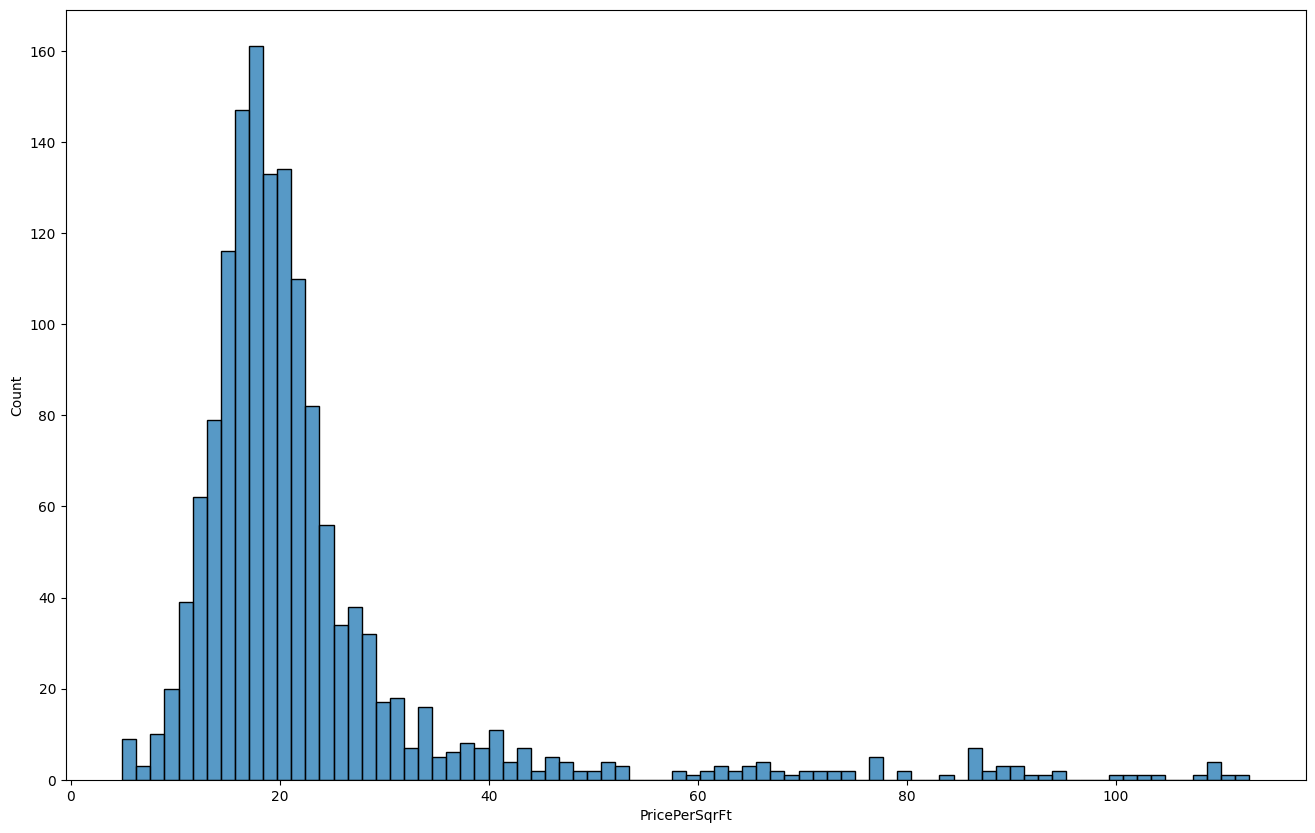

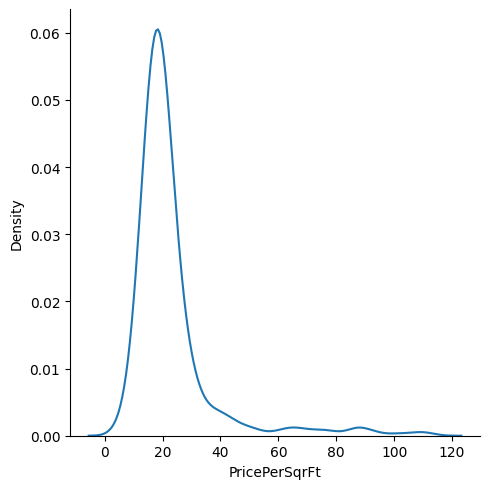

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, figsize=(16,10))

sns.histplot(test_data_csv["PricePerSqrFt"], ax = axs)
sns.displot(test_data_csv["PricePerSqrFt"], kind = 'kde') # I have no idea what it means..
print(test_data_csv["PricePerSqrFt"].describe())


count      1459.000000
mean     179183.918243
std       16518.303051
min      135751.318893
25%      168703.011202
50%      179208.665698
75%      186789.409363
max      281643.976117
Name: SalePrice, dtype: float64


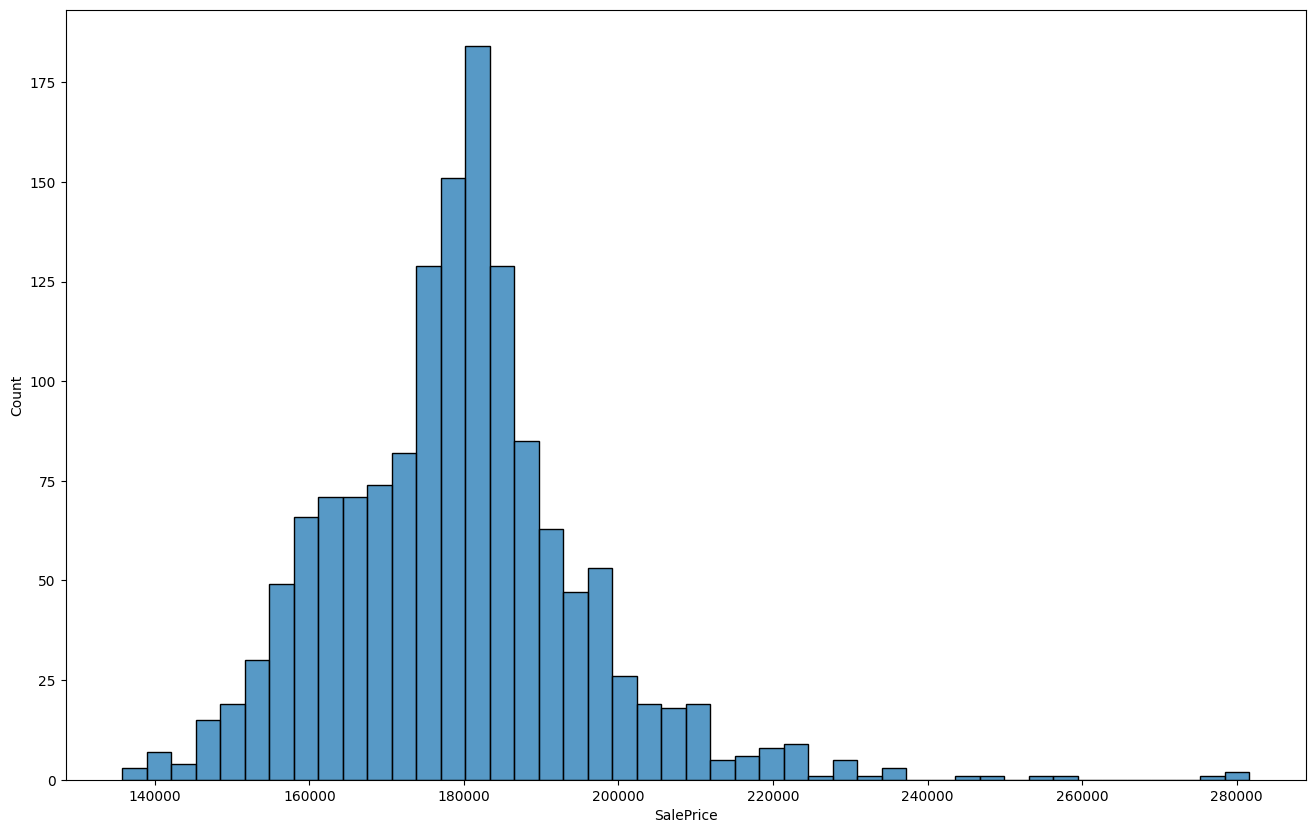

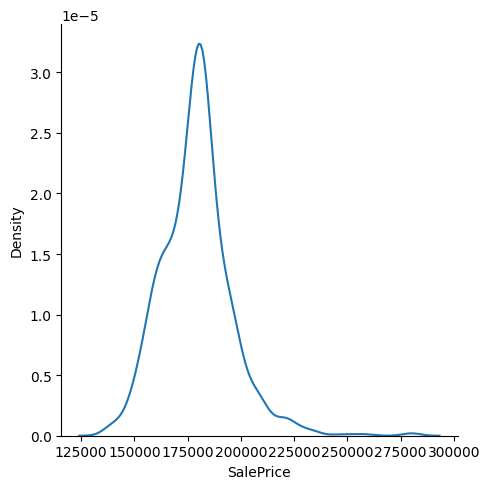

In [19]:
fig, axs = plt.subplots(1, figsize=(16,10))
sns.histplot(test_data_csv["SalePrice"], ax = axs)
sns.displot(test_data_csv["SalePrice"], kind = 'kde') # I have no idea what it means..

print(test_data_csv["SalePrice"].describe())

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

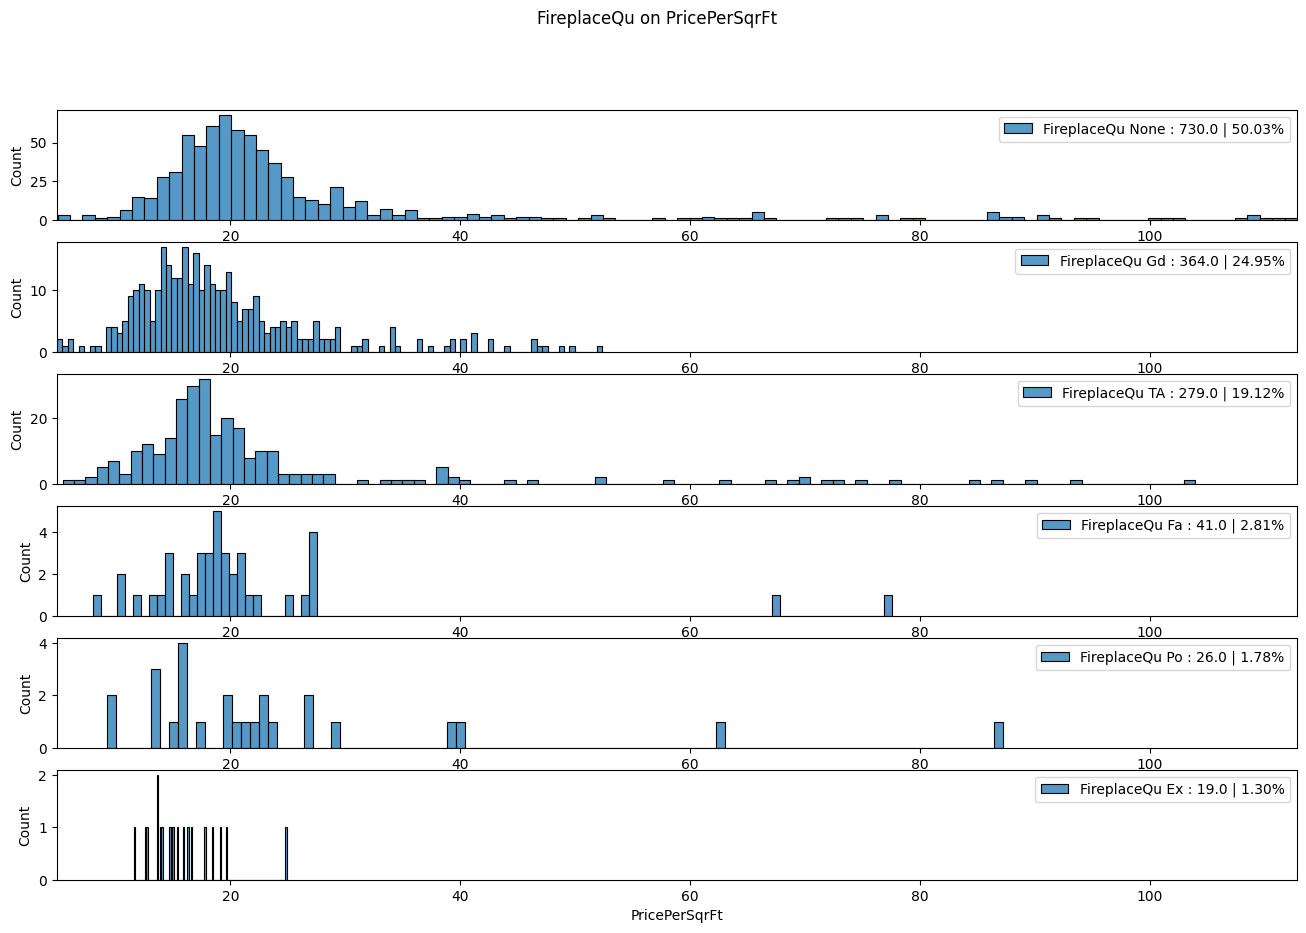

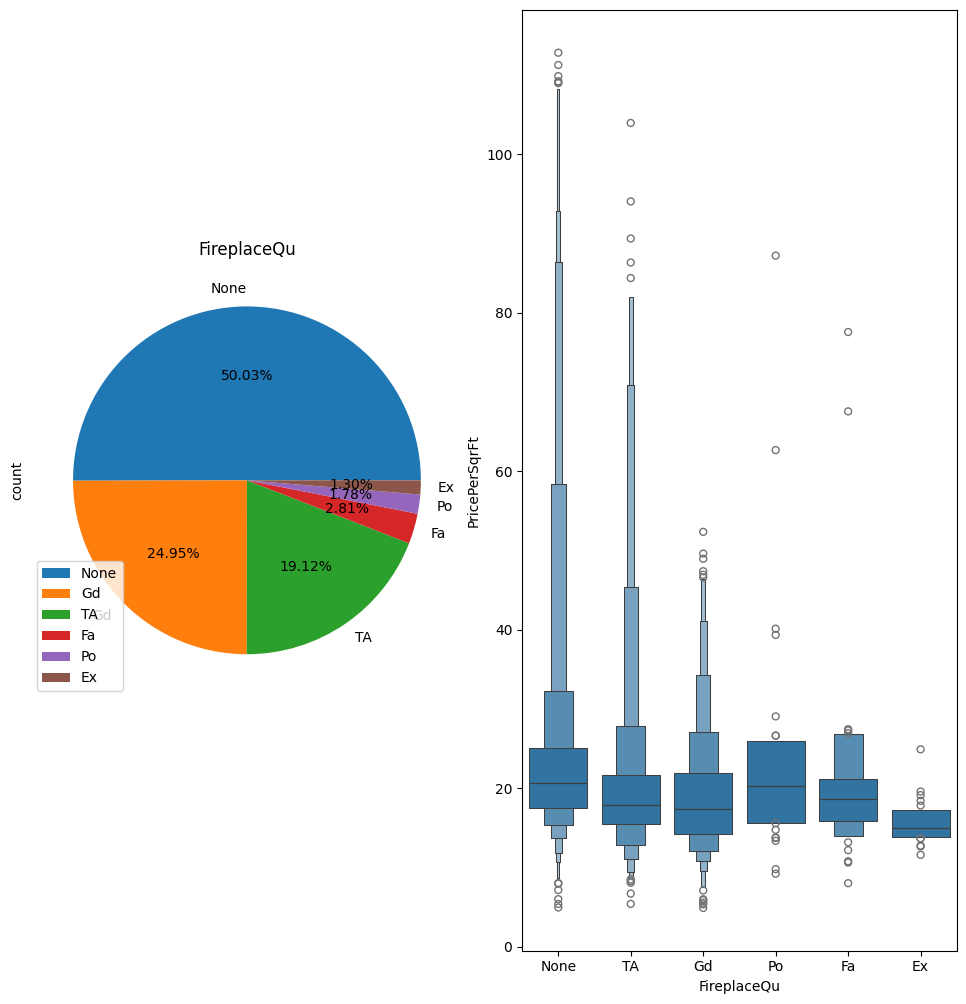

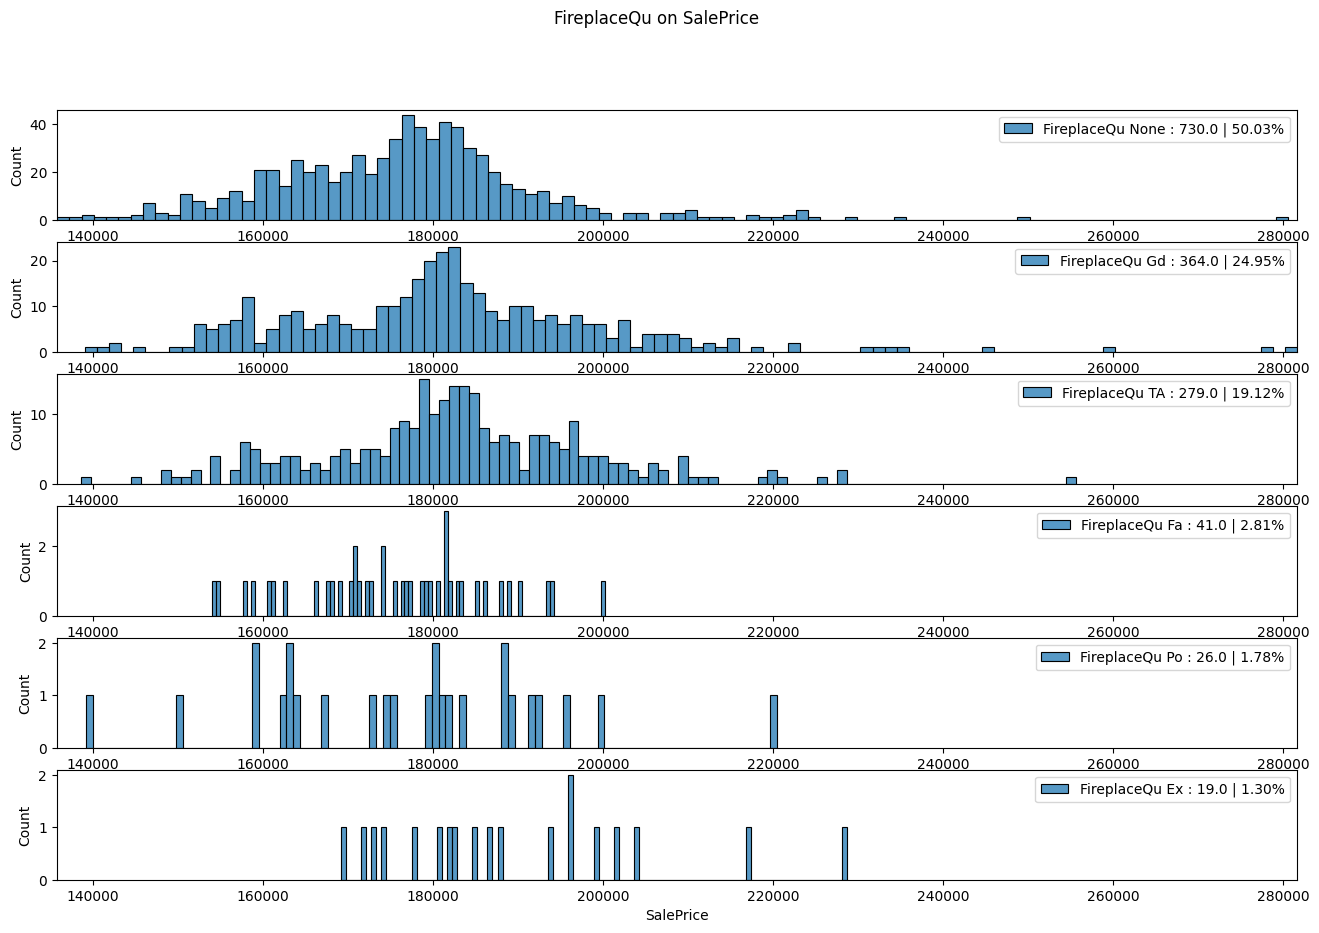

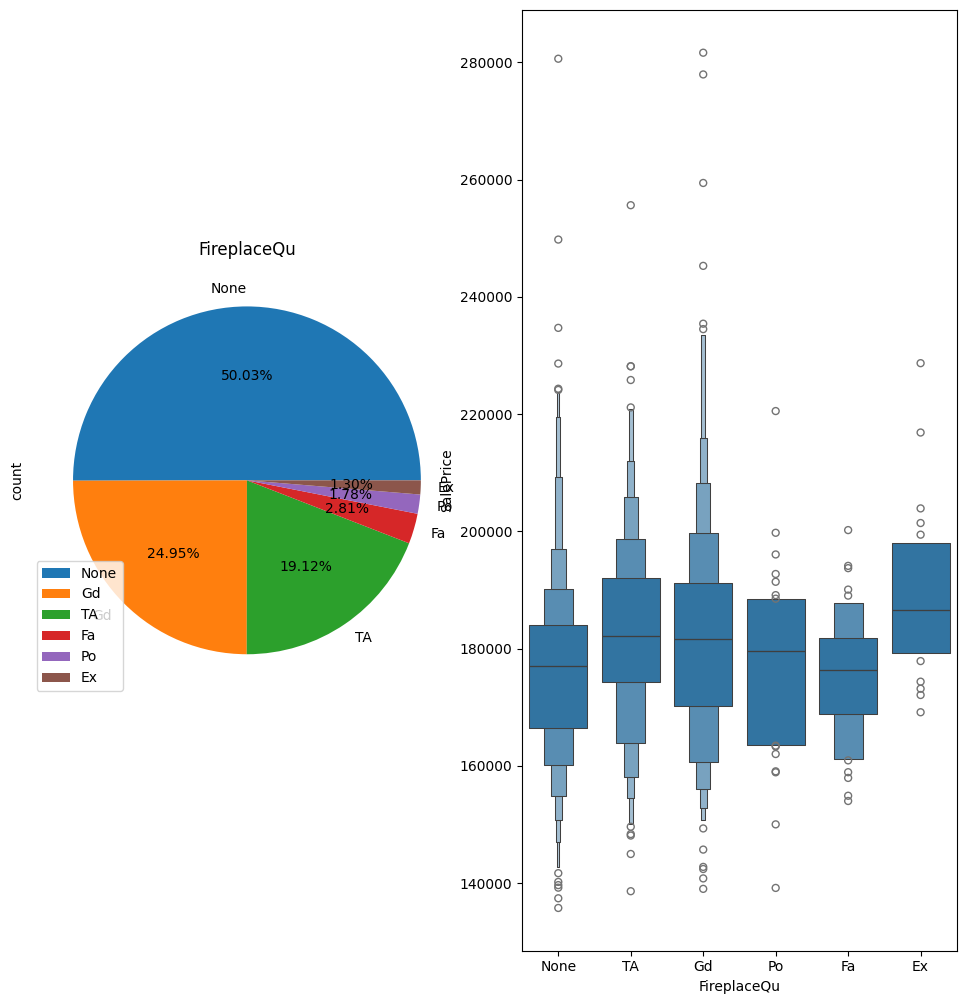

In [20]:
#EFILRYN FireplaceQu does not count into price
plot_unique_category(test_data_csv,'FireplaceQu','PricePerSqrFt');
plot_unique_category(test_data_csv,'FireplaceQu','SalePrice');


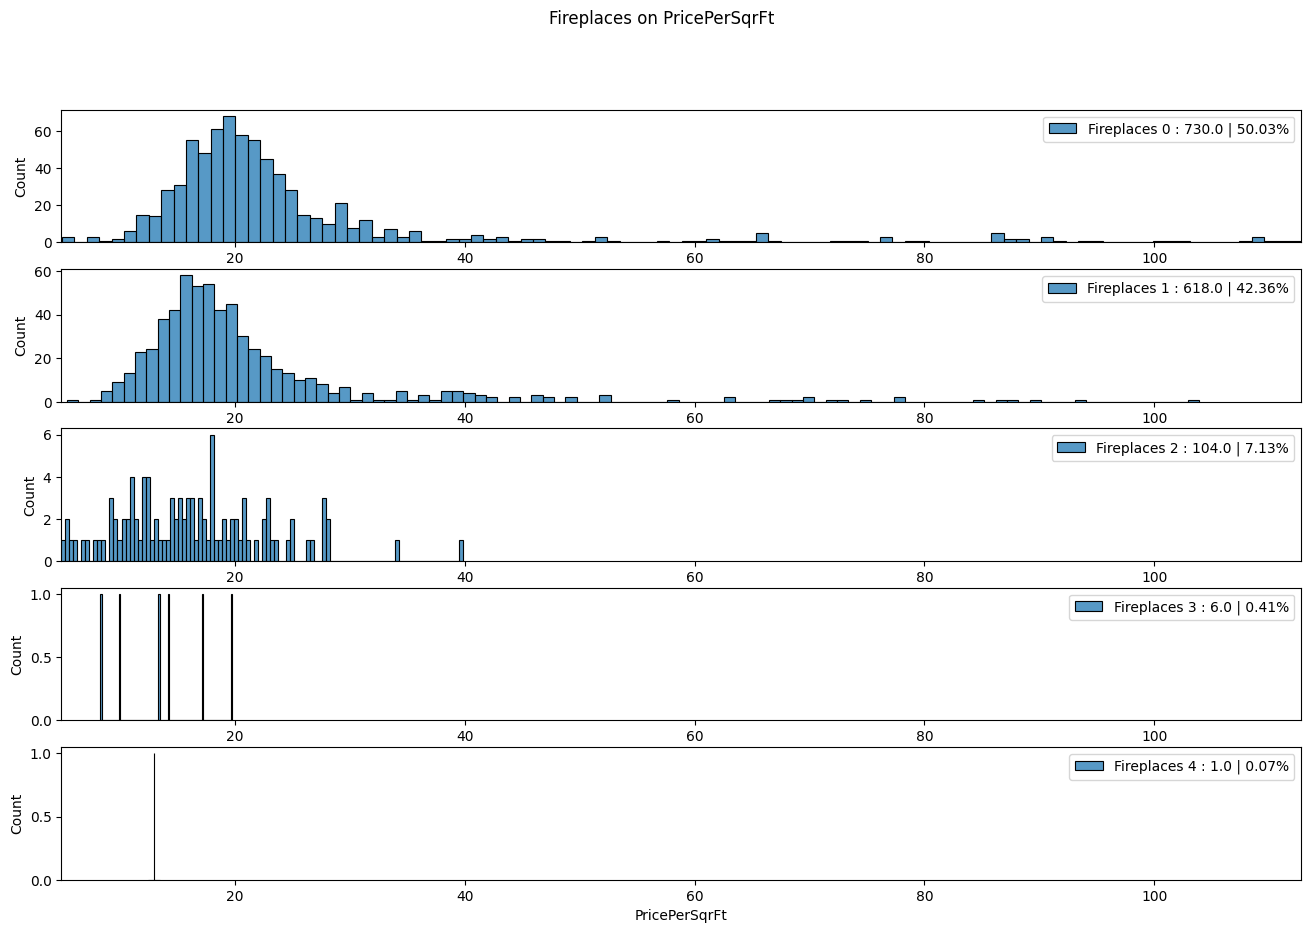

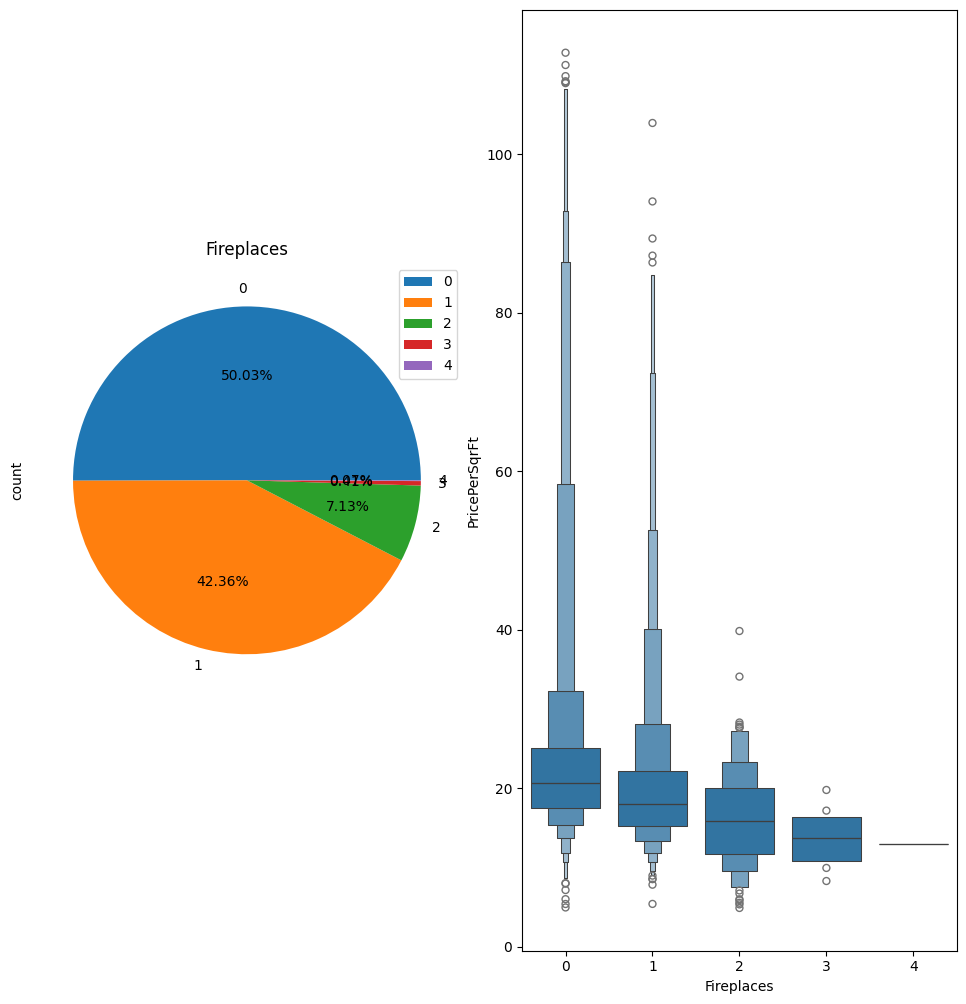

In [21]:
#EFILRYN Number Of fireplaces does not count into price
plot_unique_category(test_data_csv,'Fireplaces','PricePerSqrFt');

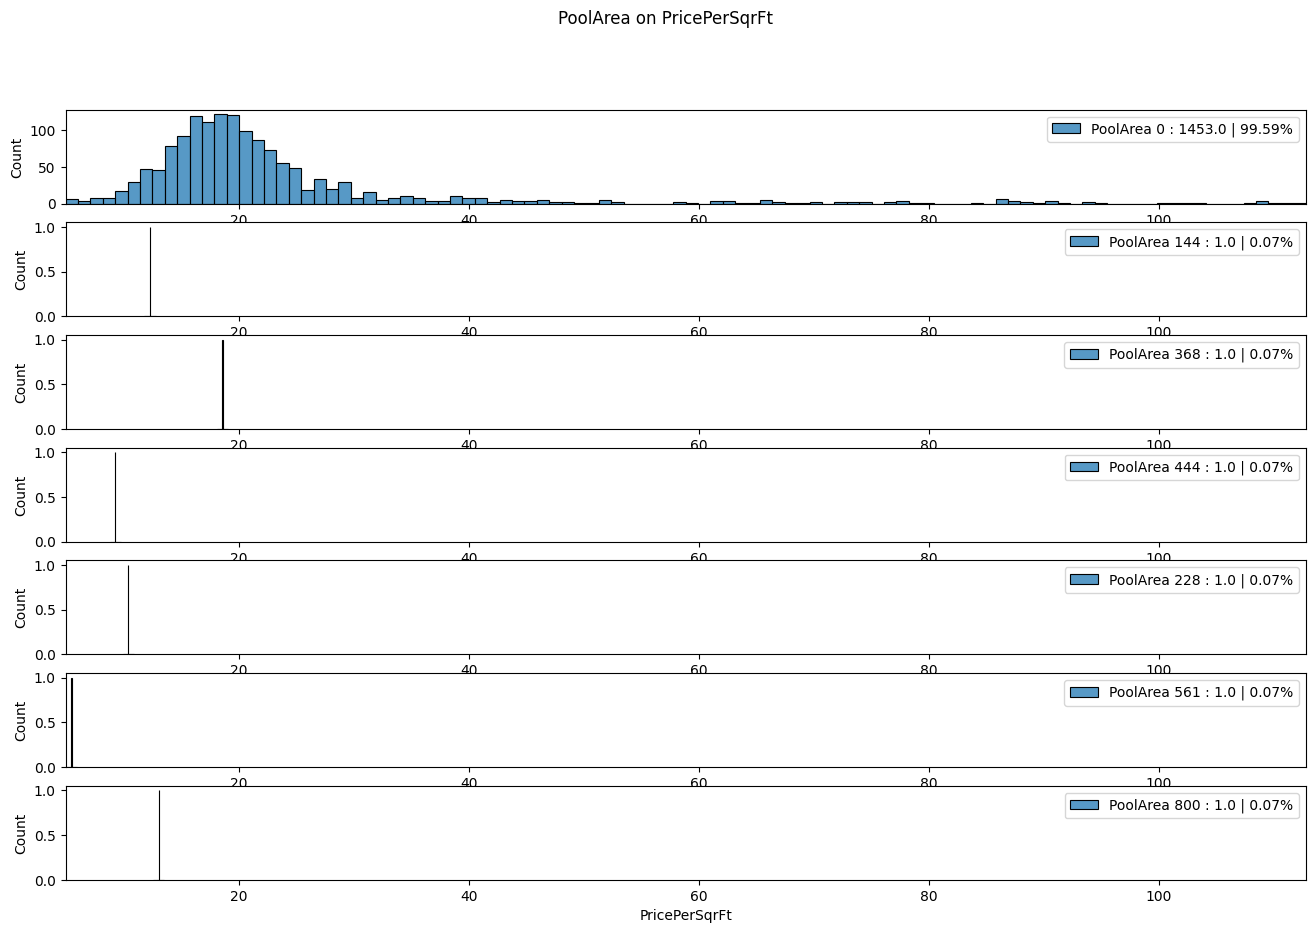

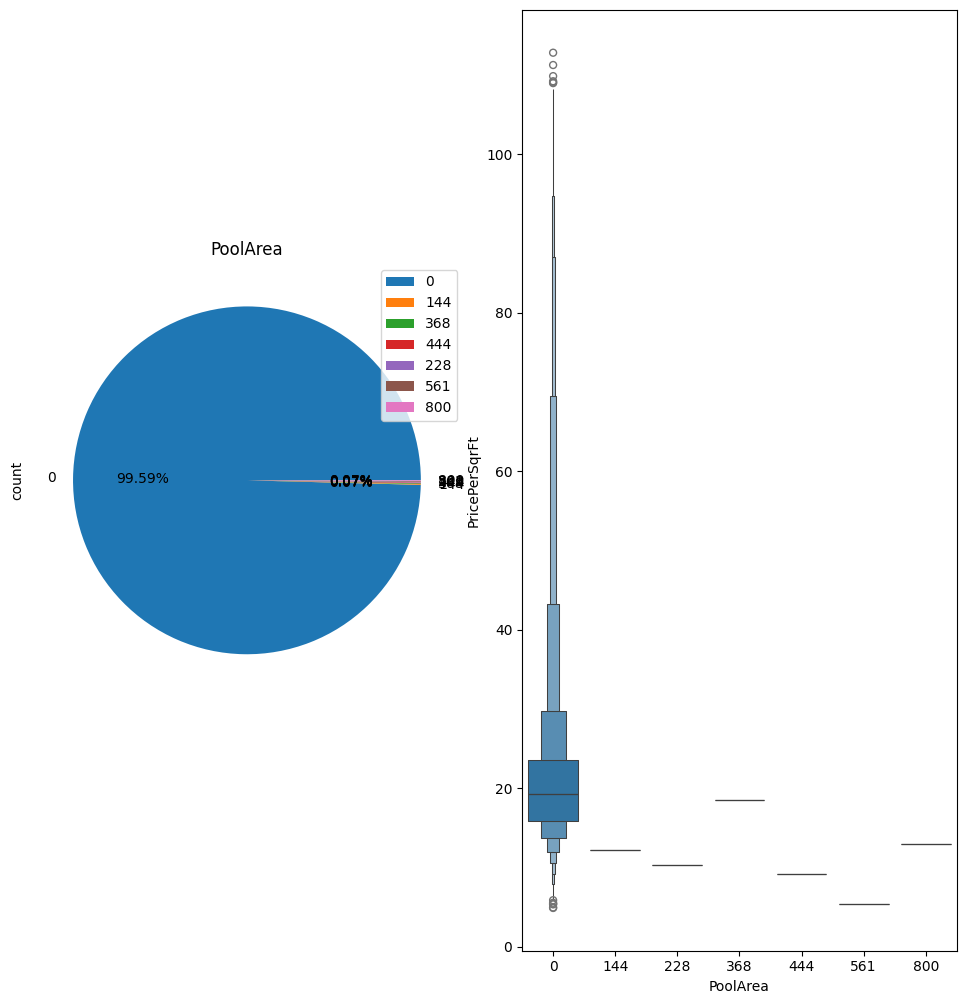

In [22]:
plot_unique_category(test_data_csv,'PoolArea','PricePerSqrFt');


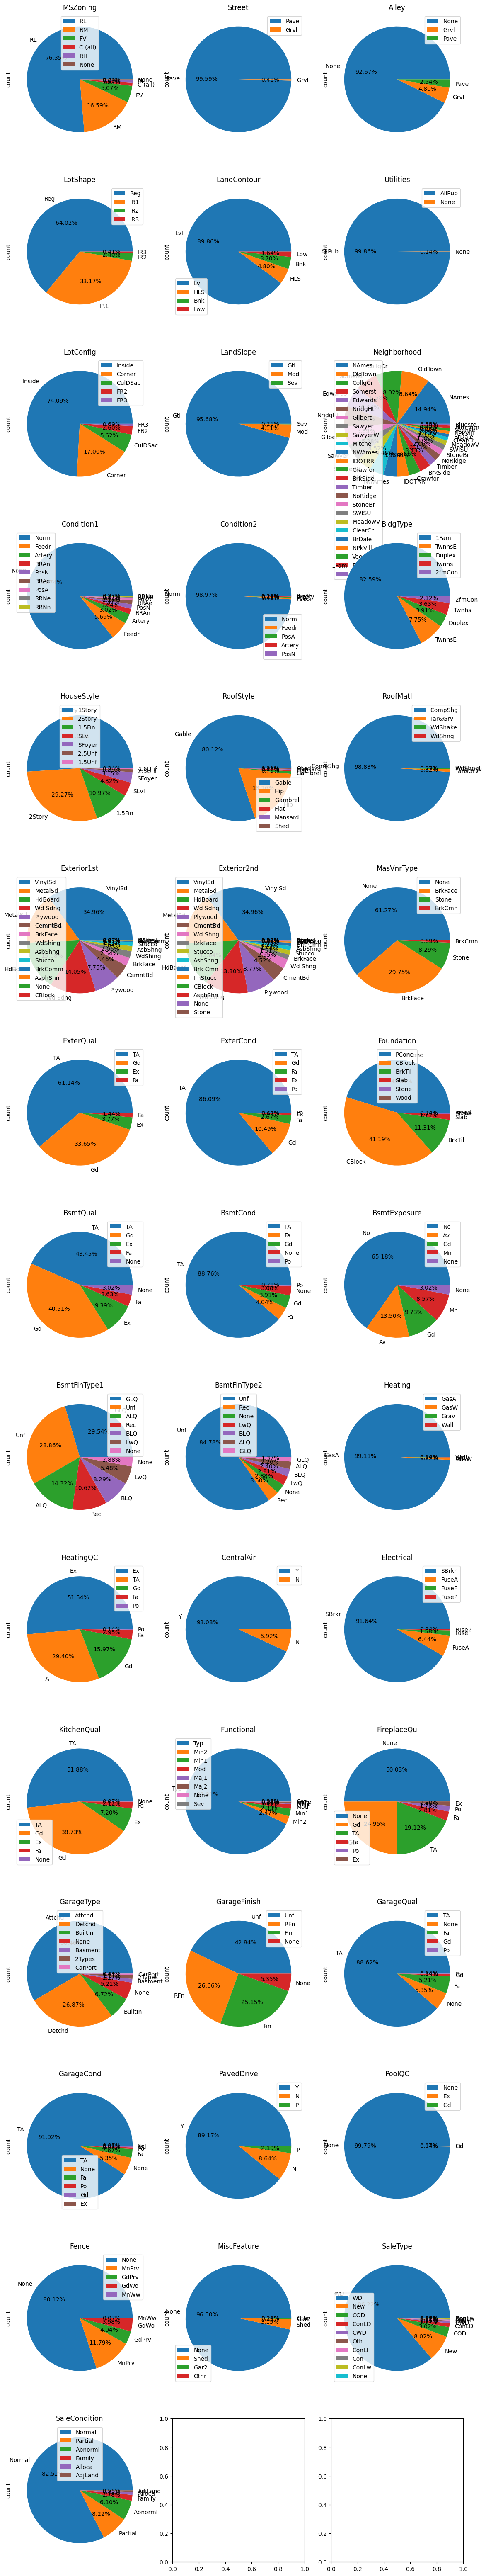

In [23]:
number_cols = get_data_type(test_data_csv,PDataType.CATHEGORICAL)
plot_pie_for_unique_category_array(test_data_csv, number_cols.columns.to_numpy())

In [24]:
train_data_csv = pd.read_csv("train.csv")
print(train_data_csv.describe())
print(train_data_csv.shape)

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

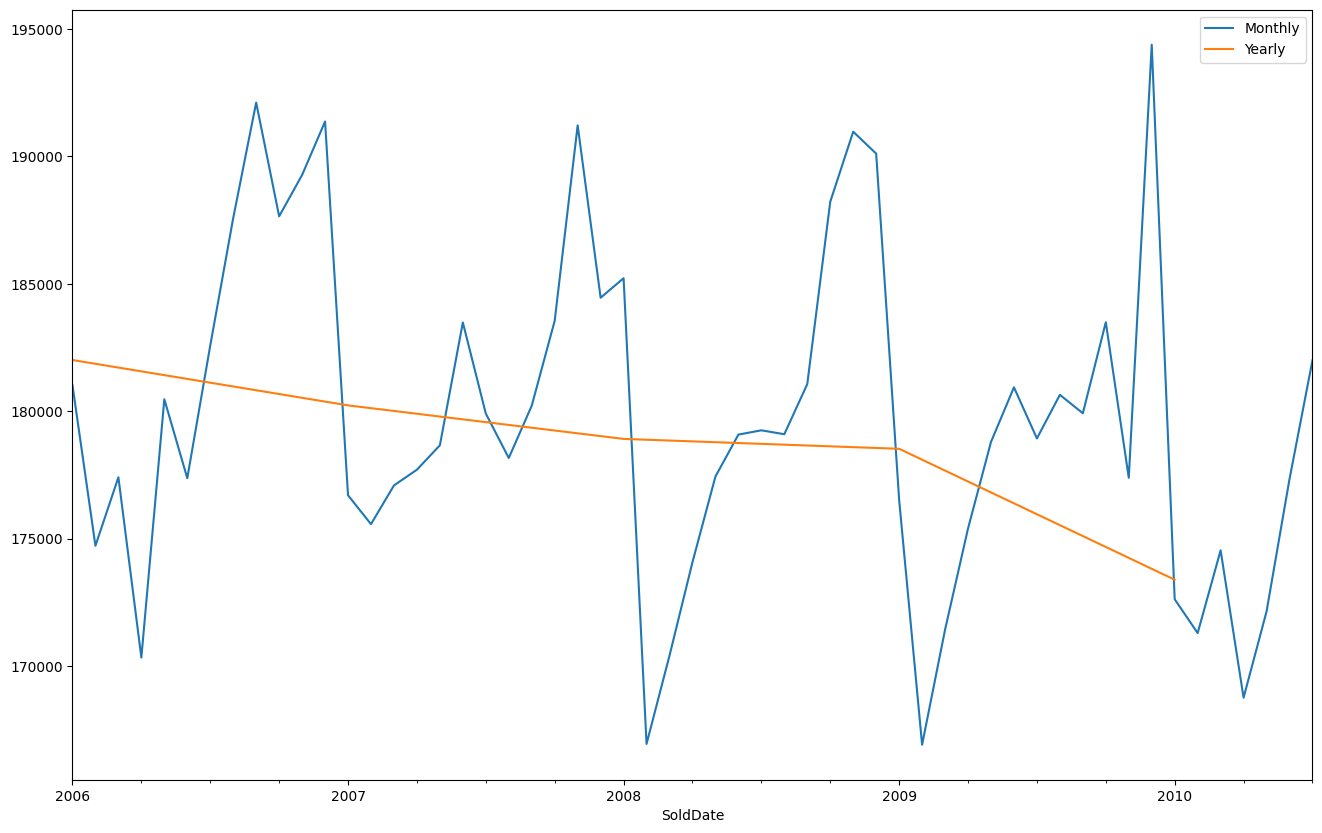

In [25]:
test_data_csv.set_index('SoldDate').resample('ME')['SalePrice'].mean().plot.line(legend = True, figsize=(16,10))
test_data_csv.set_index('SoldDate').resample('YE')['SalePrice'].mean().plot.line(legend = True, figsize=(16,10))
plt.legend(["Monthly", "Yearly"]);

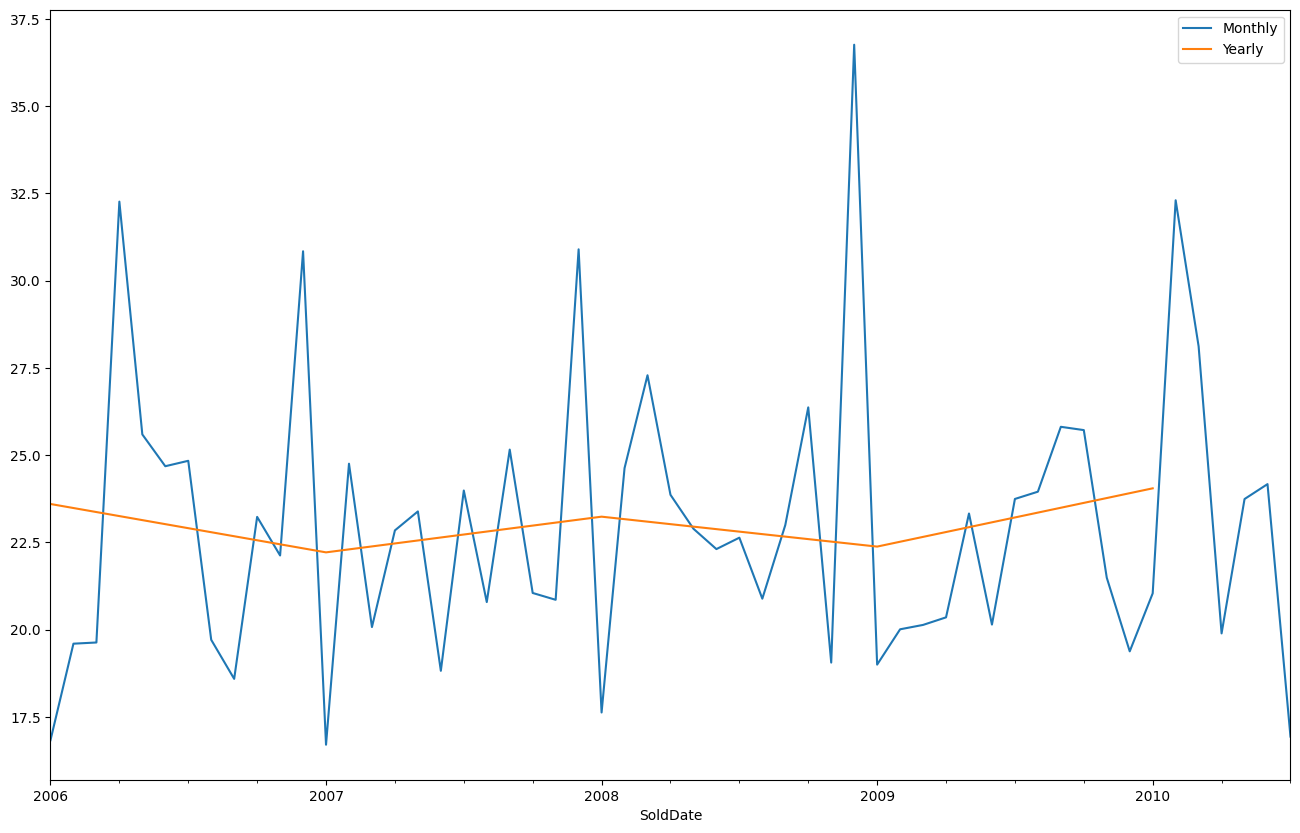

In [26]:
#price over years
#test_data_csv.plot.scatter(x='SoldDate',y='PricePerSqrFt')

test_data_csv.set_index('SoldDate').resample('ME')['PricePerSqrFt'].mean().plot.line(legend = True, figsize=(16,10))
test_data_csv.set_index('SoldDate').resample('YE')['PricePerSqrFt'].mean().plot.line(legend = True, figsize=(16,10))
plt.legend(["Monthly", "Yearly"]);



['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


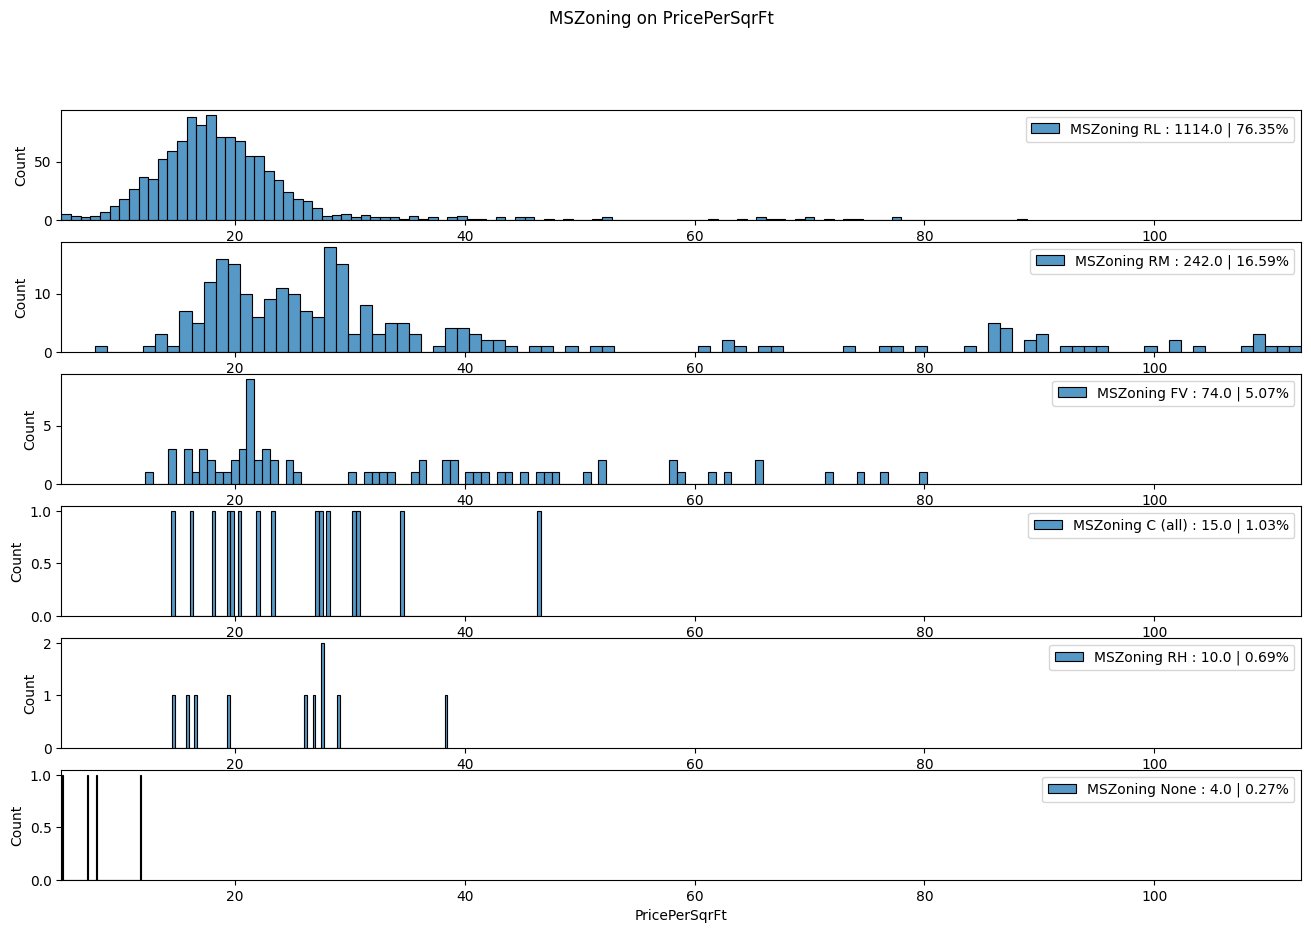

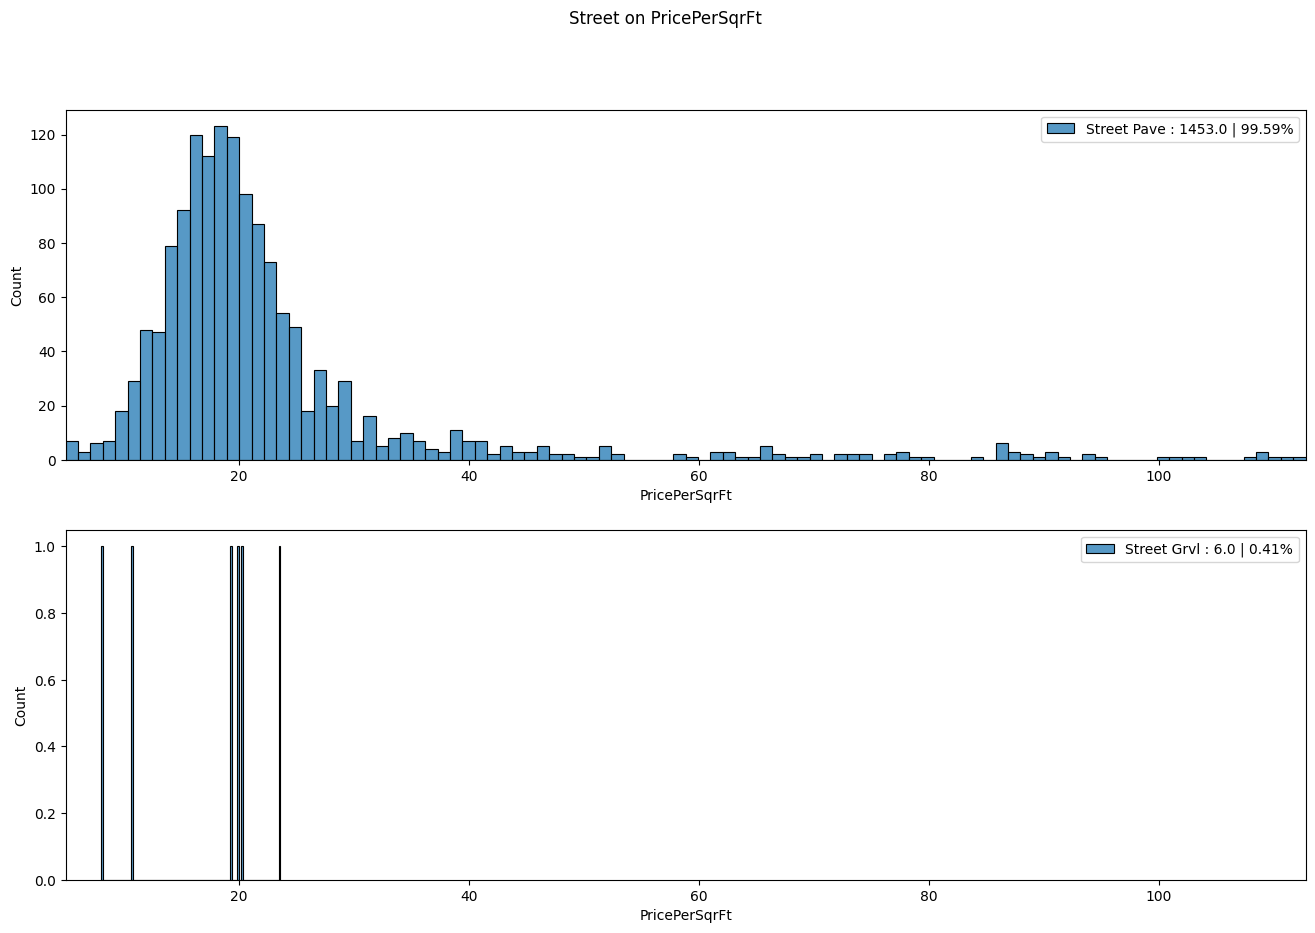

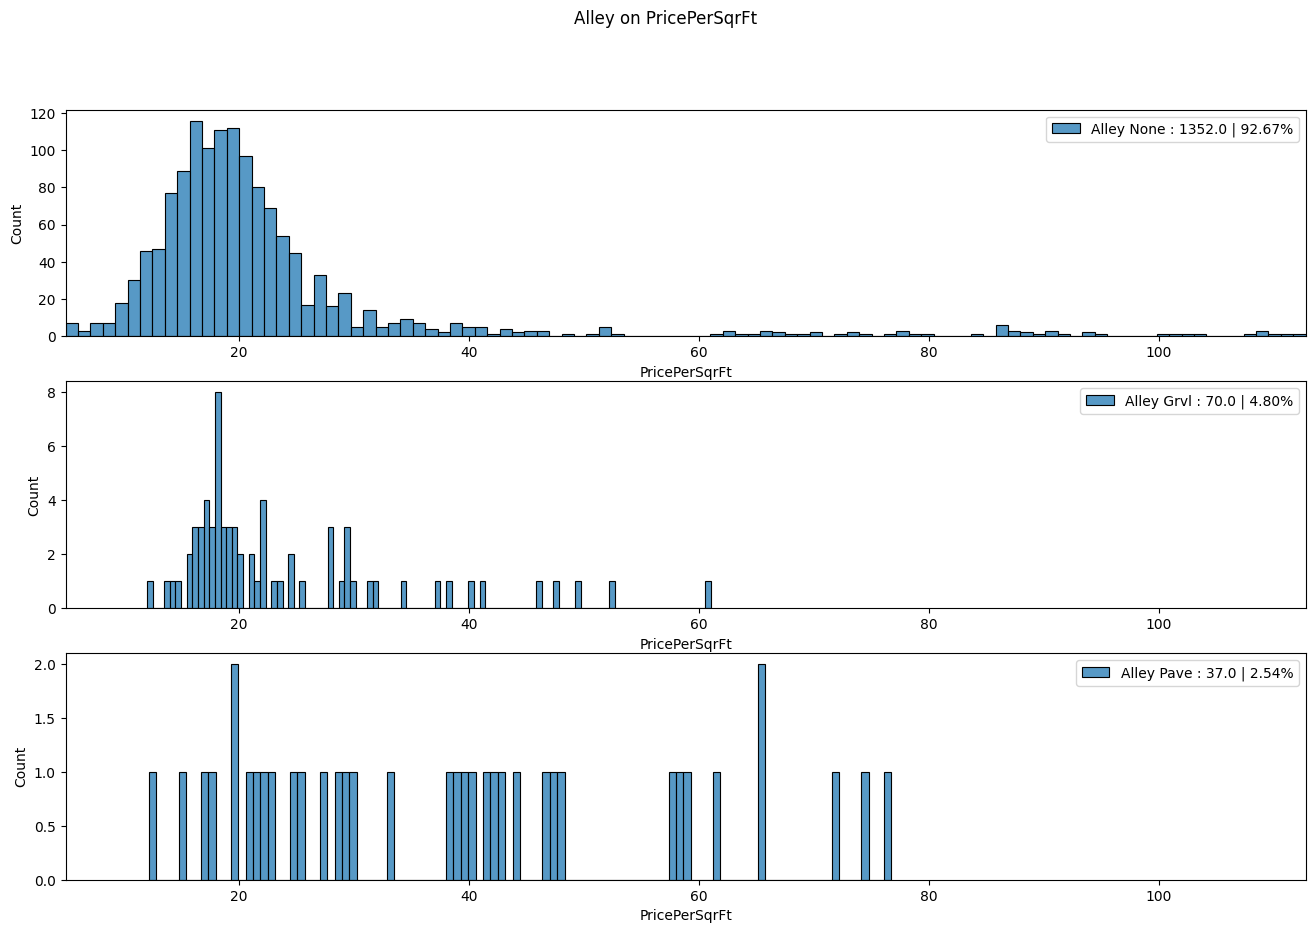

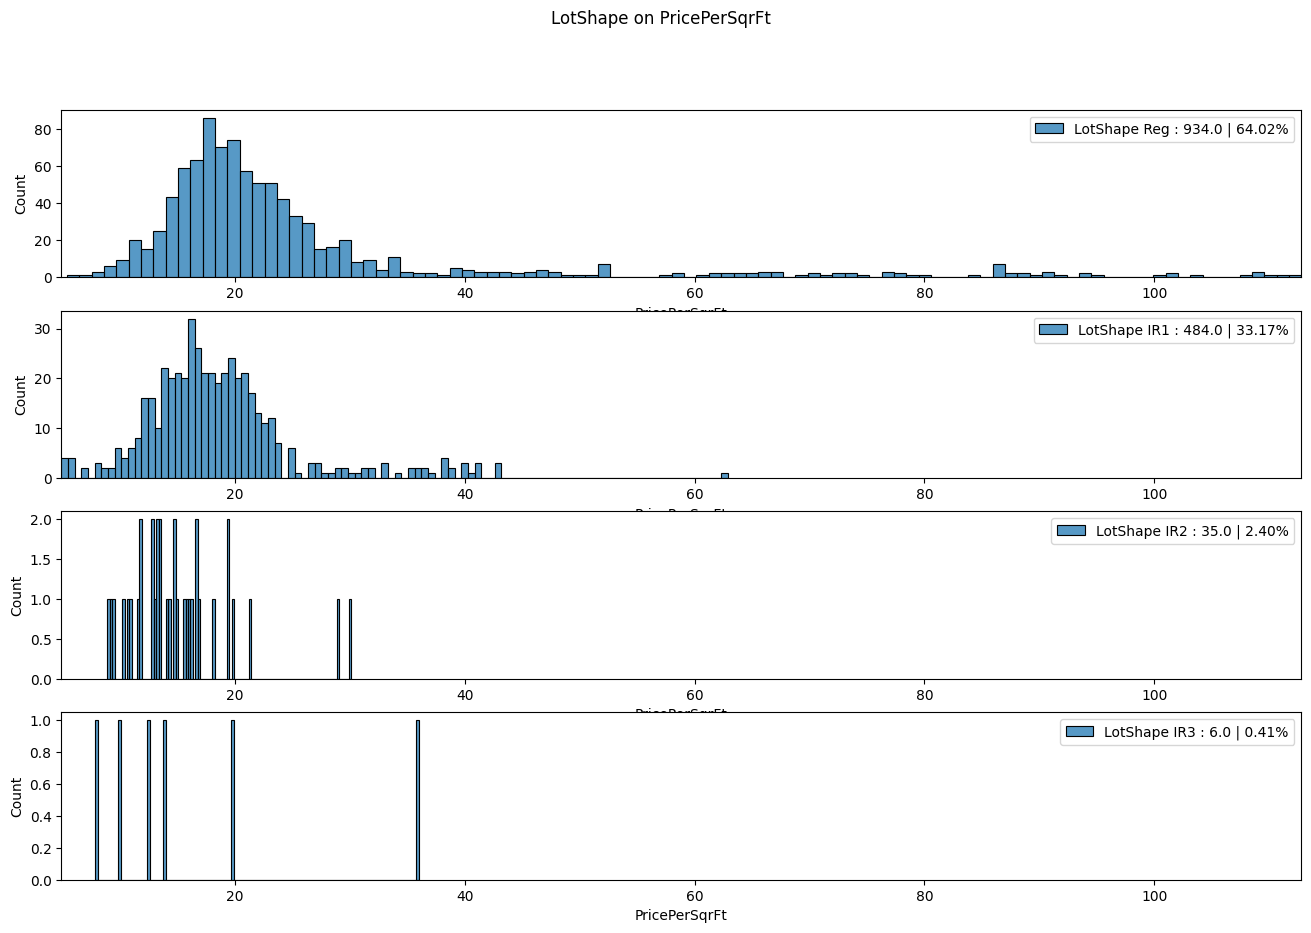

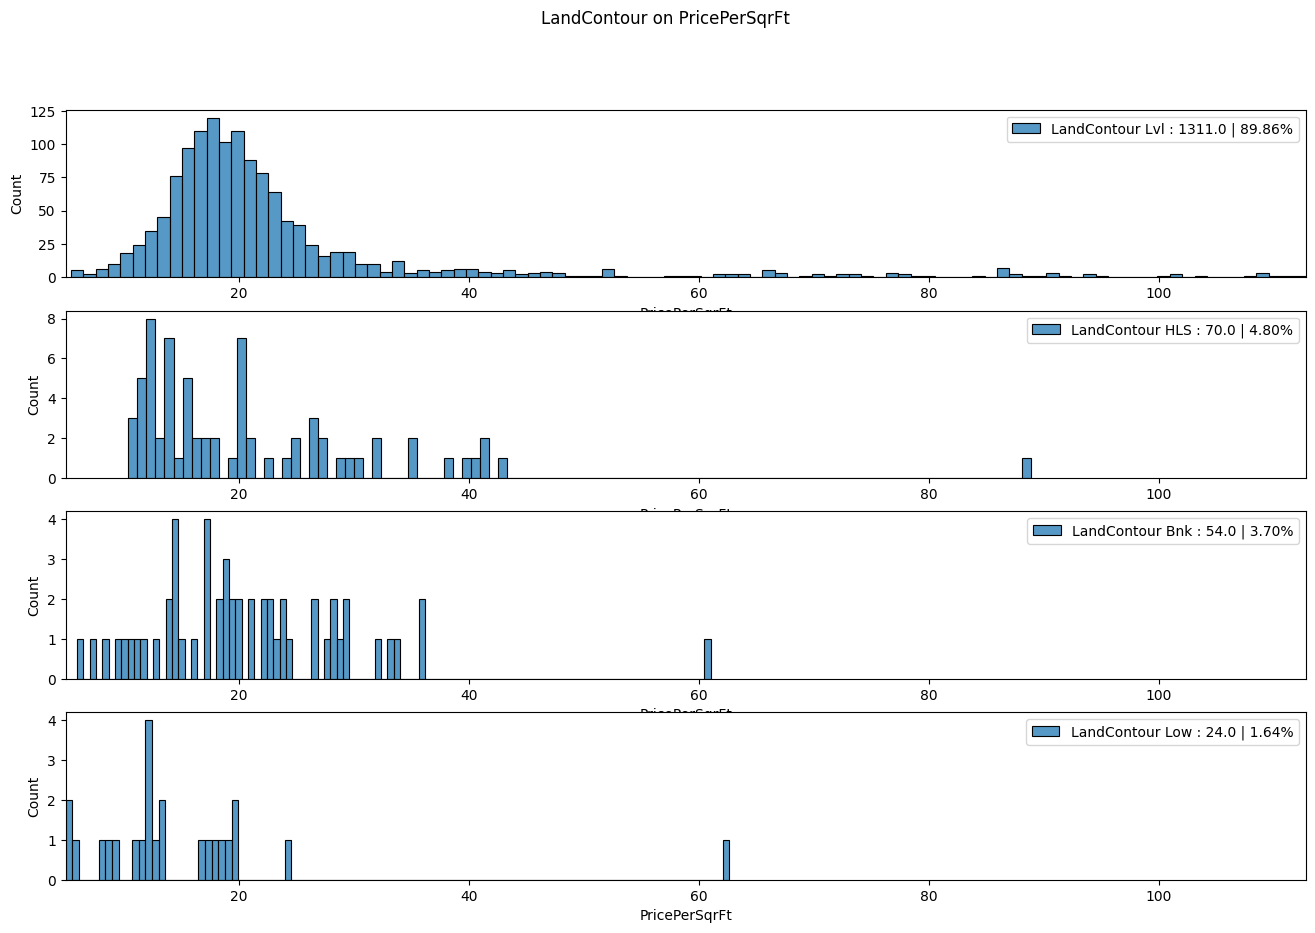

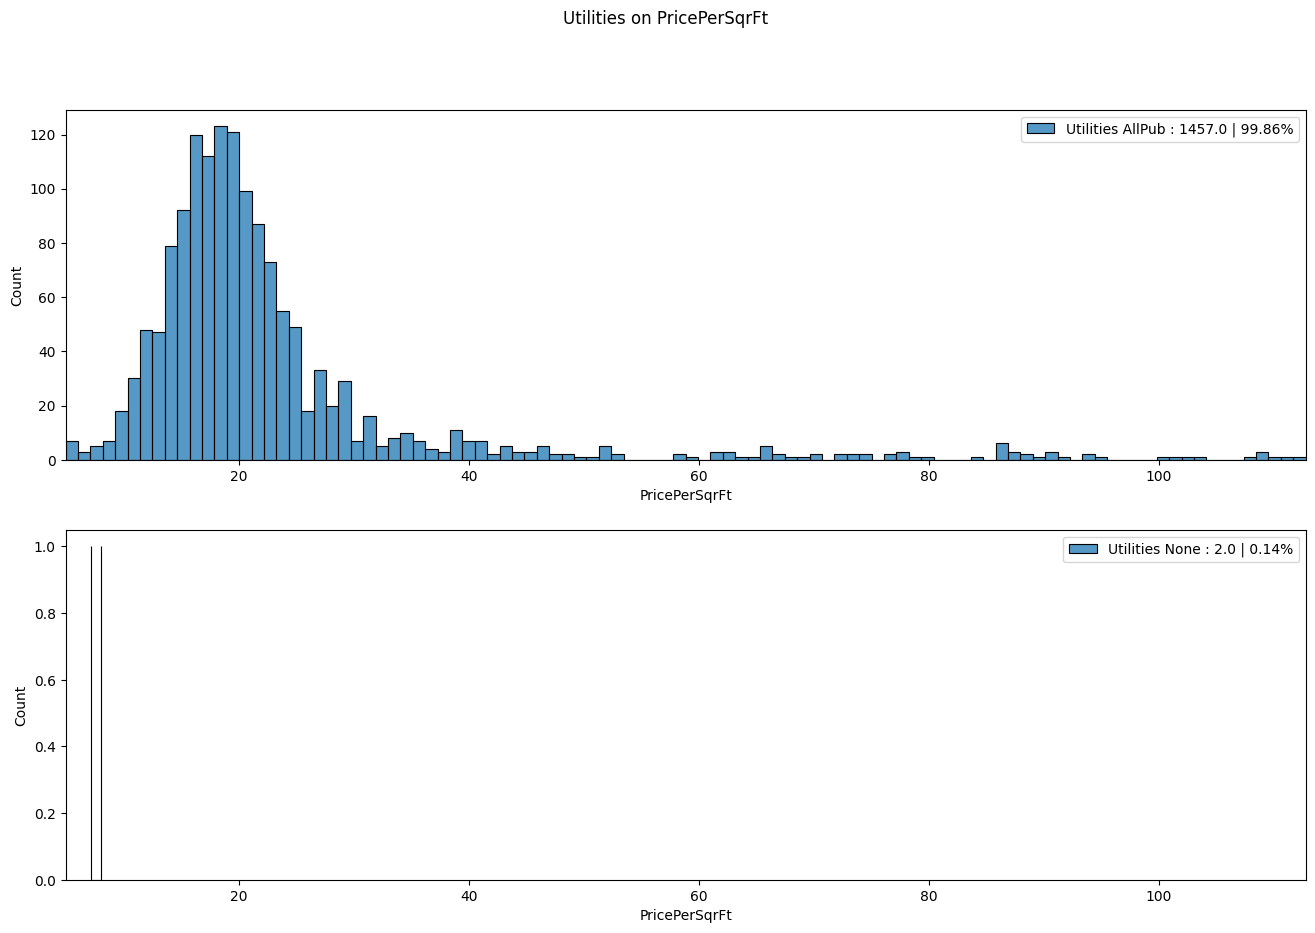

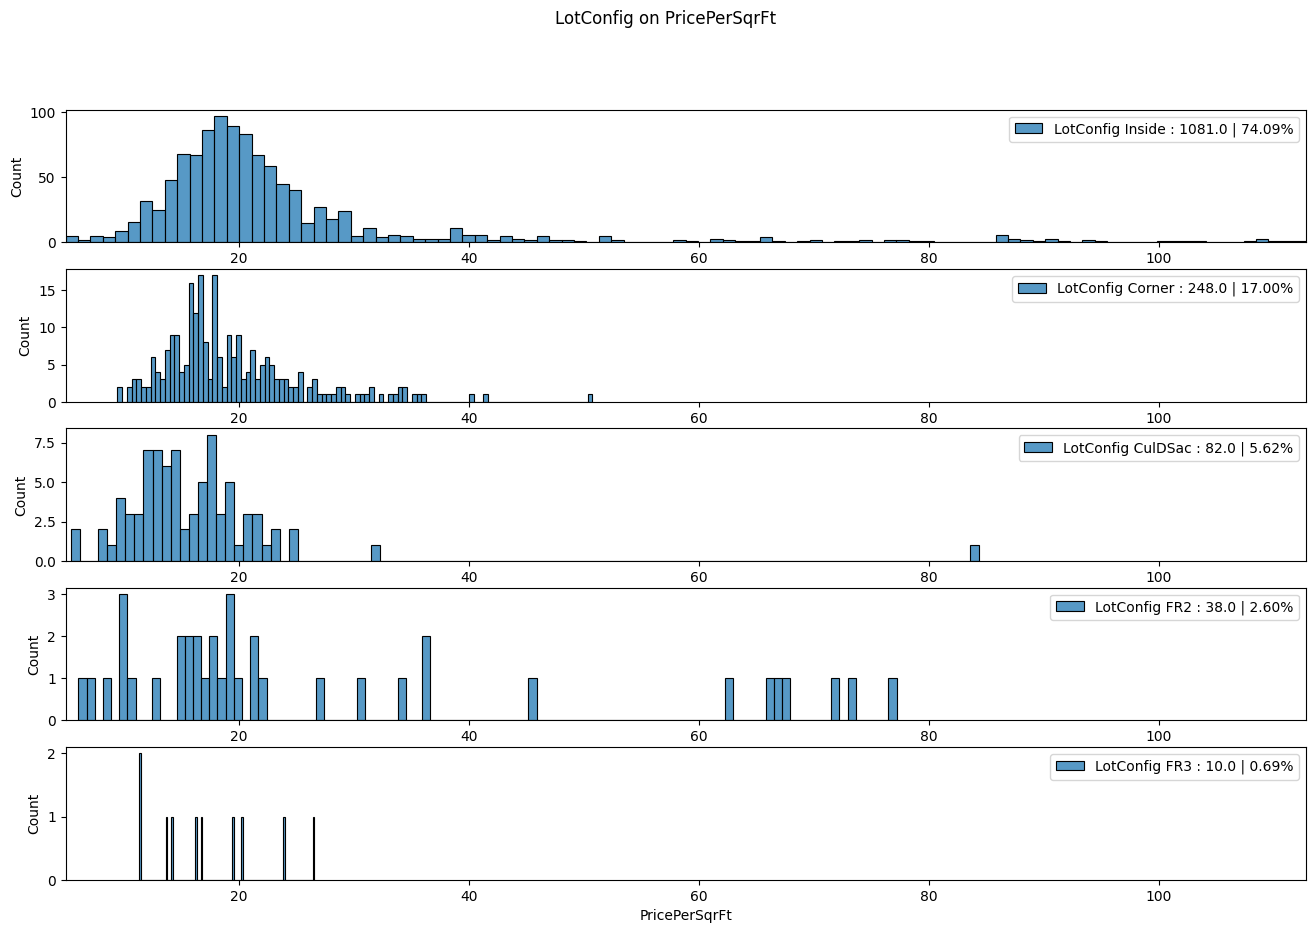

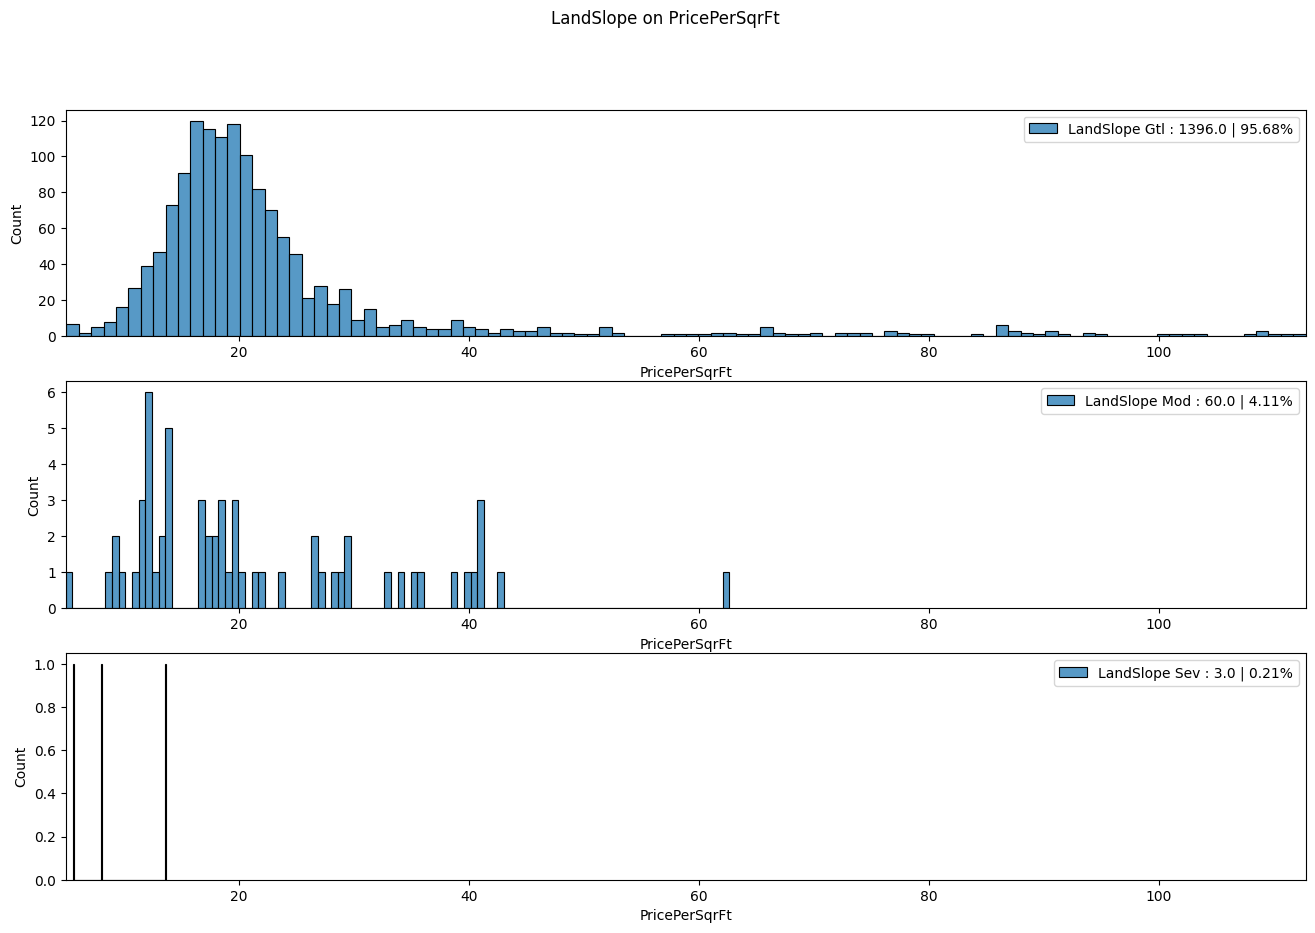

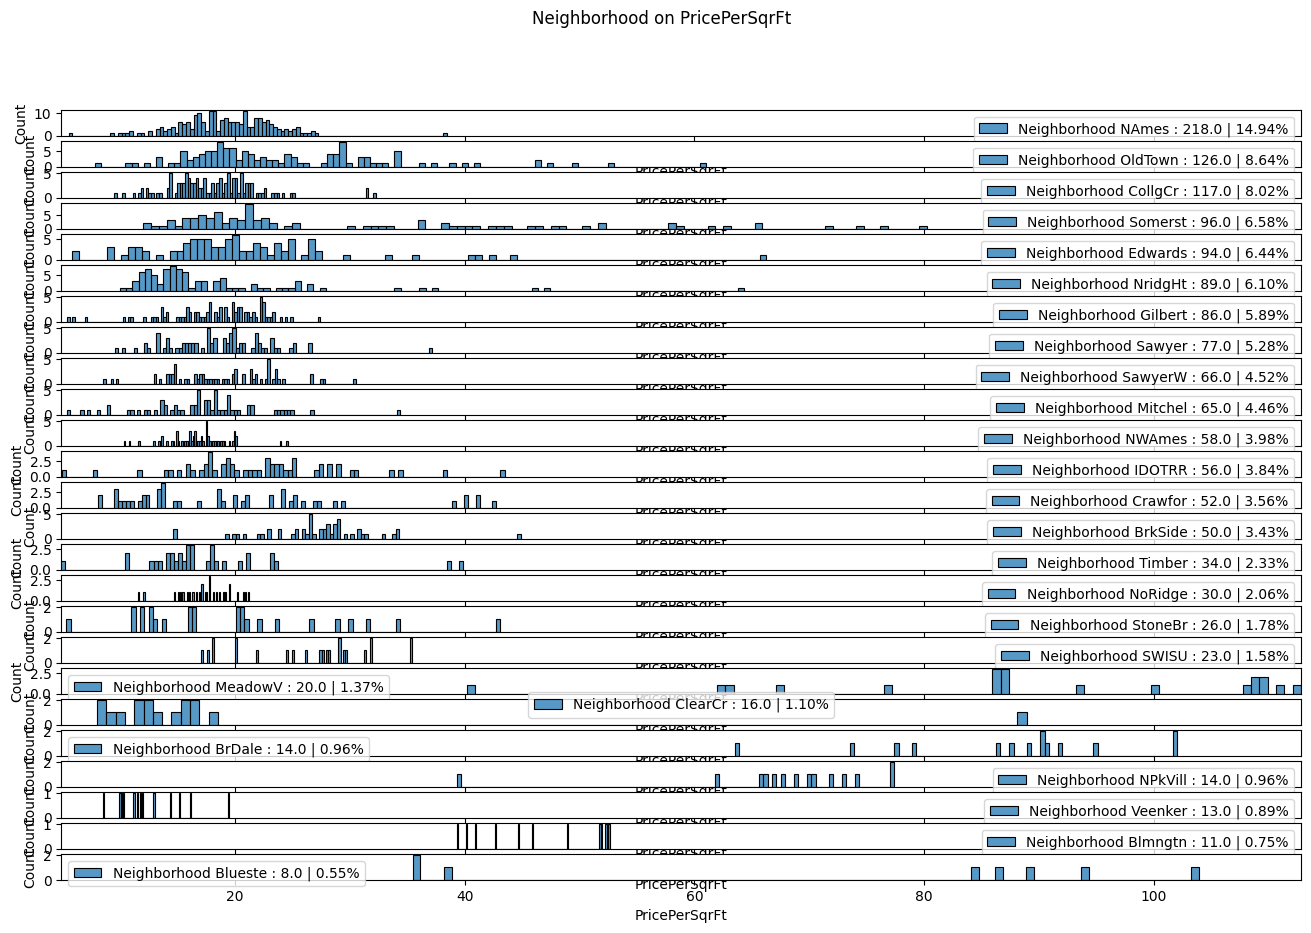

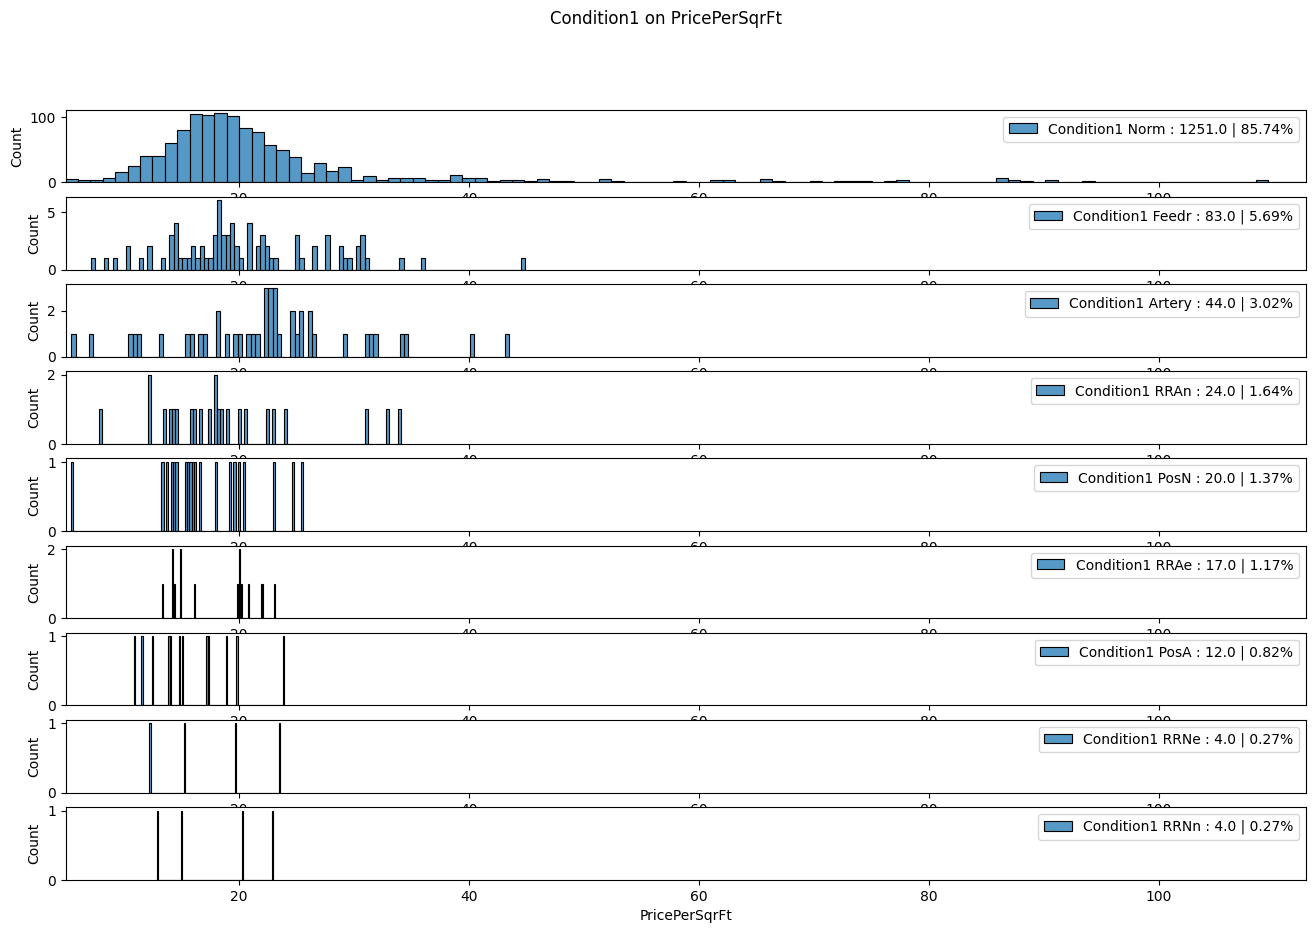

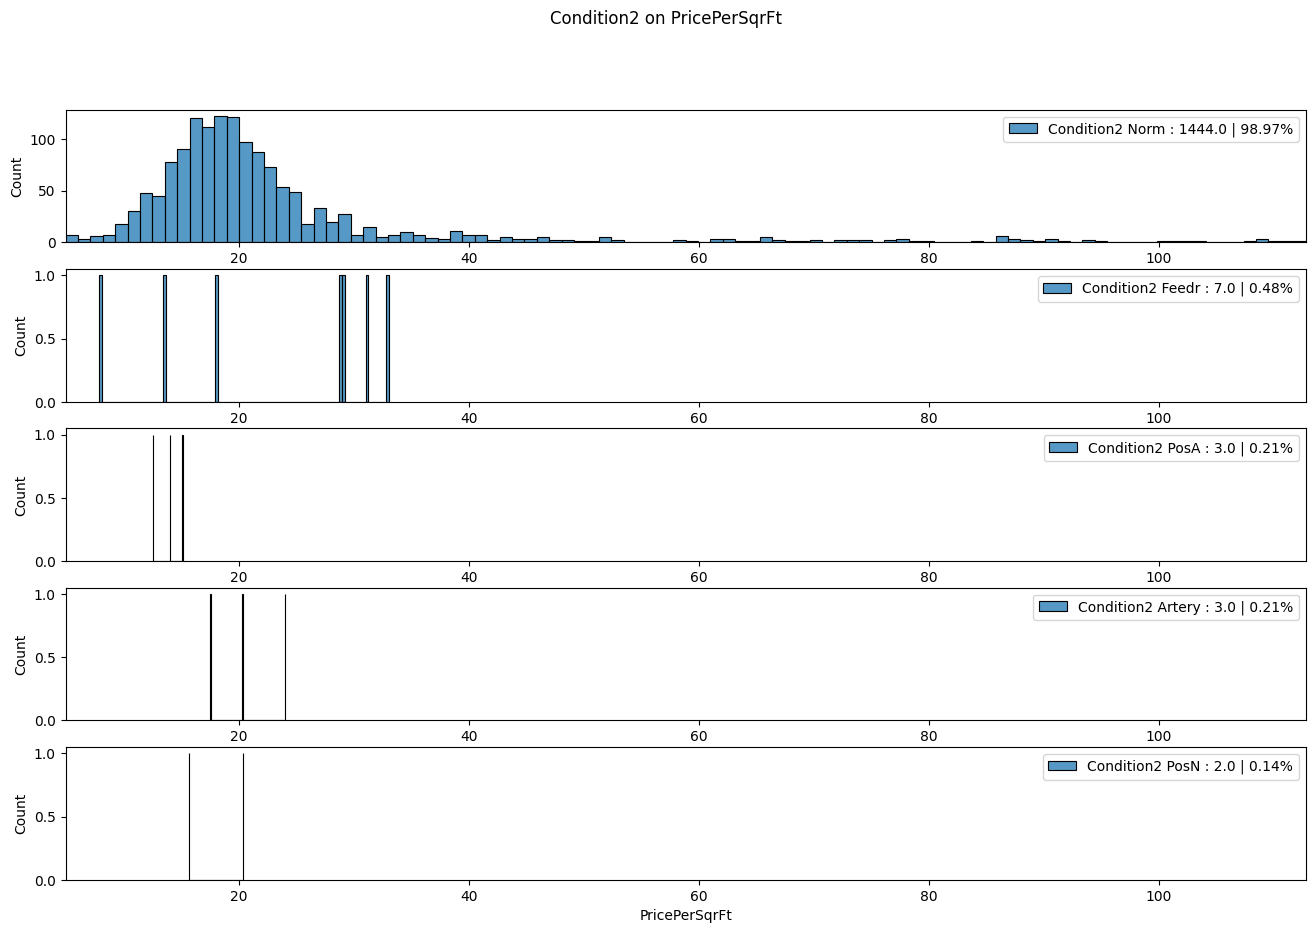

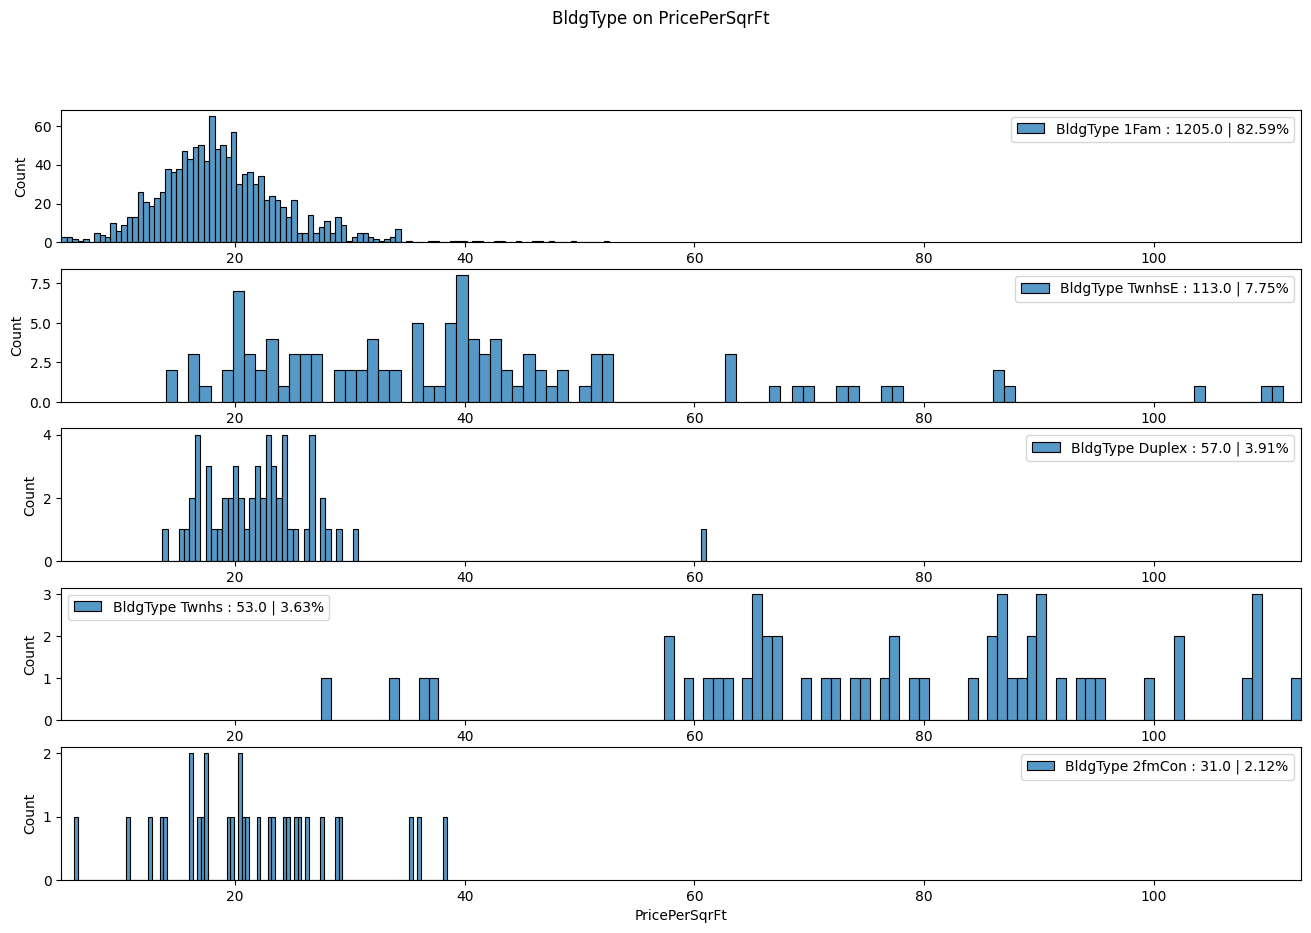

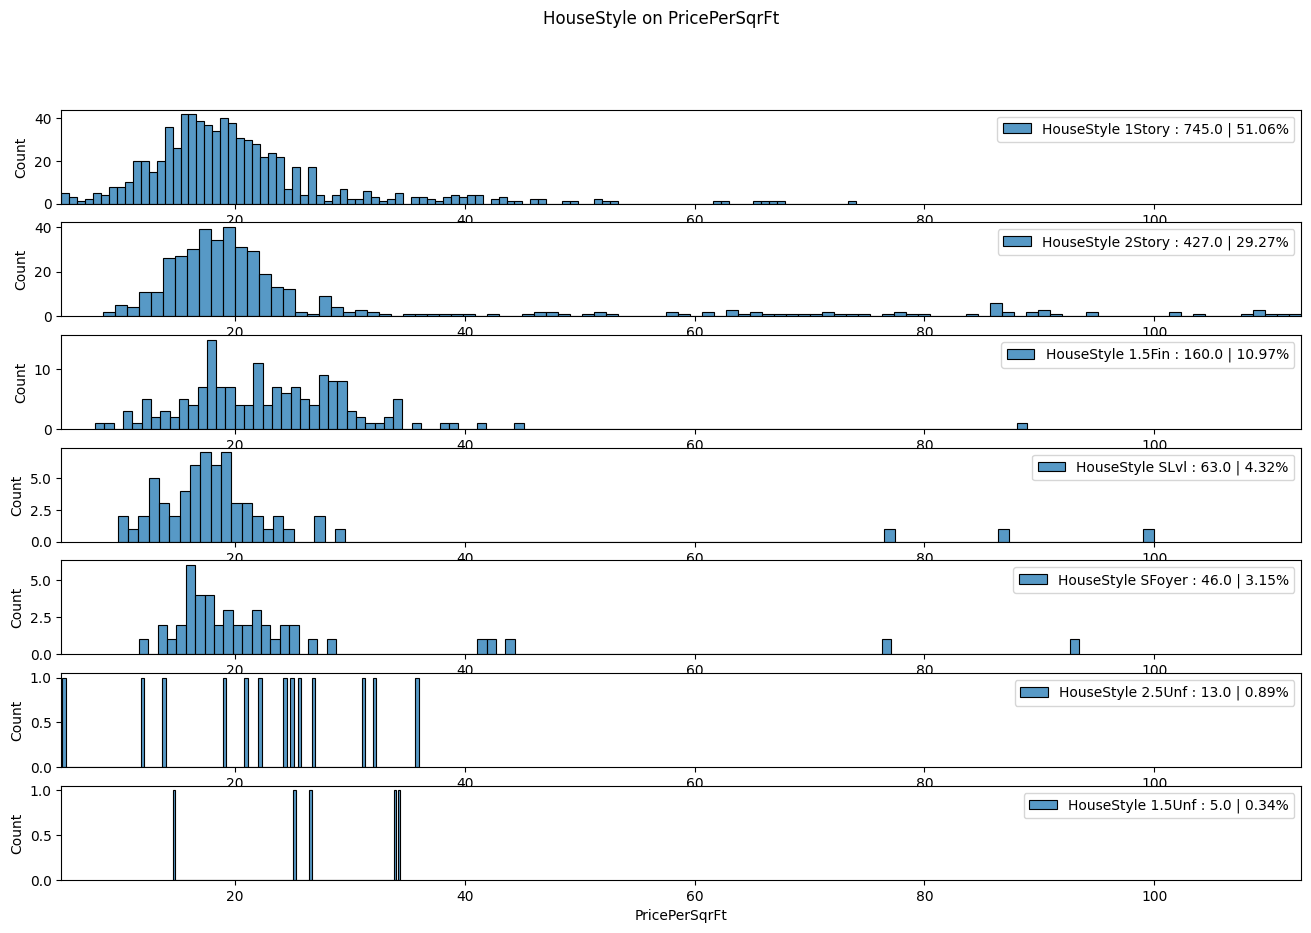

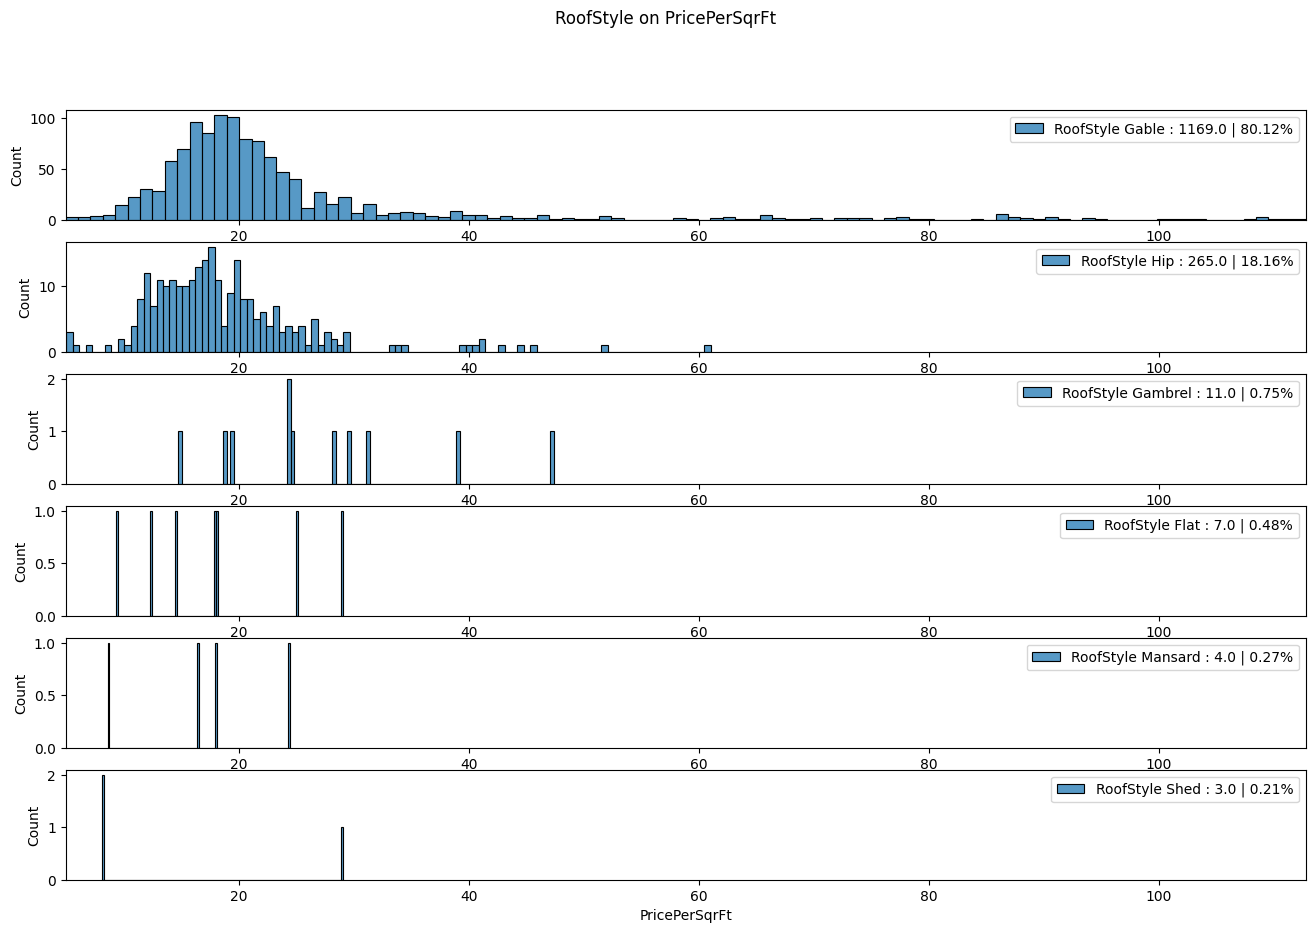

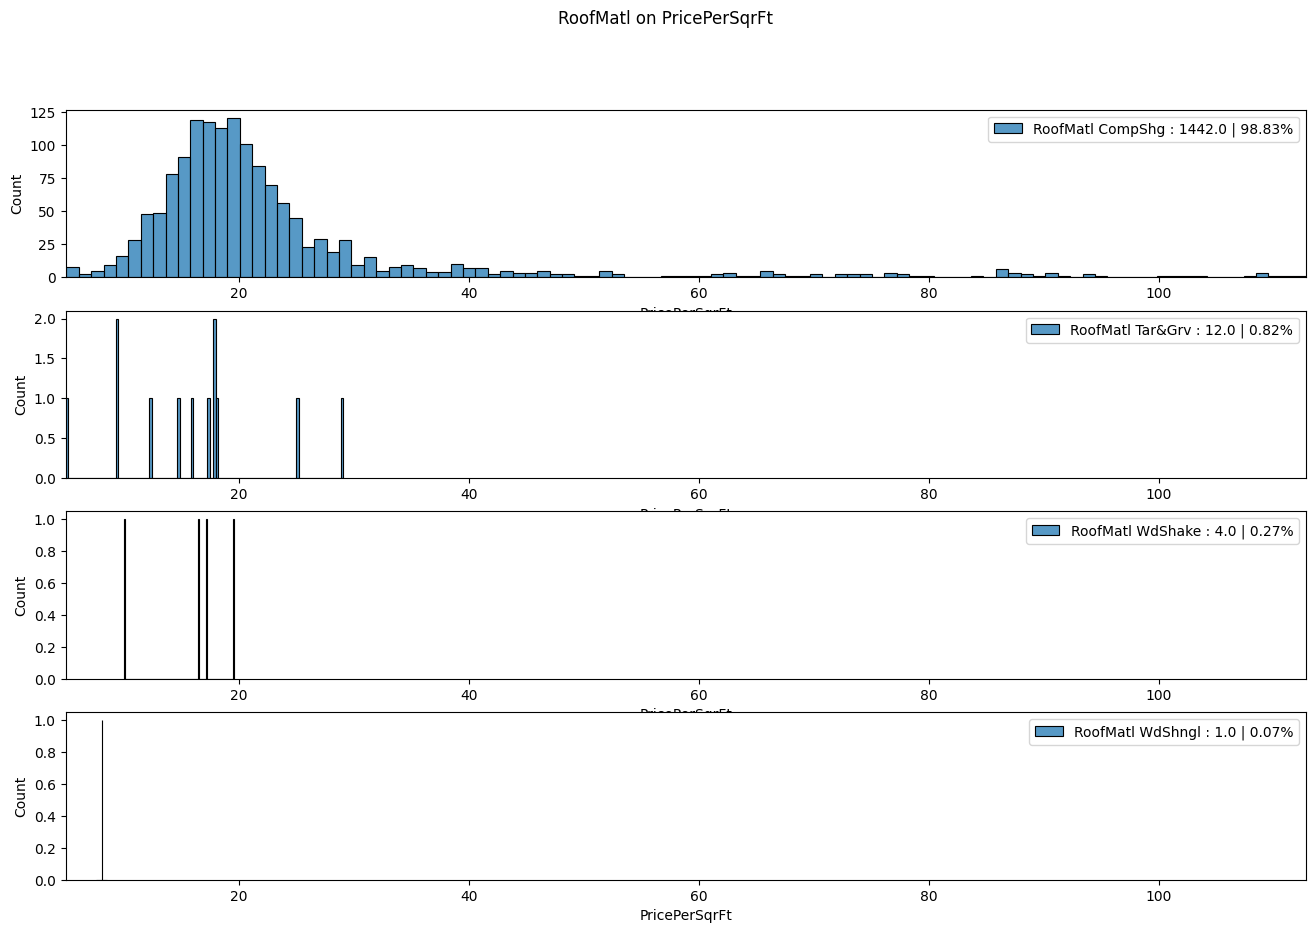

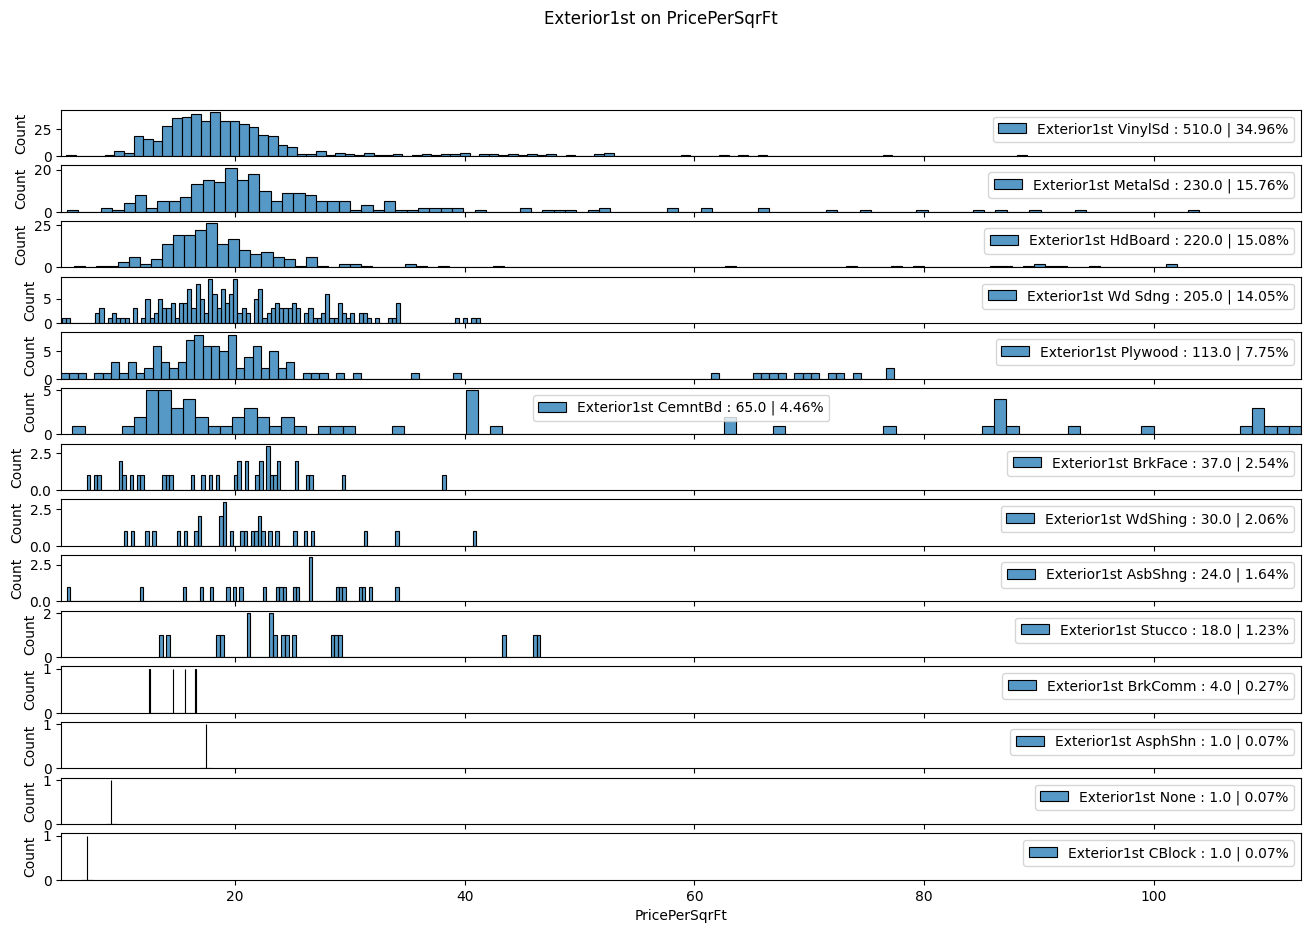

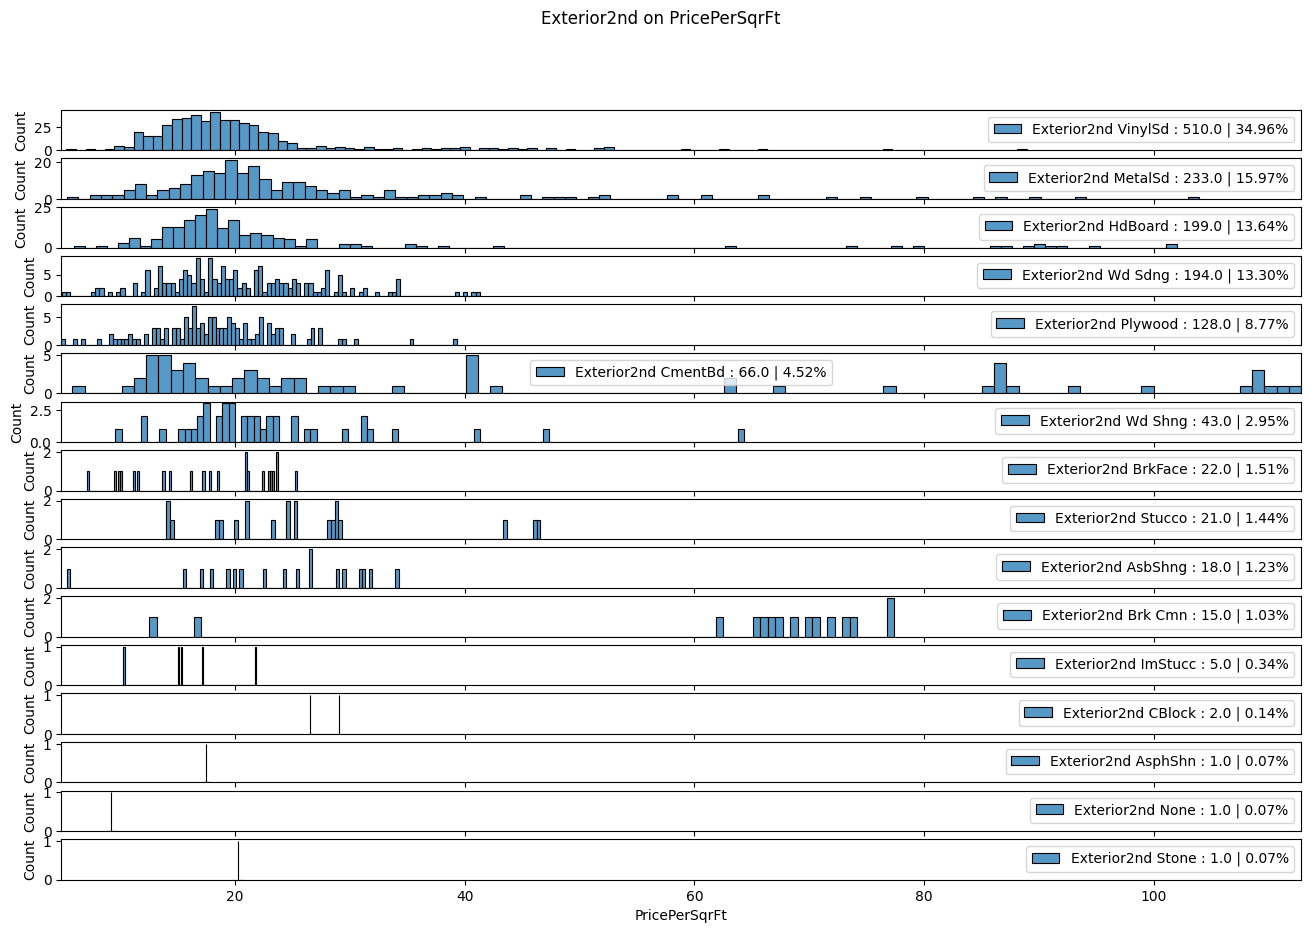

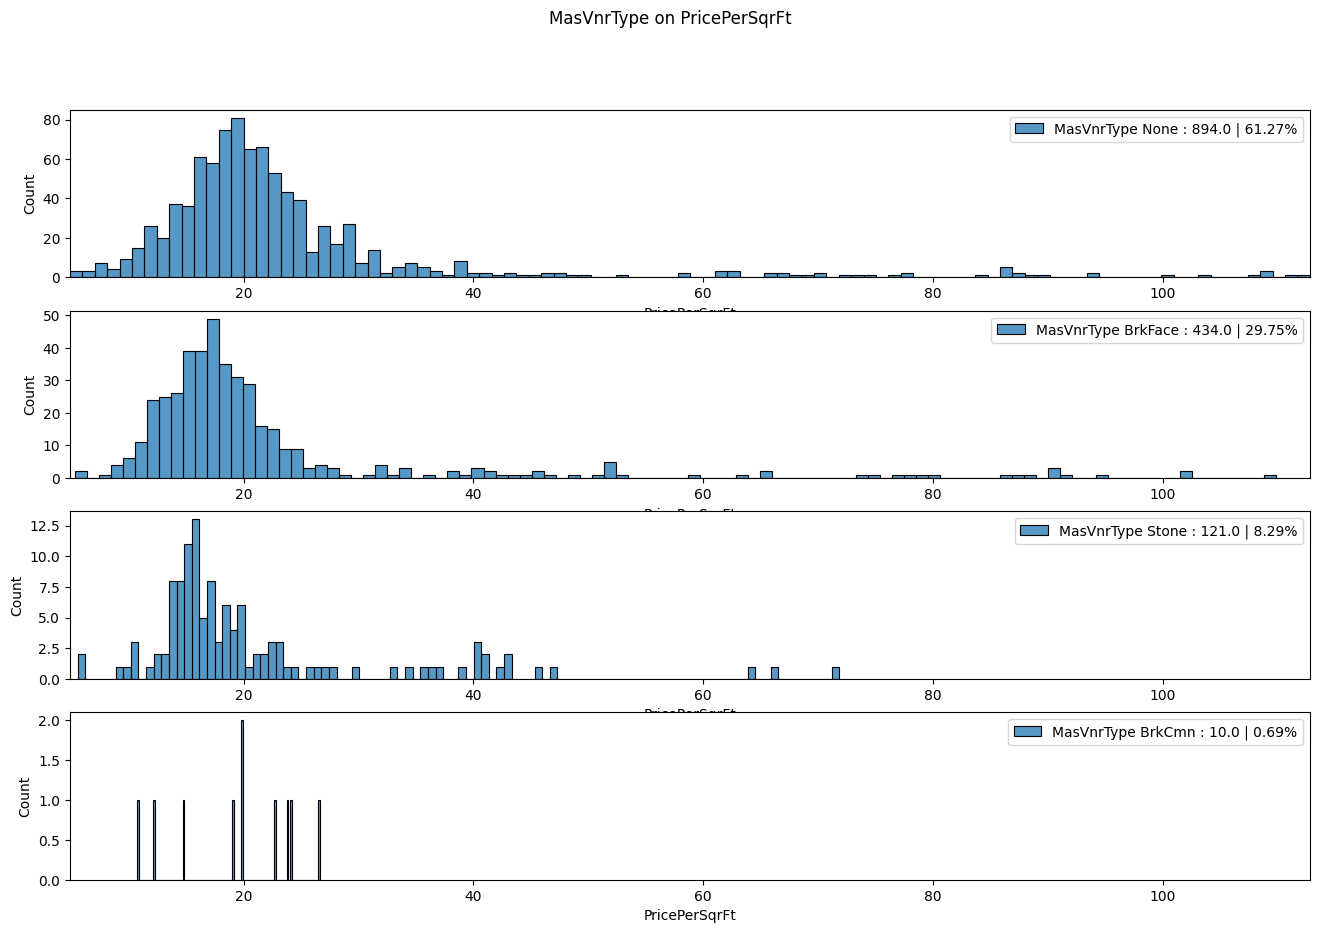

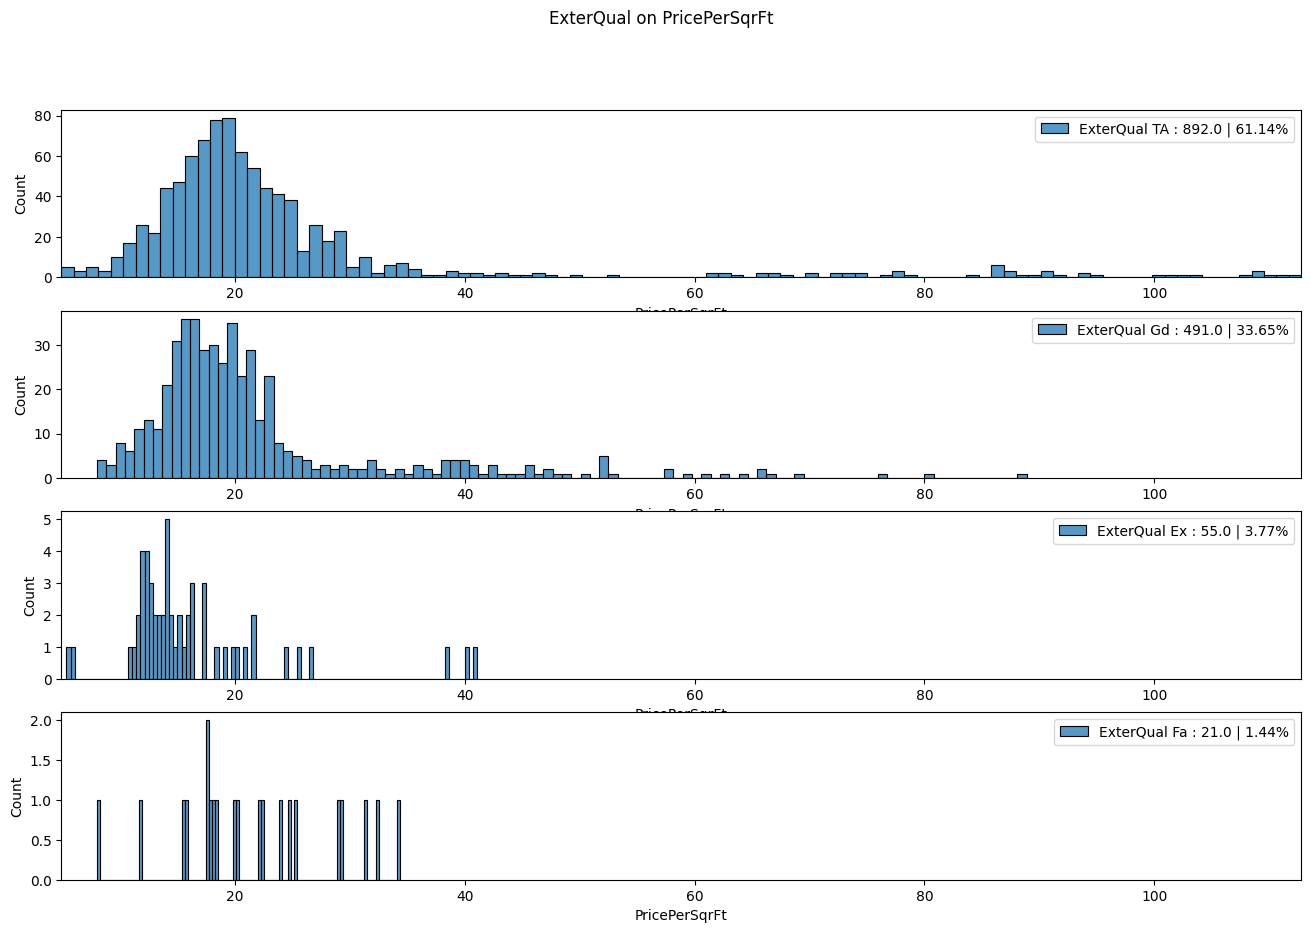

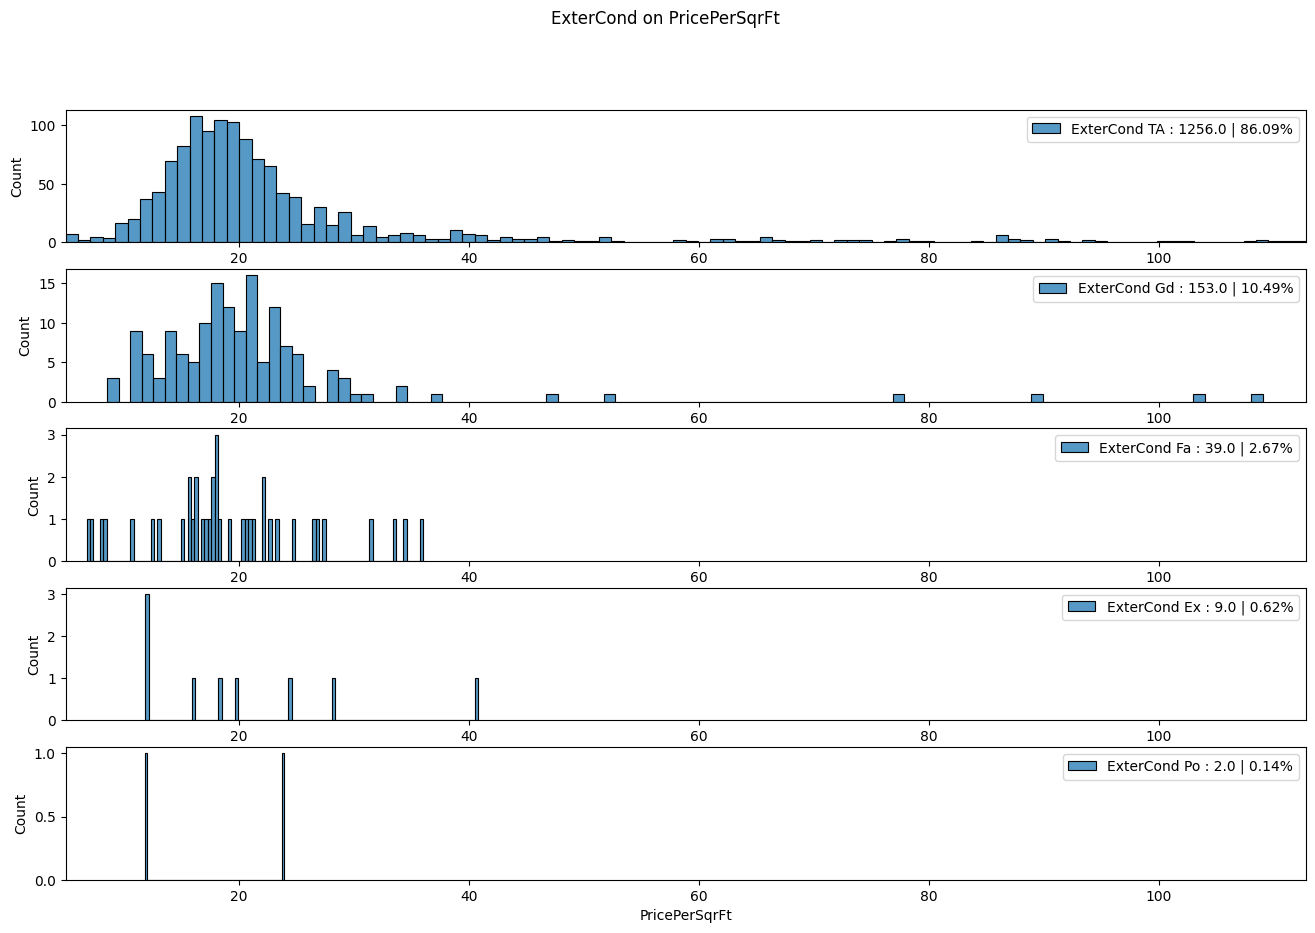

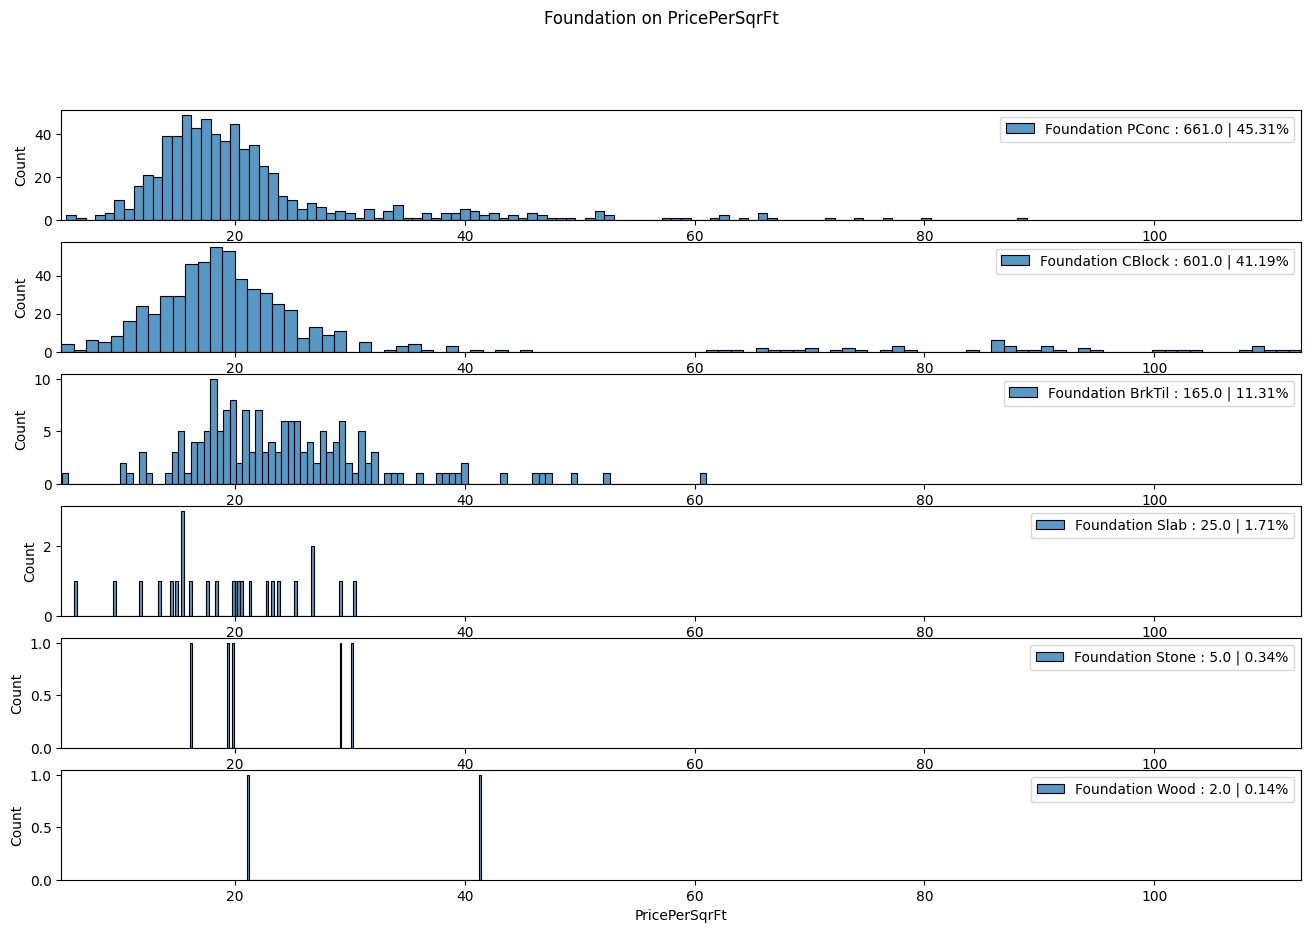

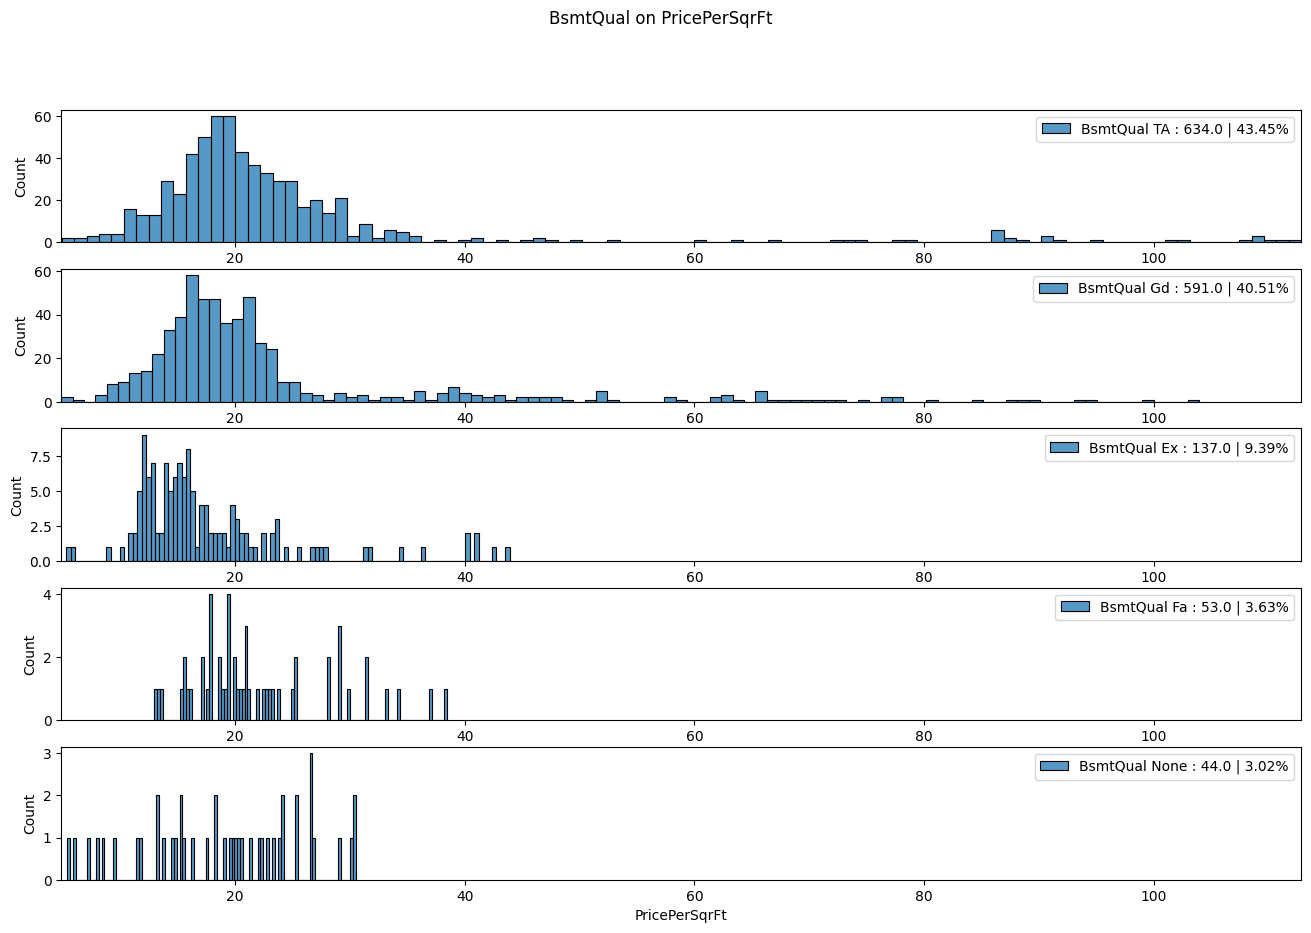

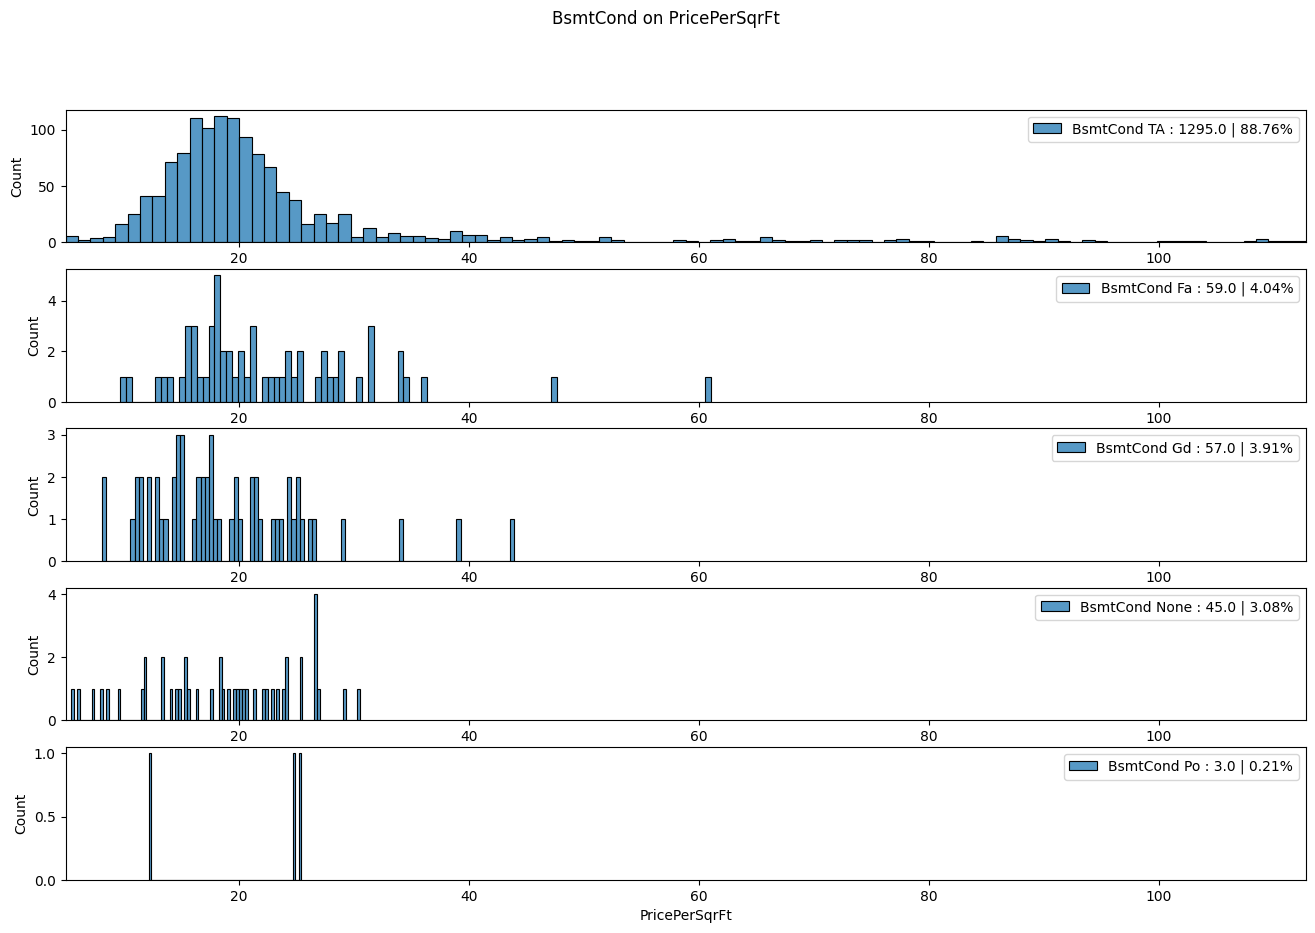

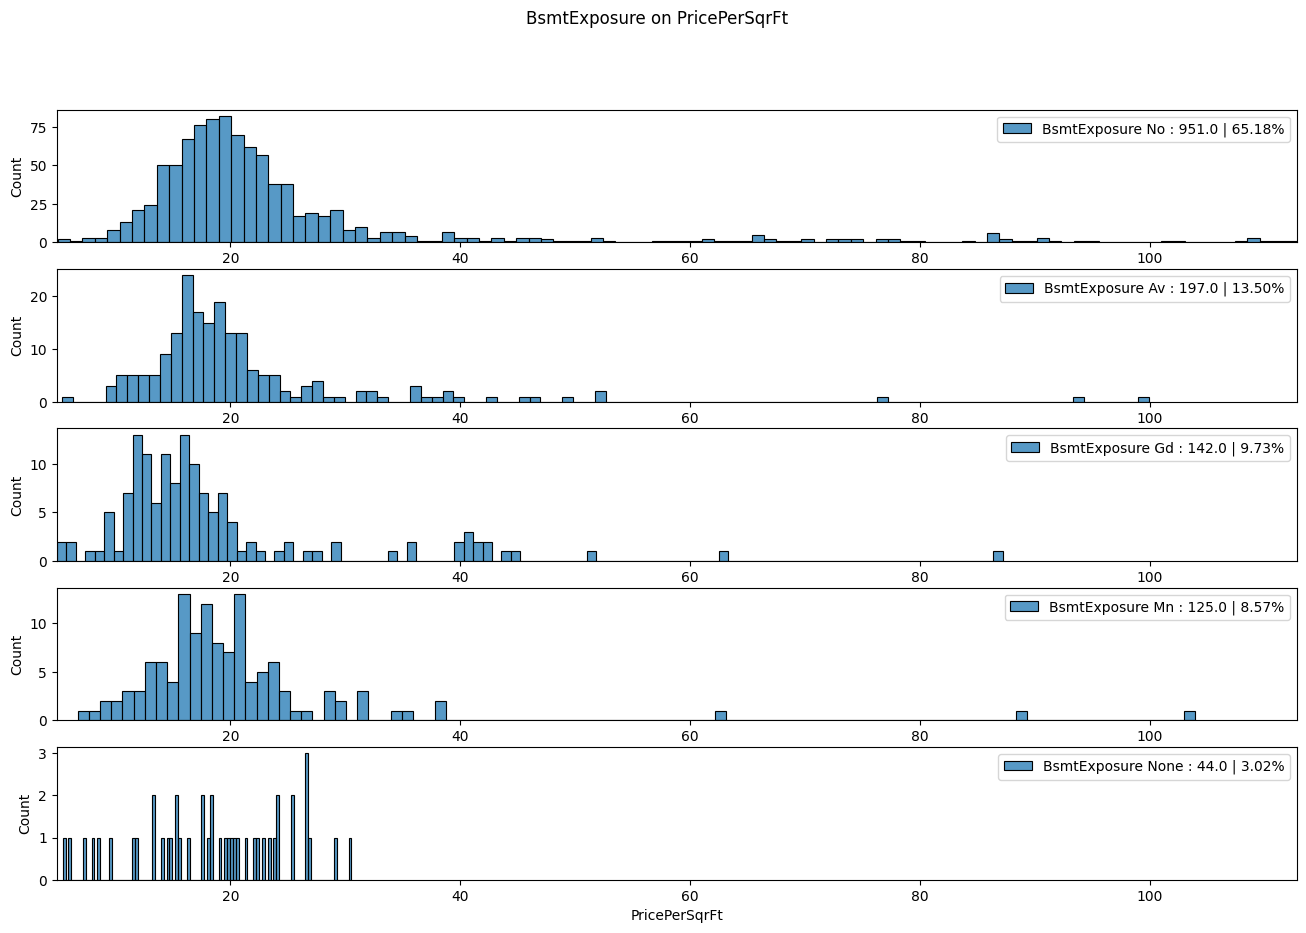

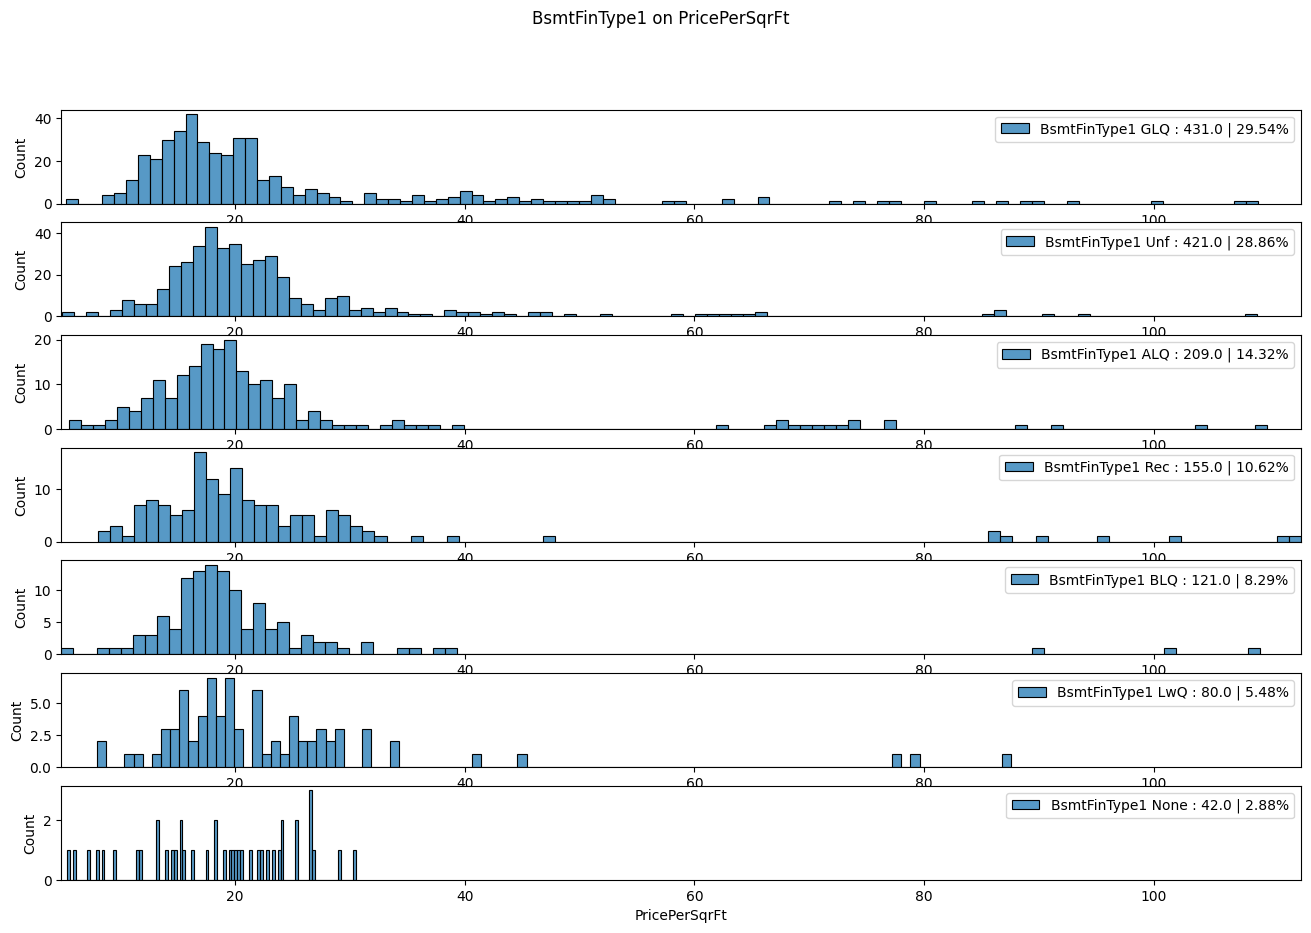

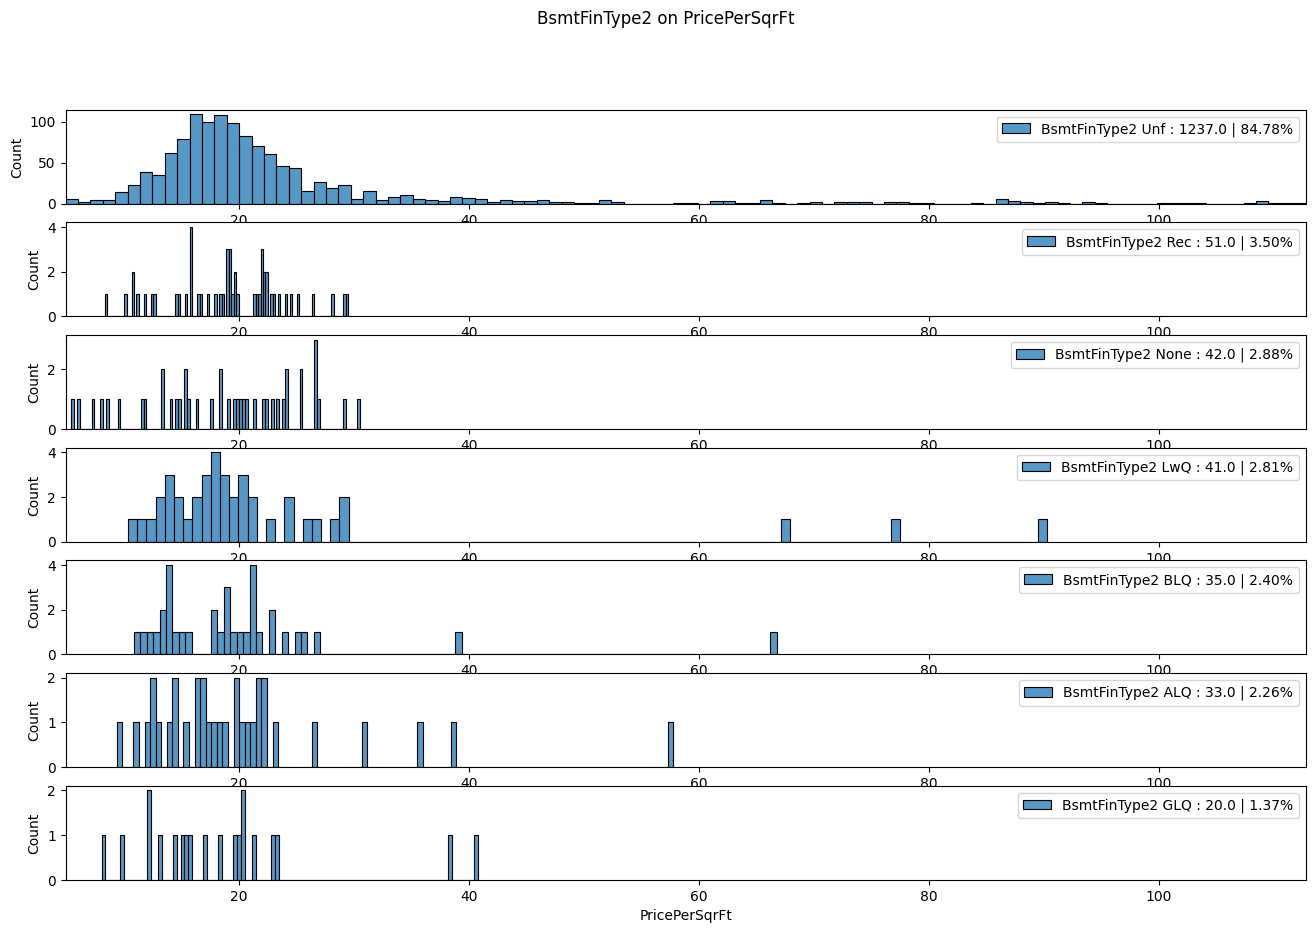

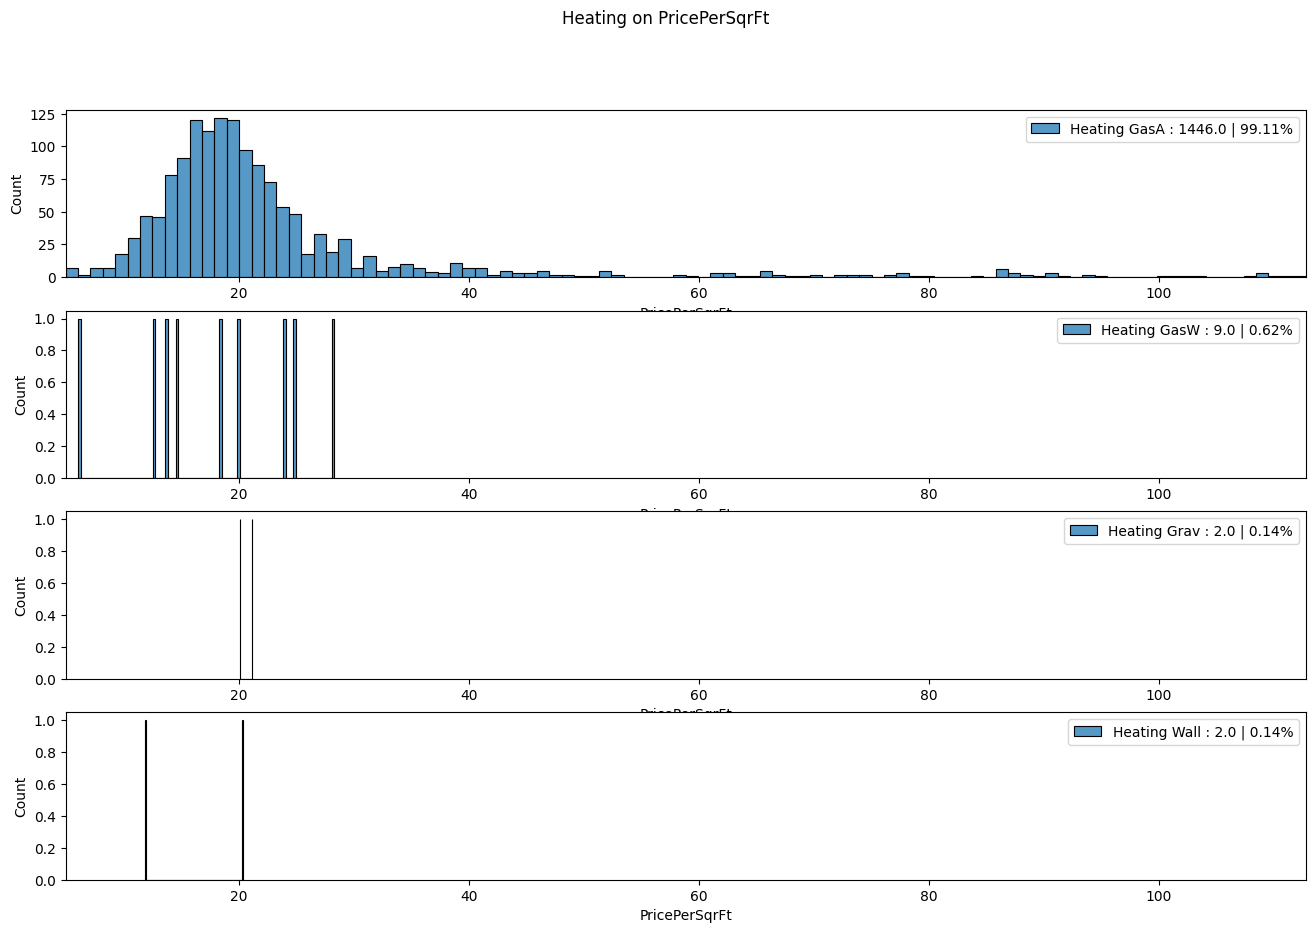

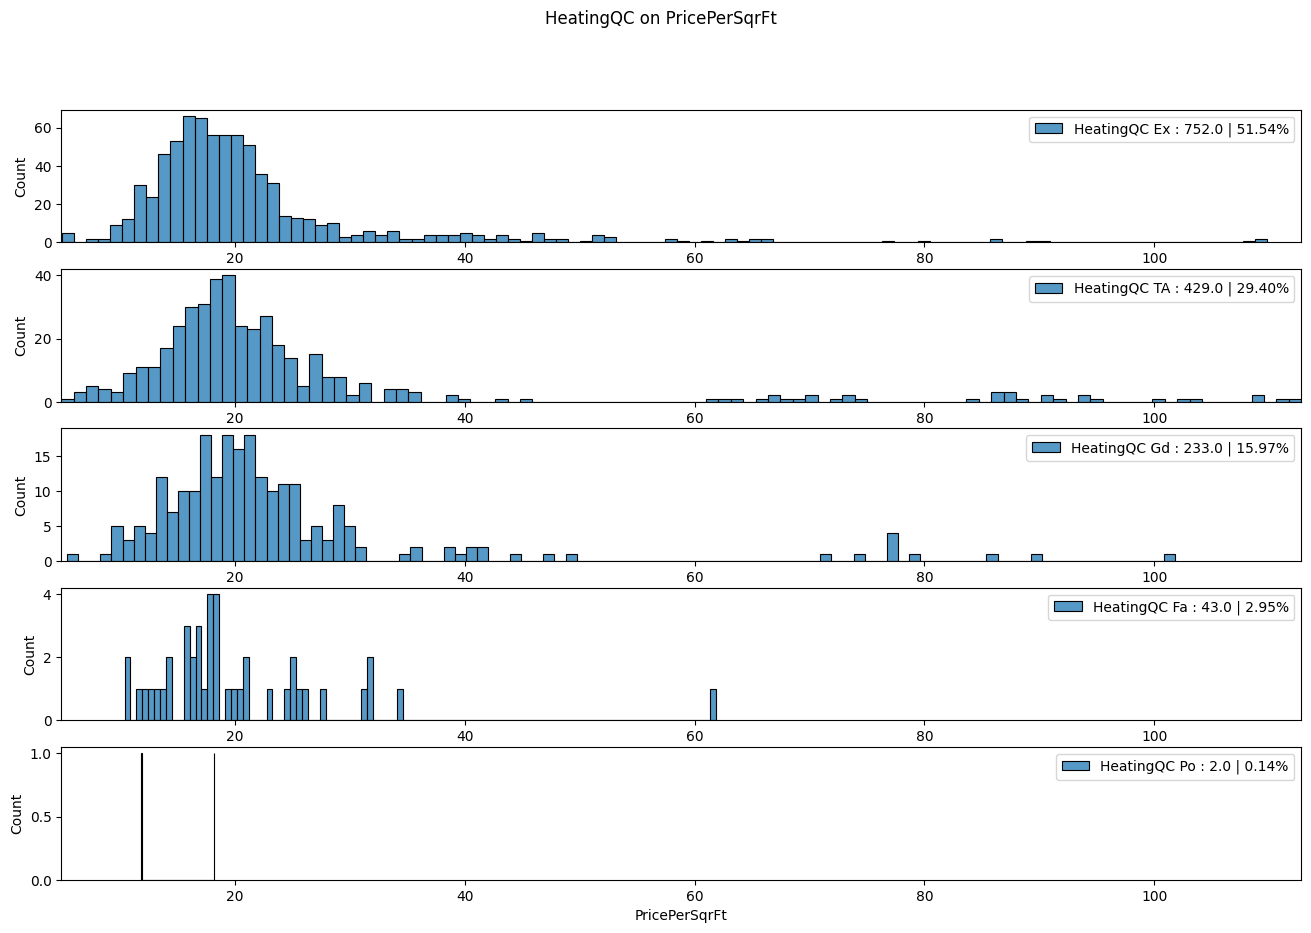

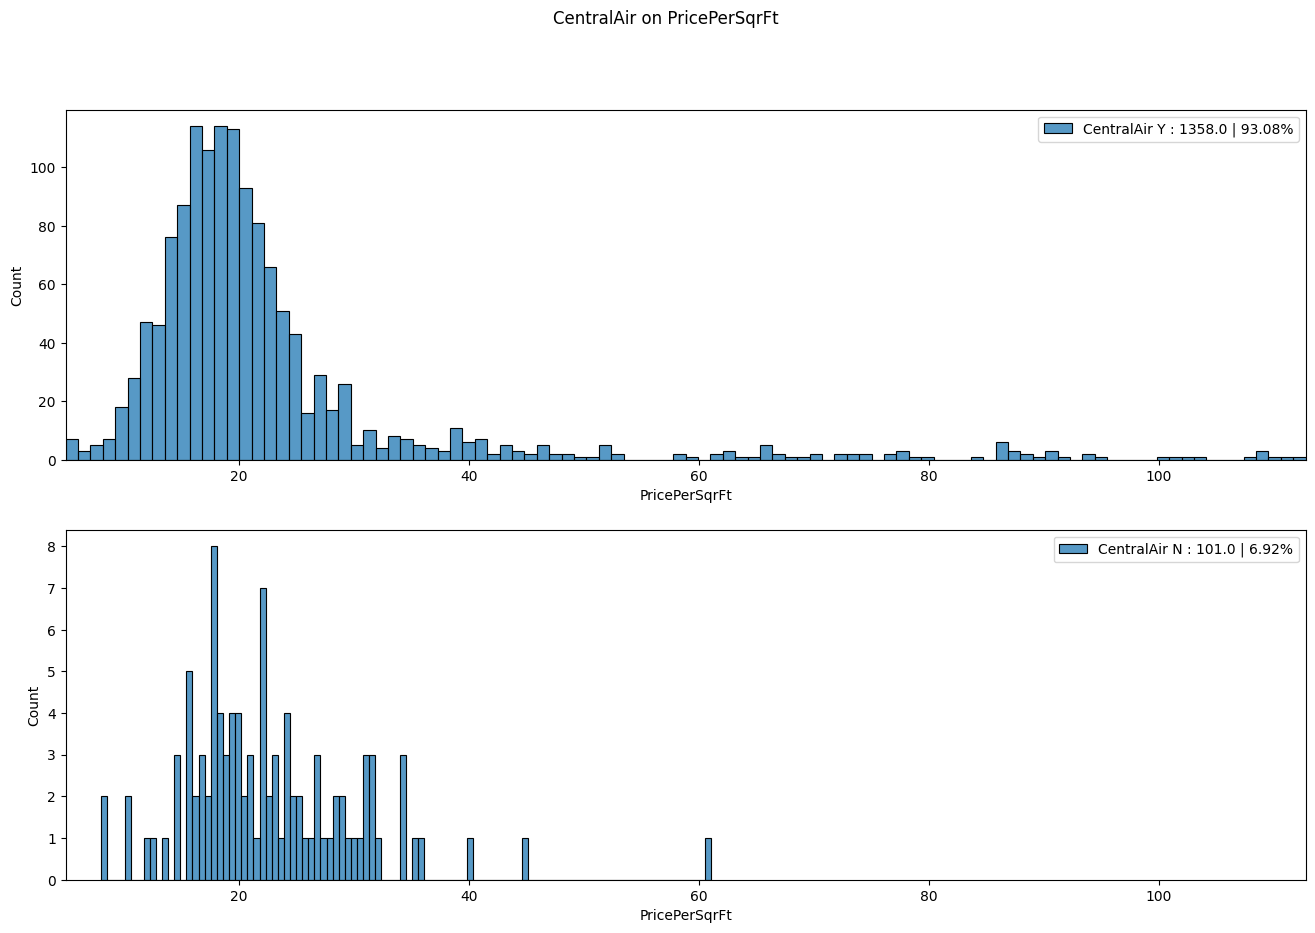

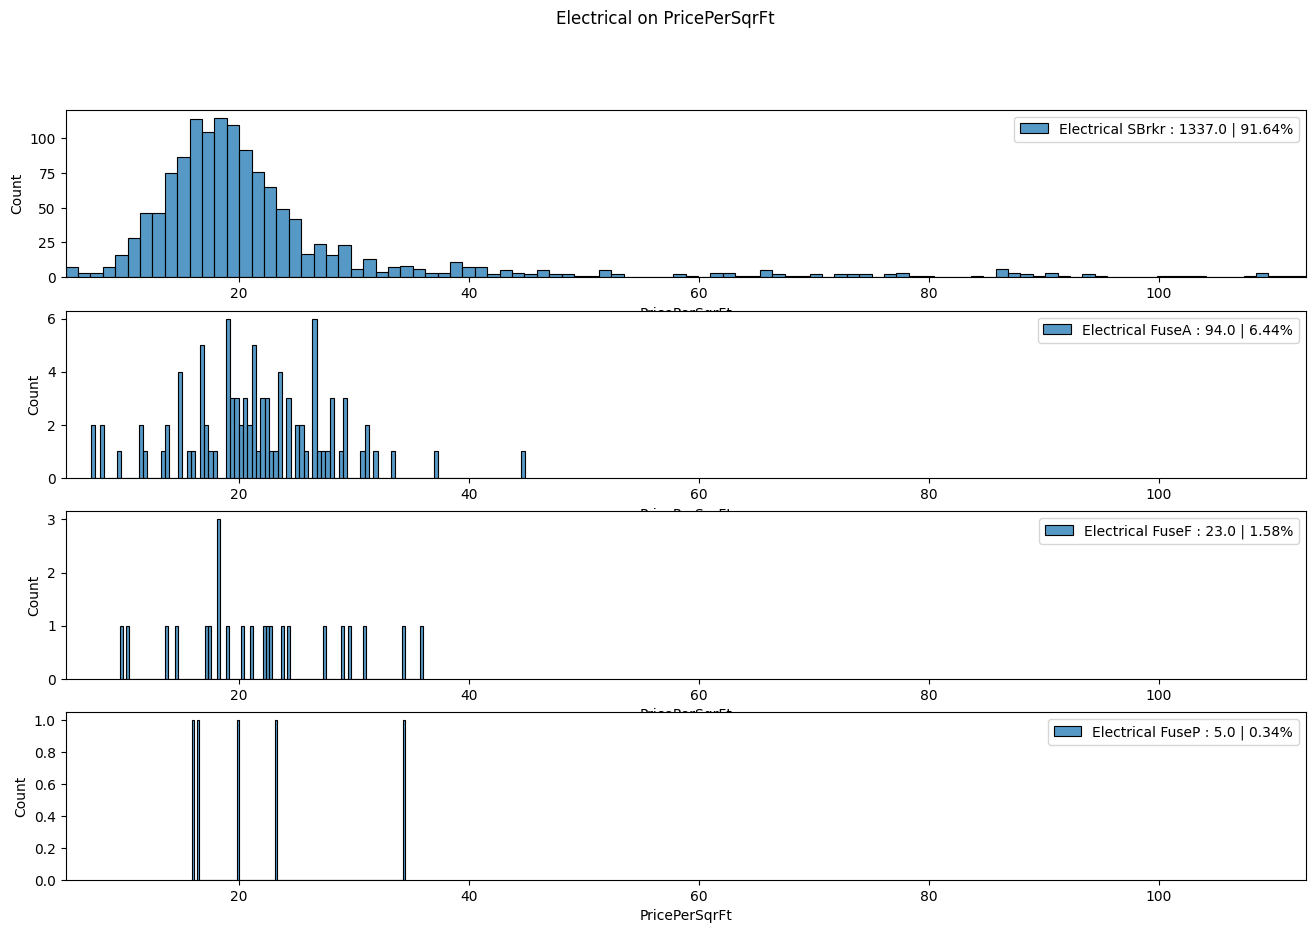

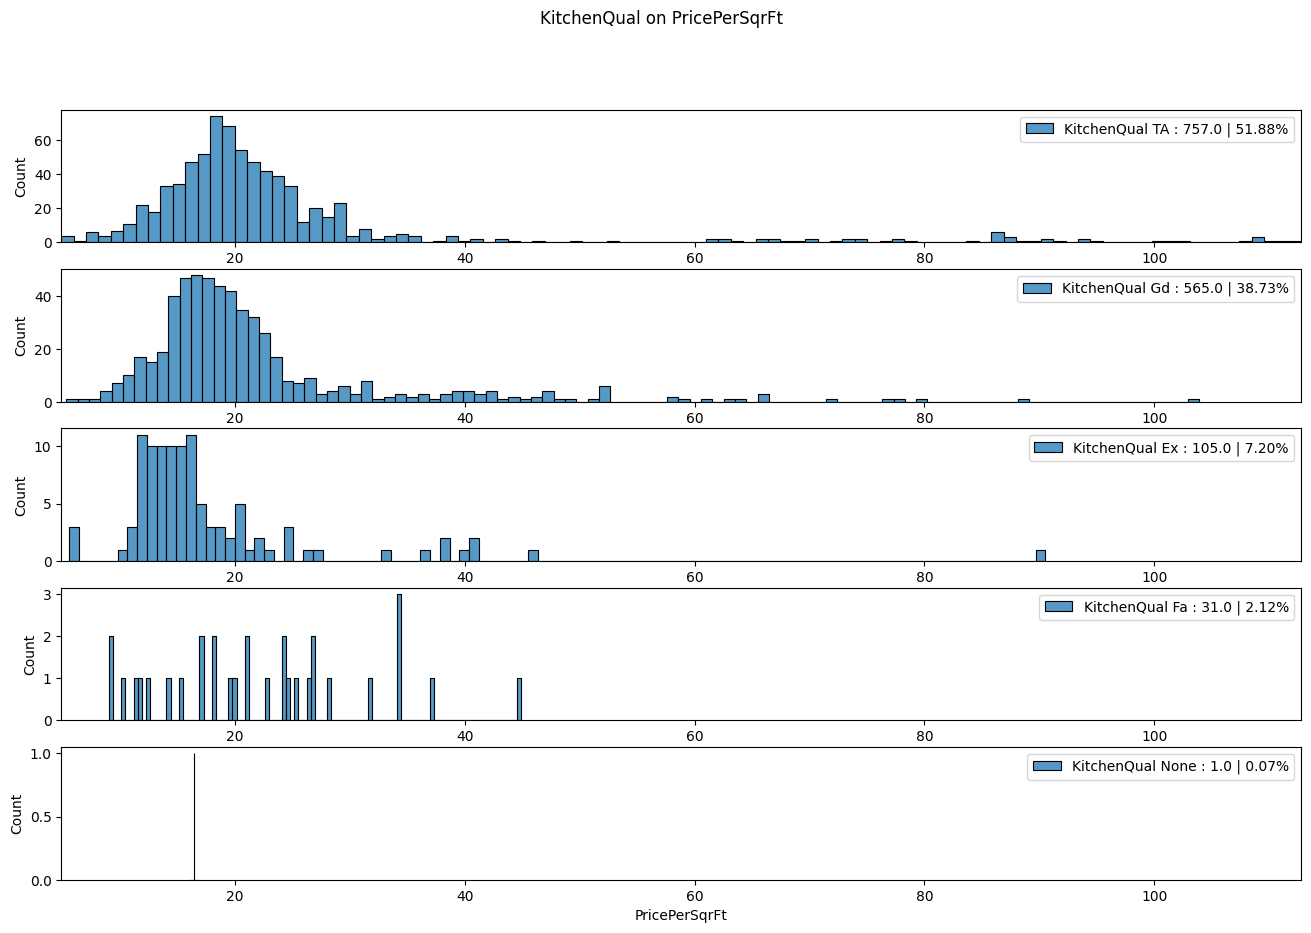

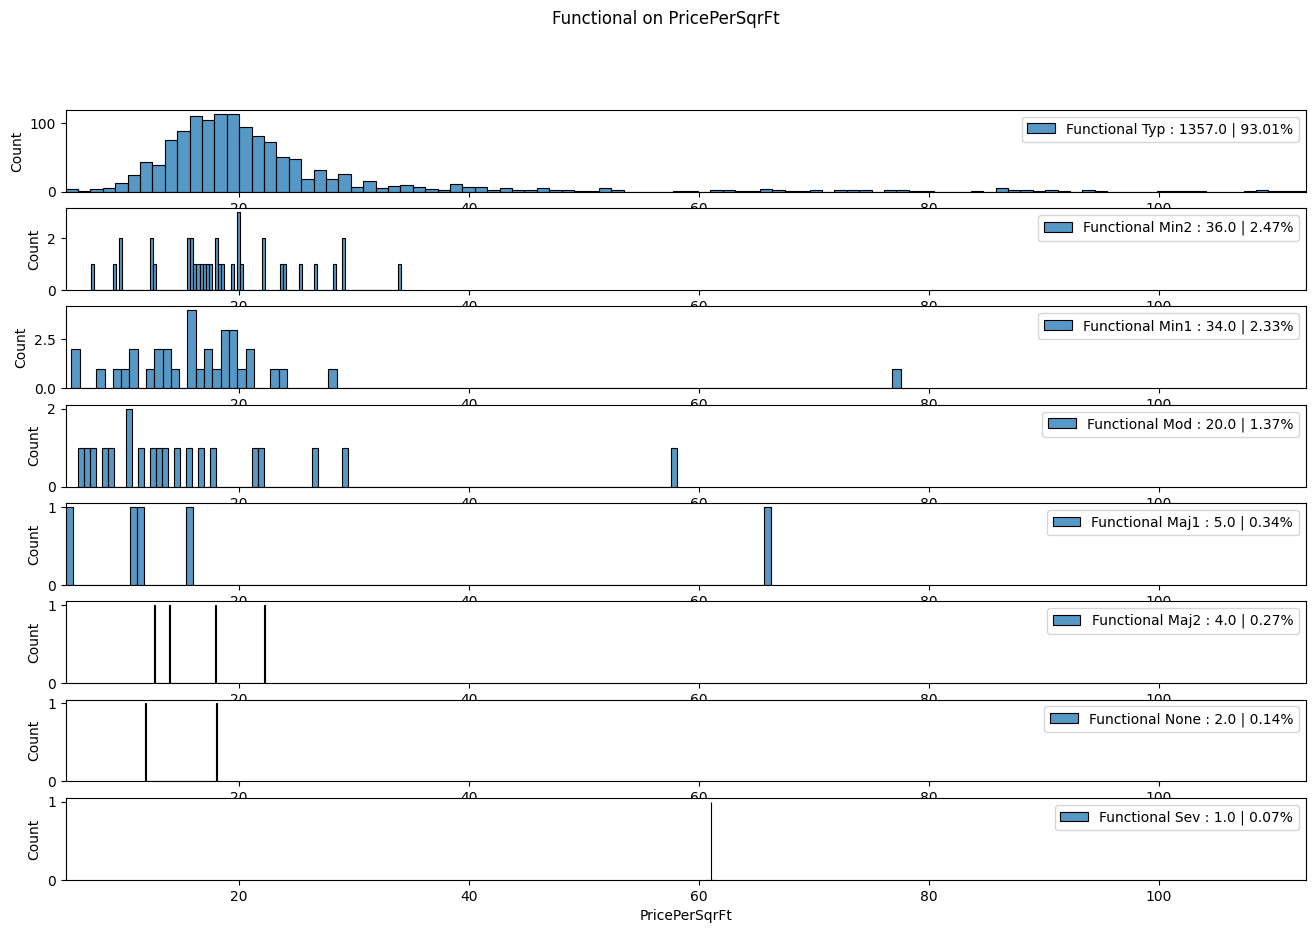

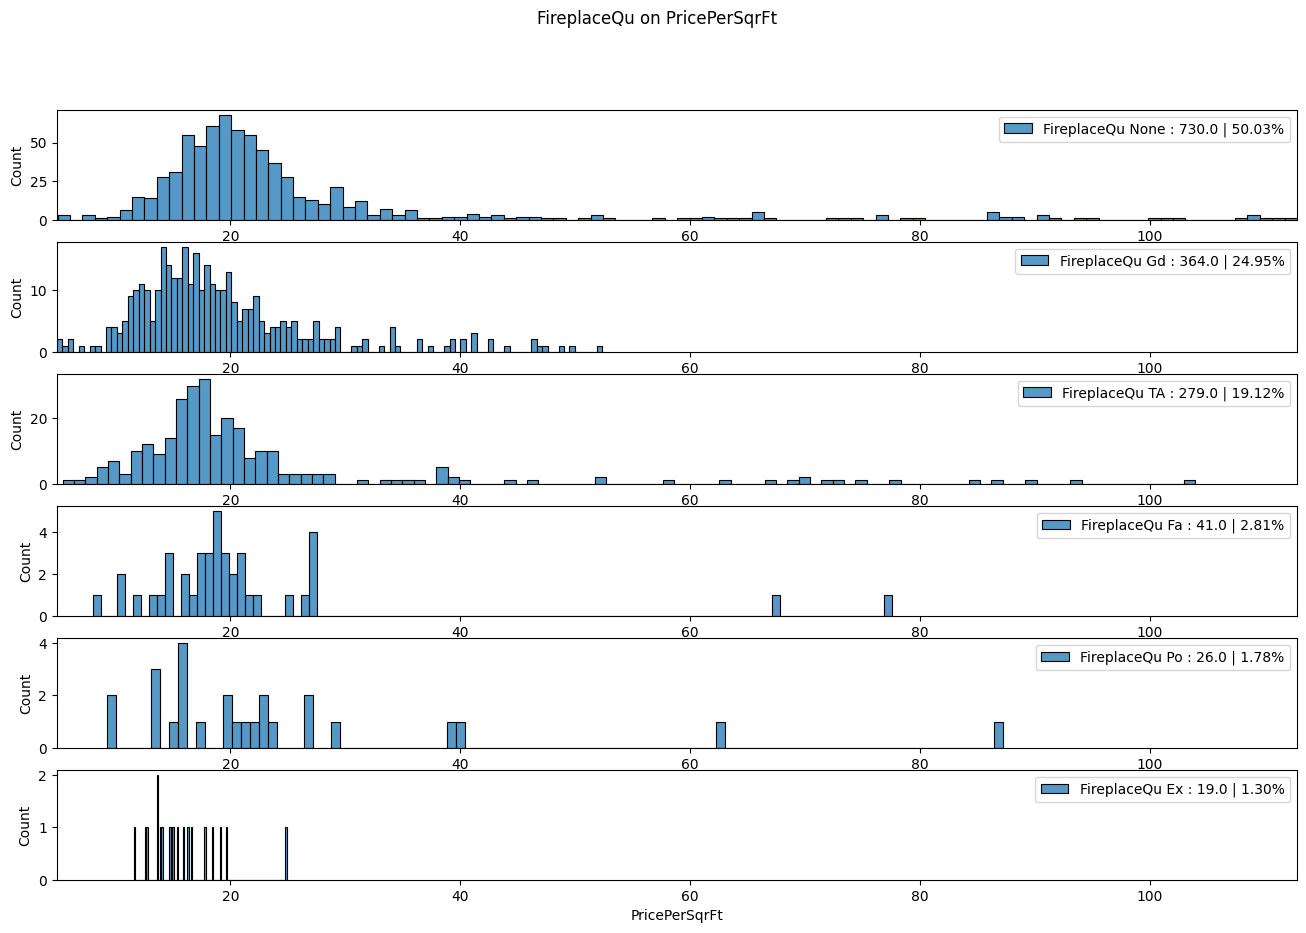

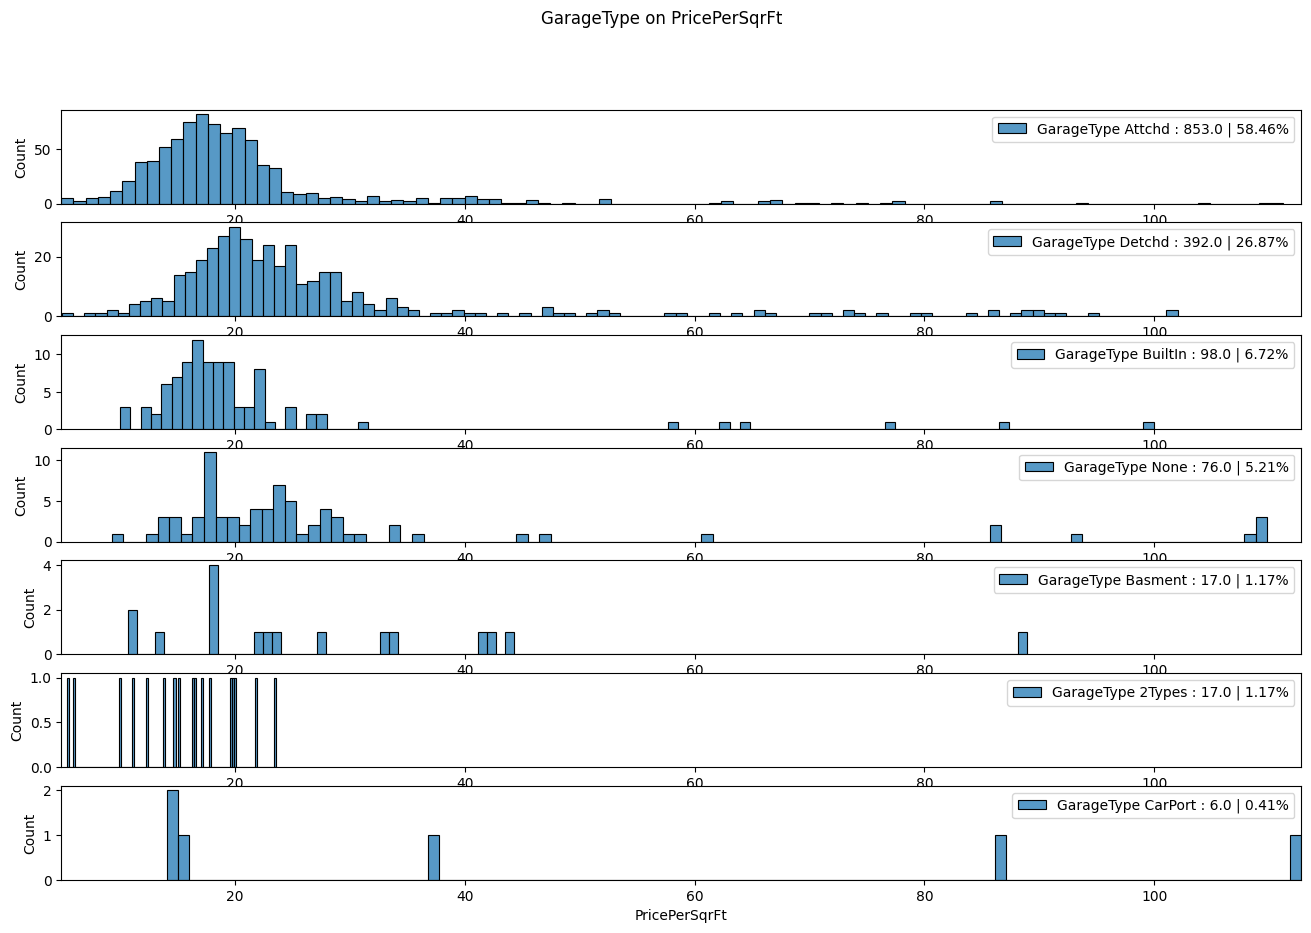

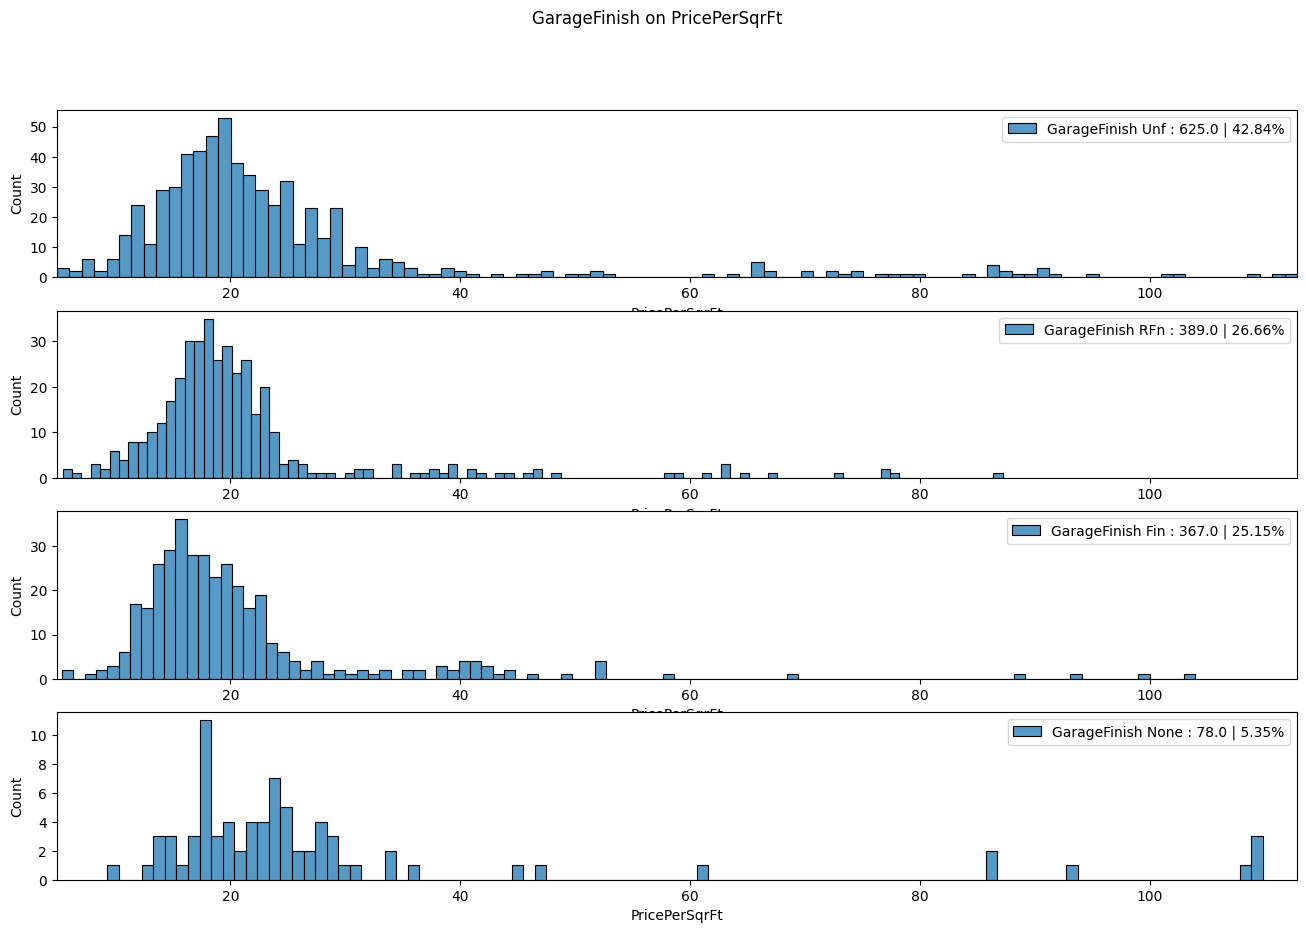

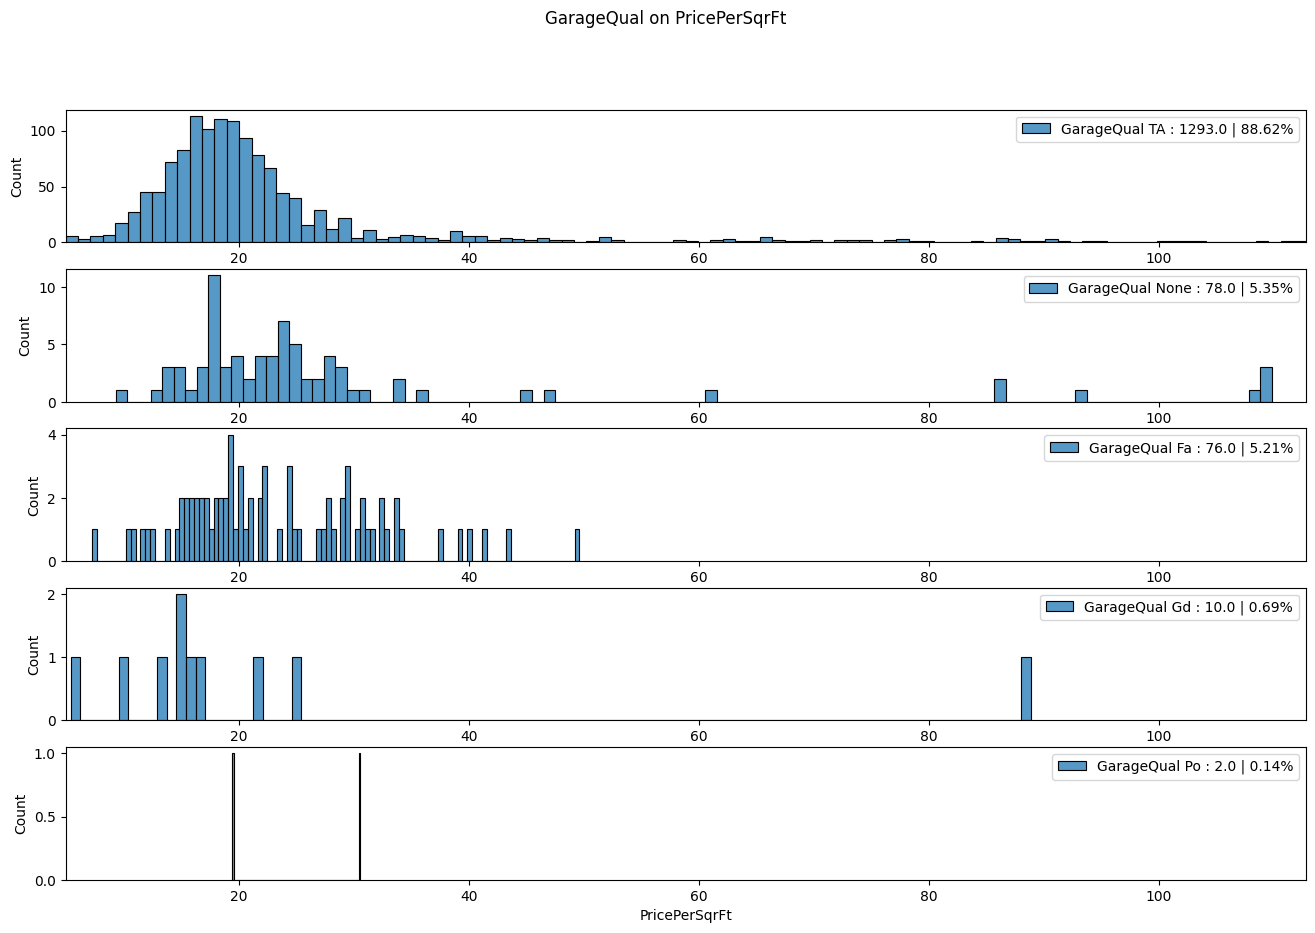

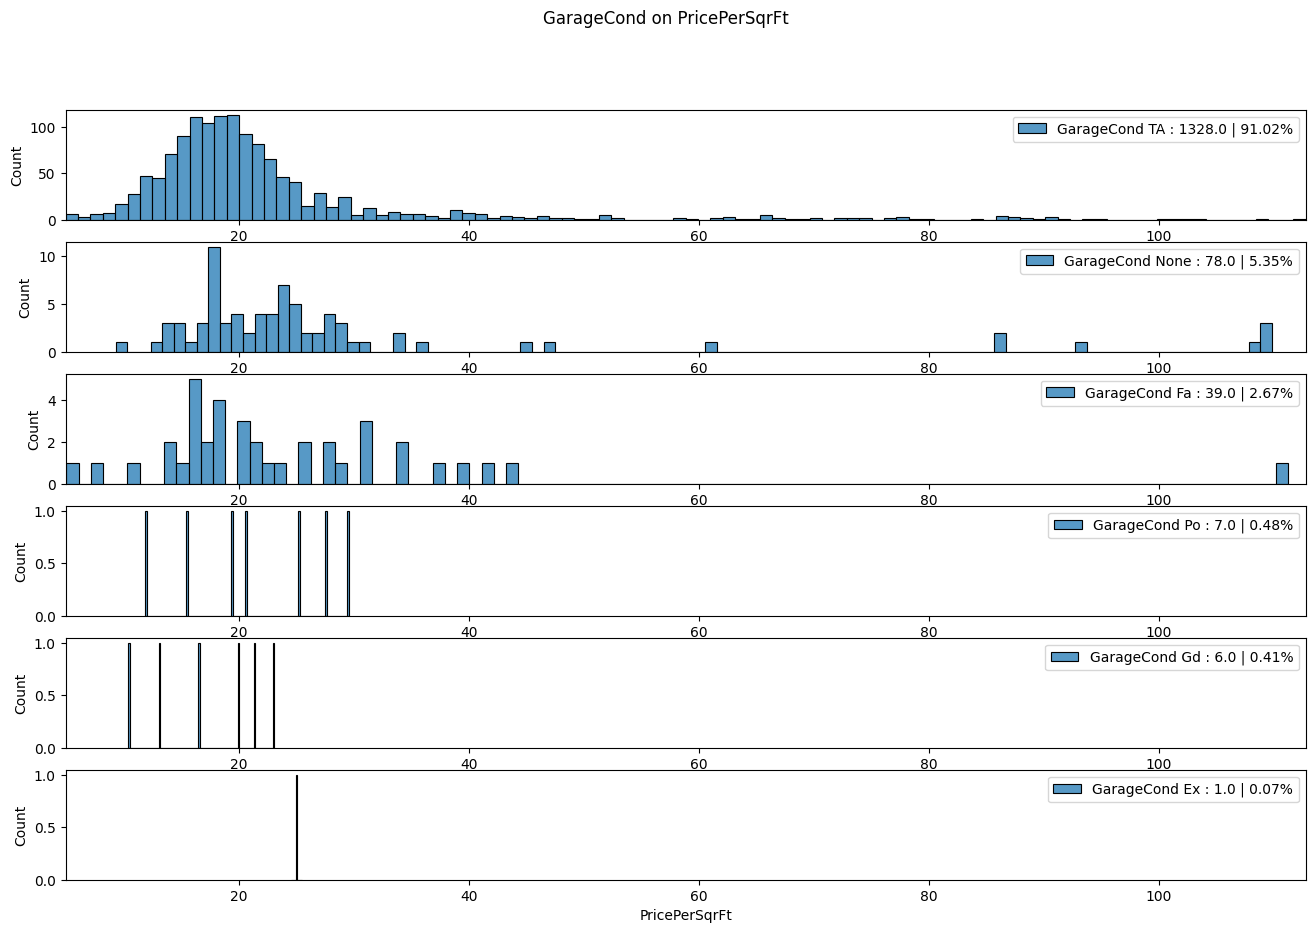

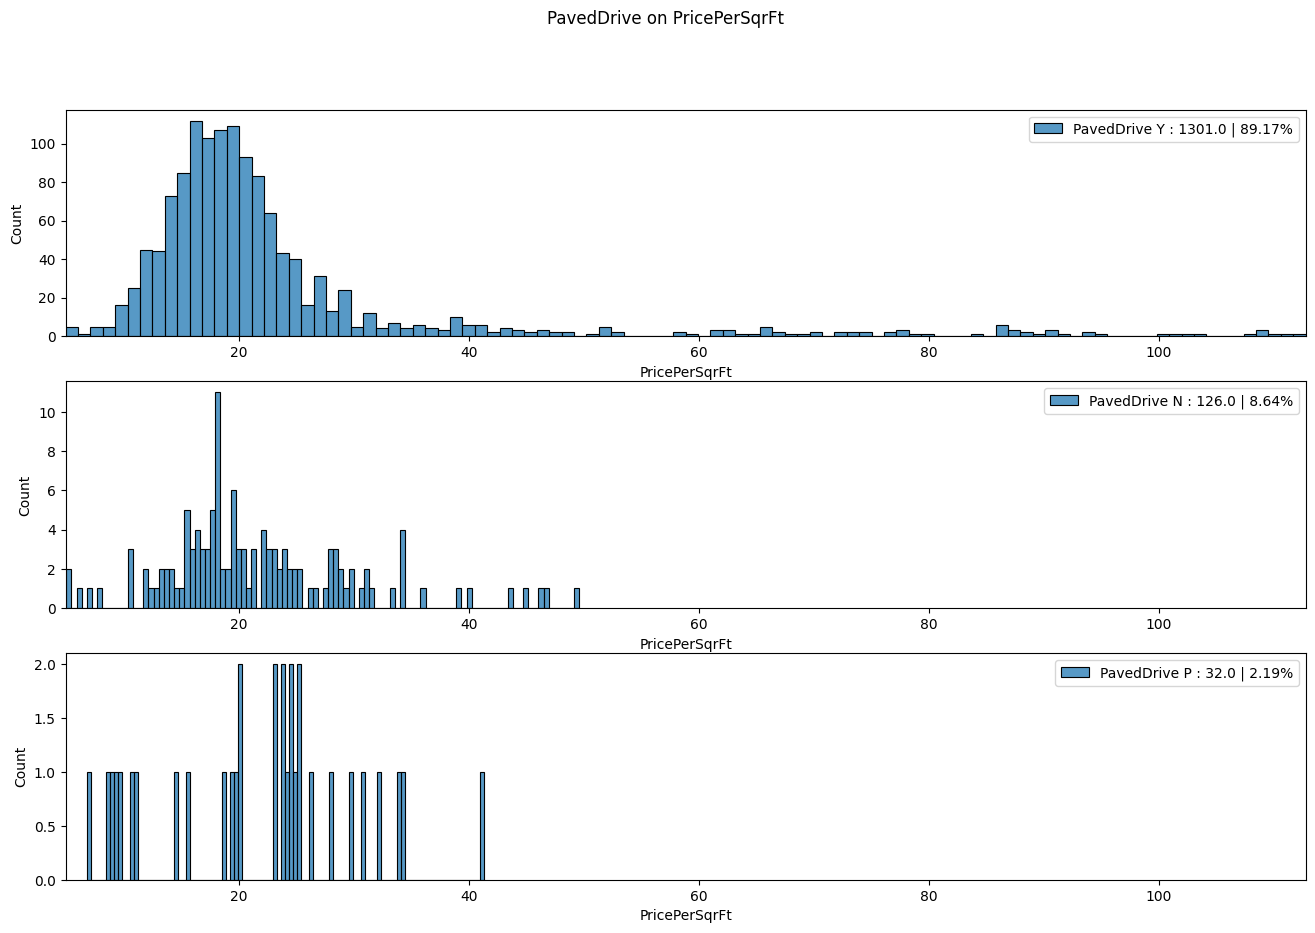

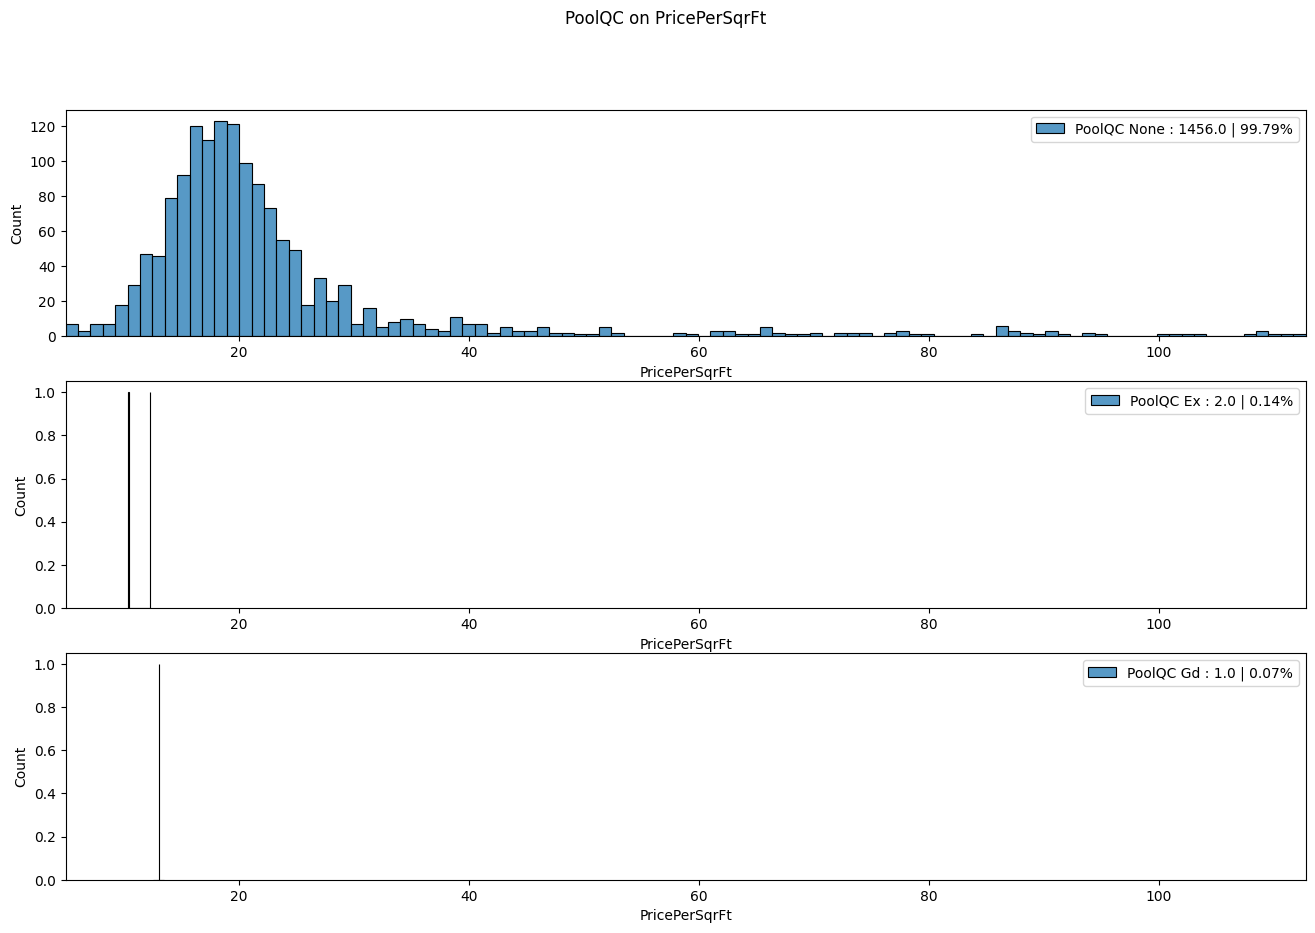

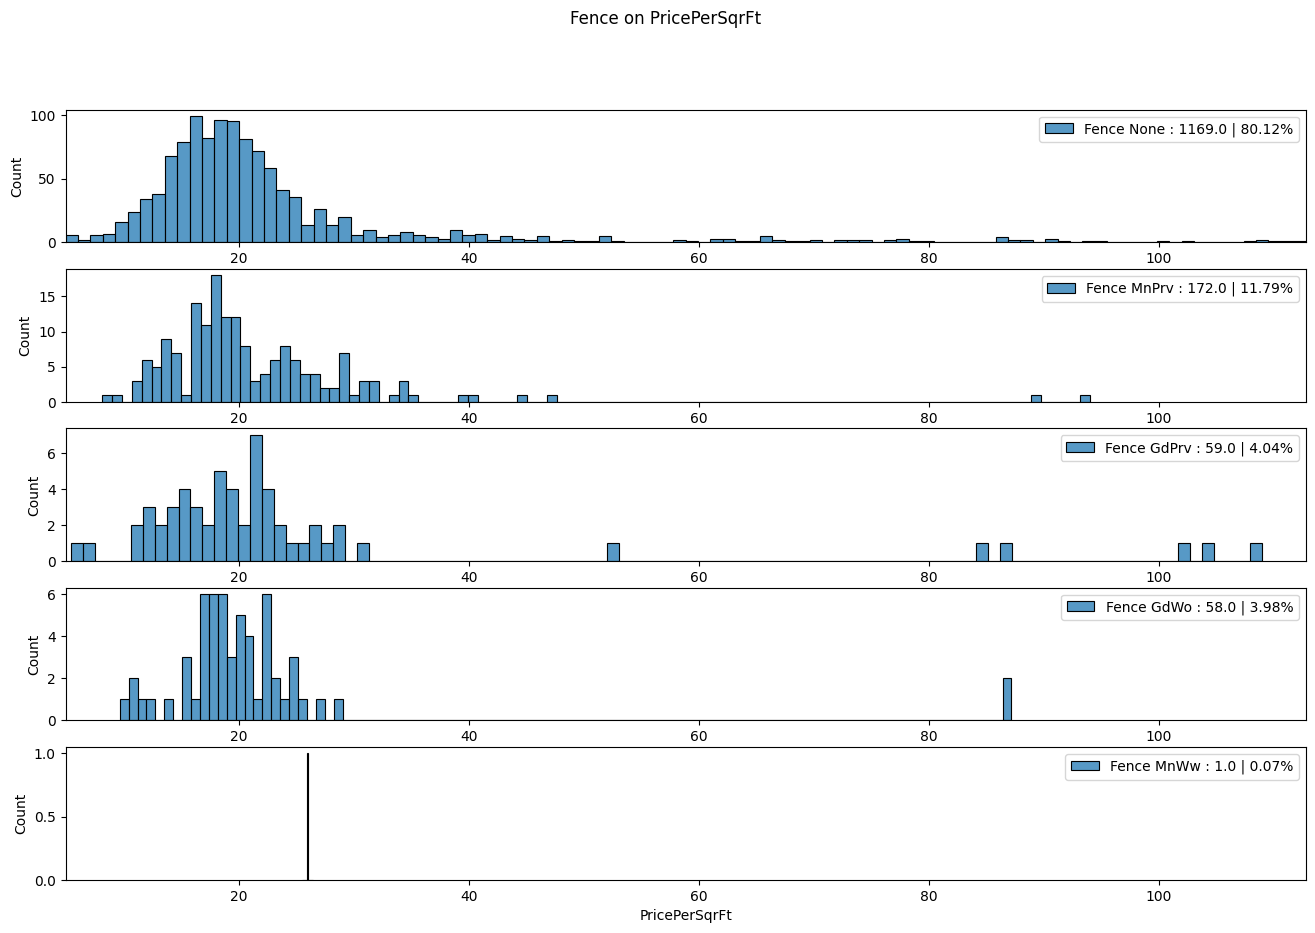

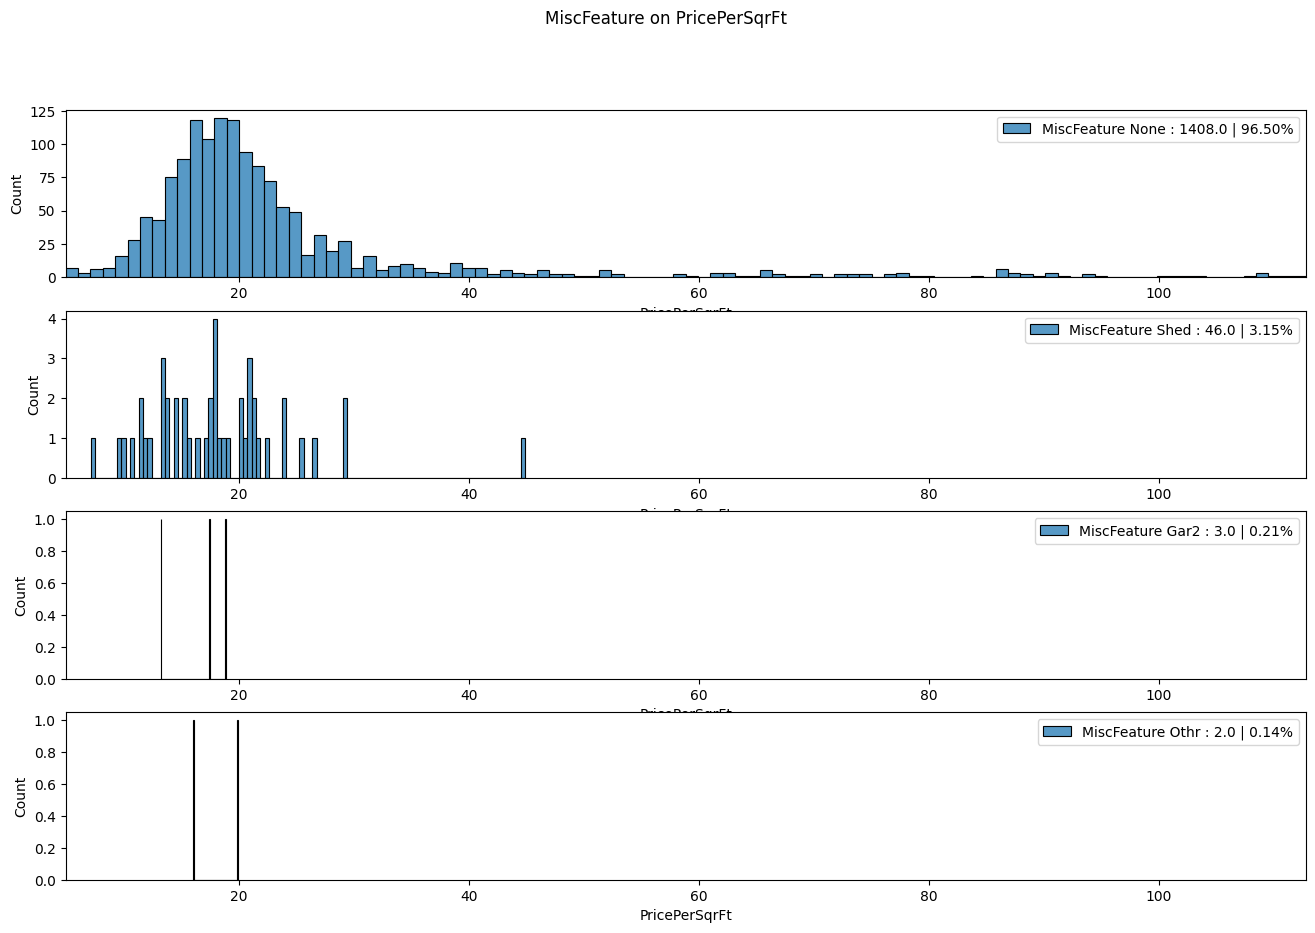

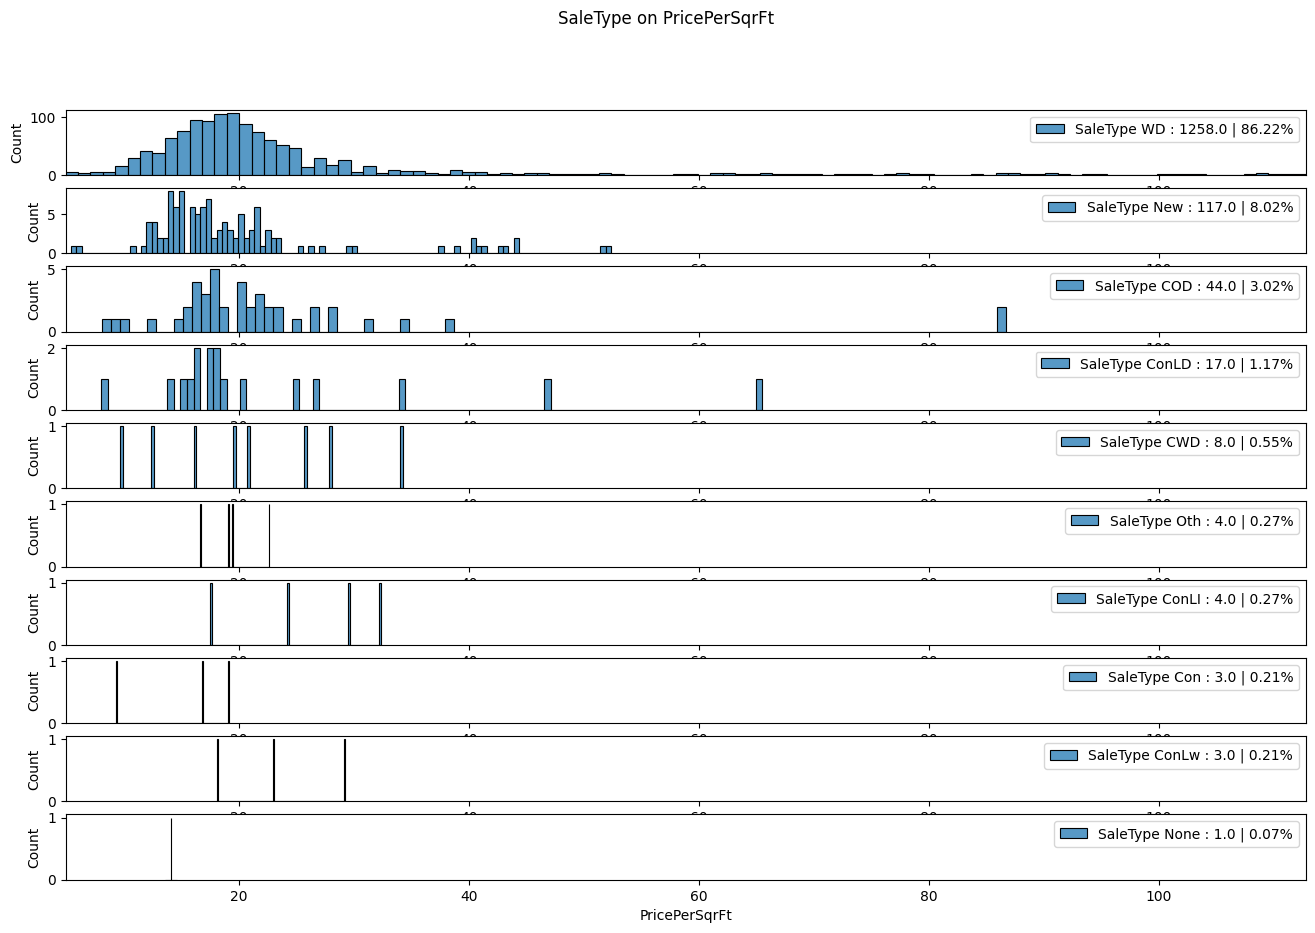

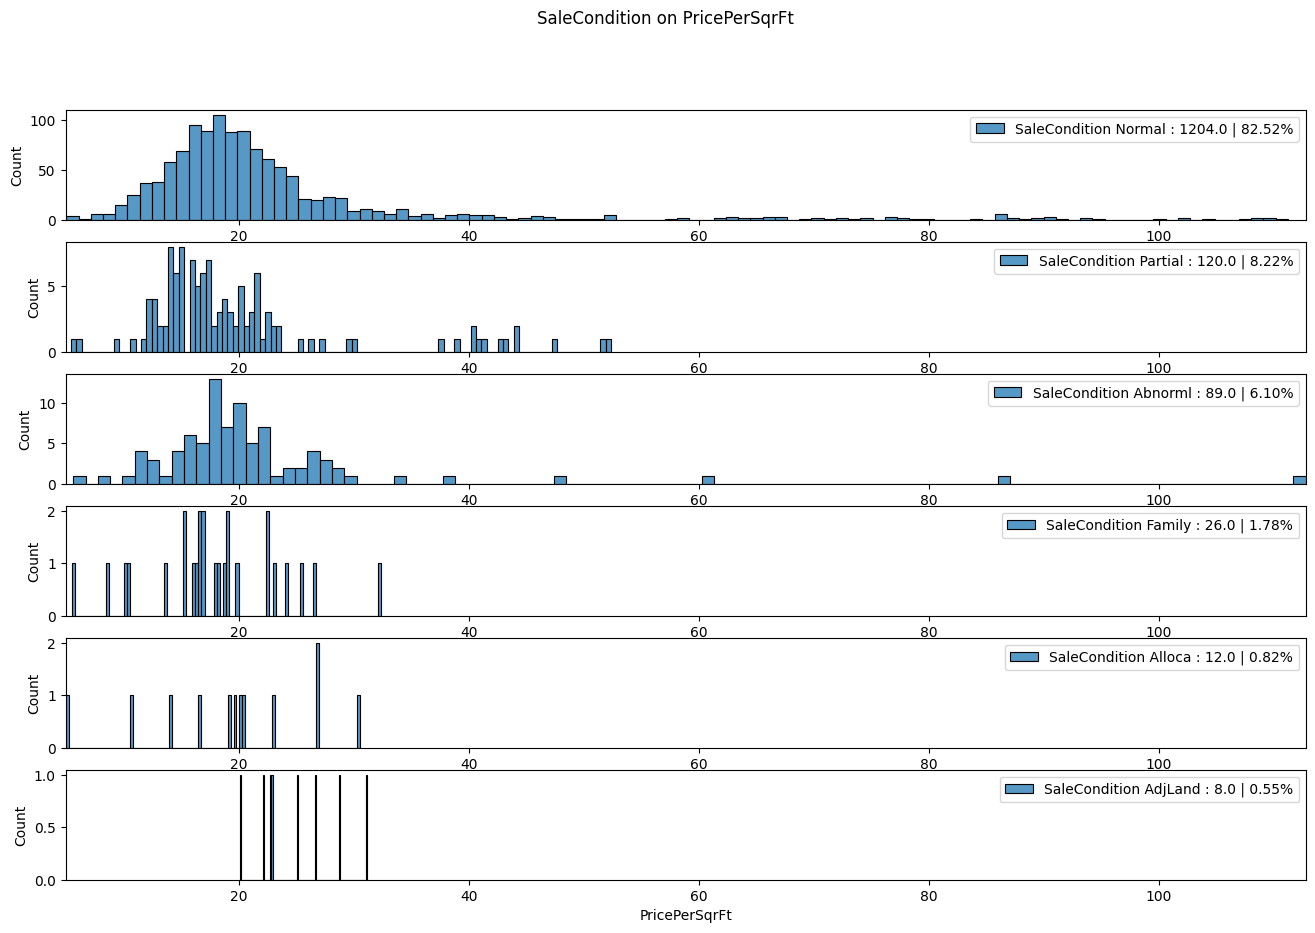

In [27]:
number_cols = get_data_type(test_data_csv, PDataType.CATHEGORICAL).head()
print(number_cols.columns.to_numpy())
plot_hist_for_unique_category_array(test_data_csv, number_cols.columns.to_numpy(), 'PricePerSqrFt');

MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd


/home/mg/AI_Py_3_10/lib/python3.10/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


Fireplaces
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
SalePrice
PricePerSqrFt


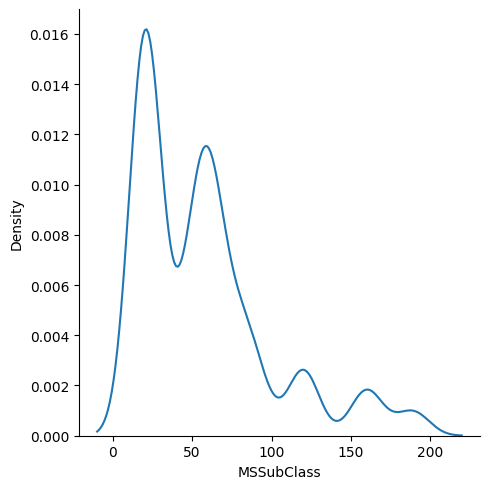

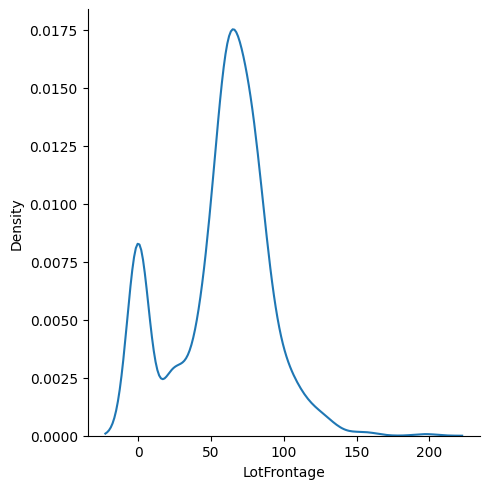

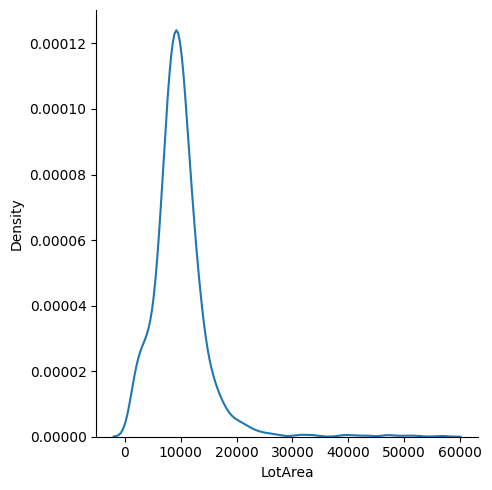

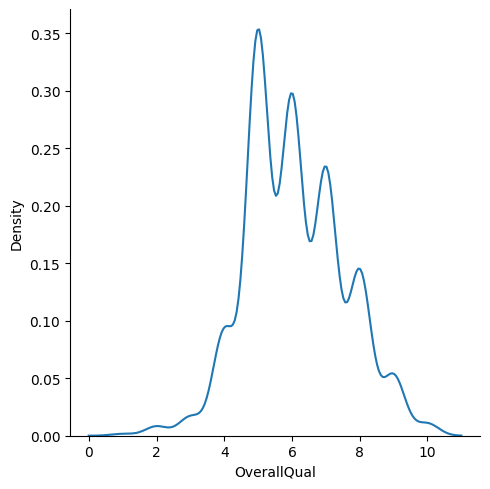

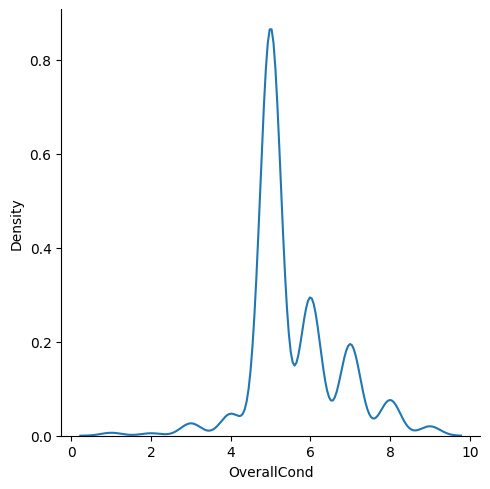

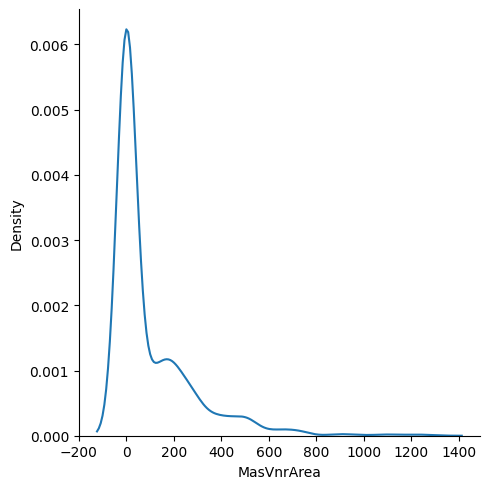

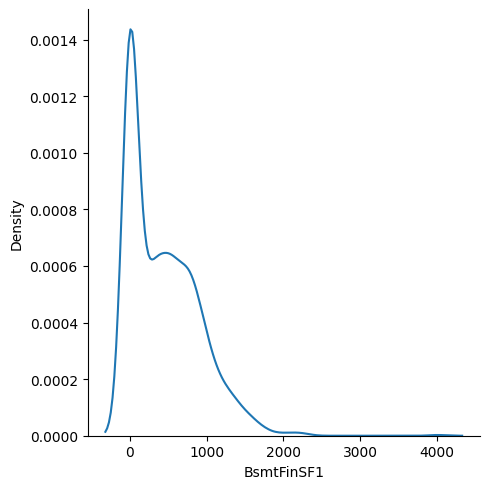

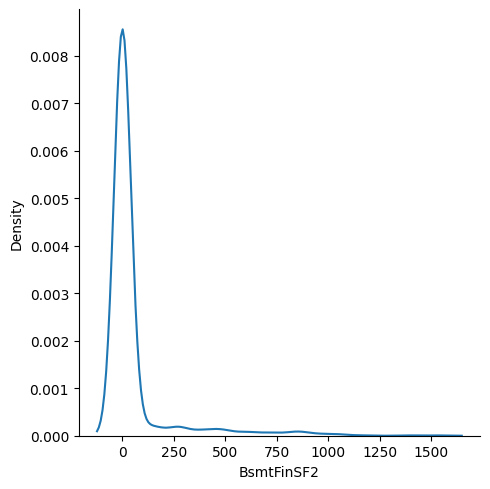

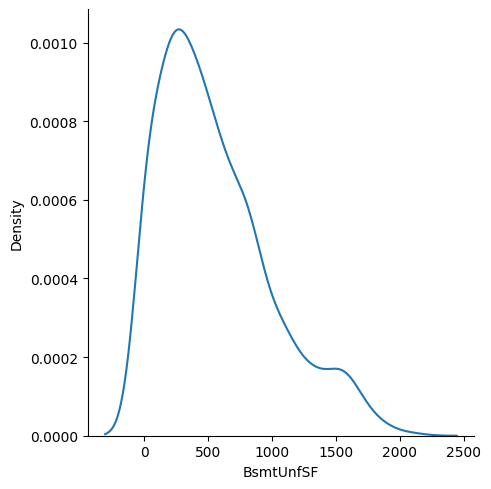

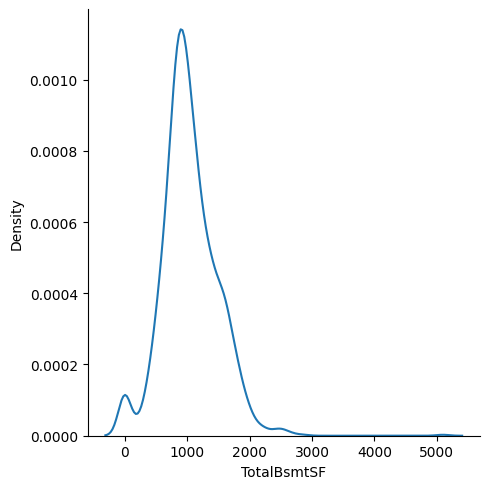

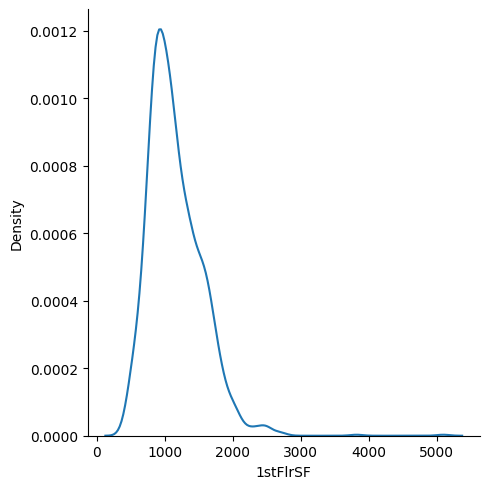

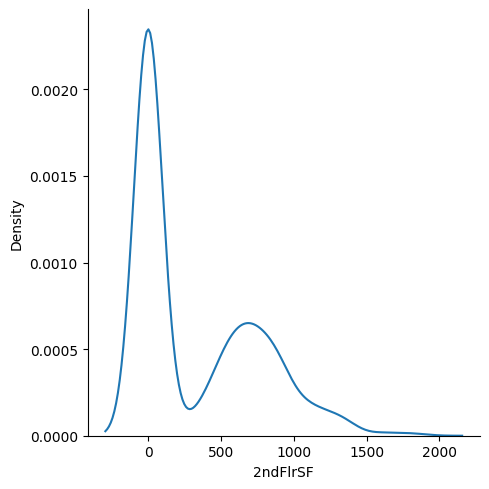

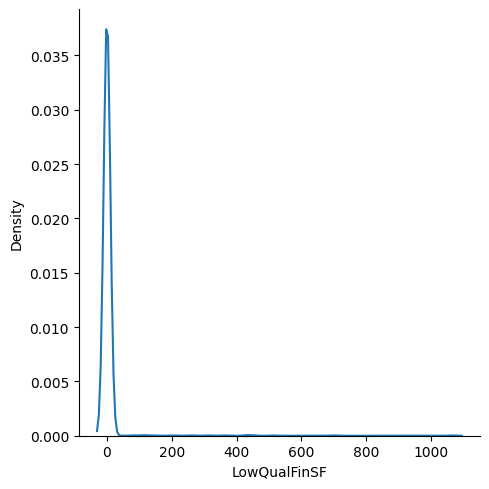

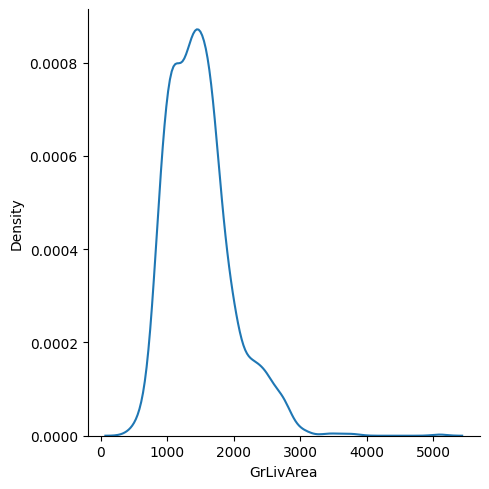

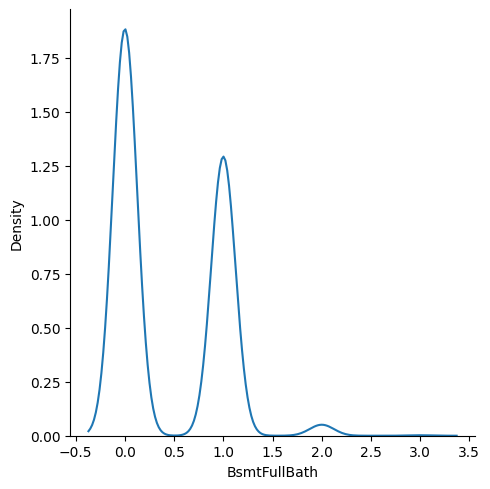

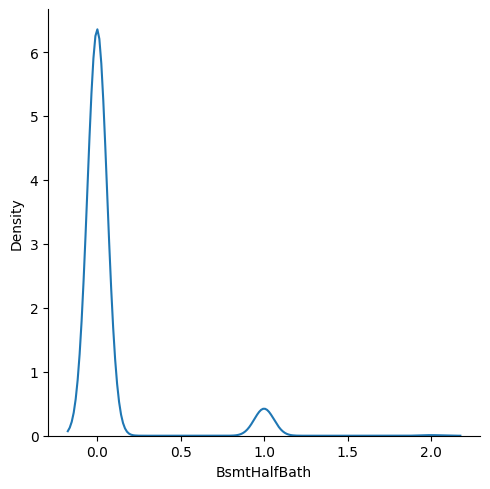

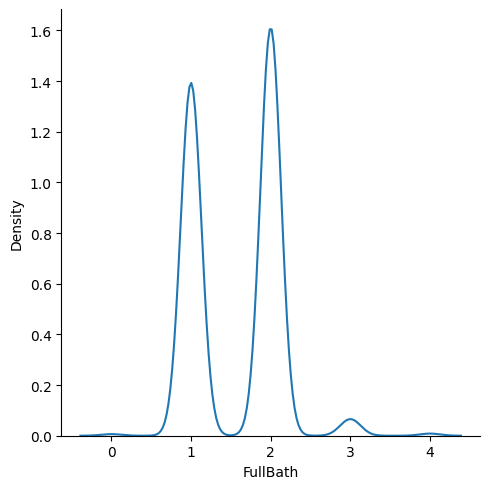

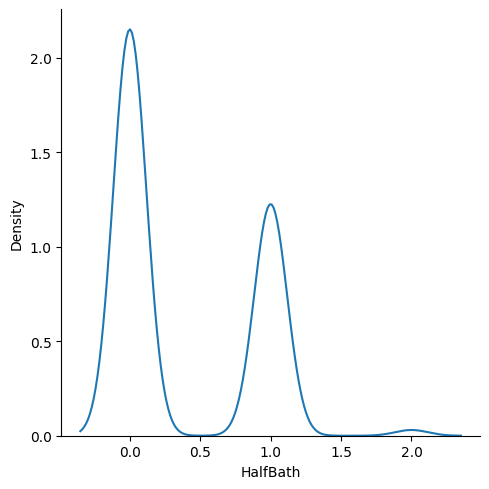

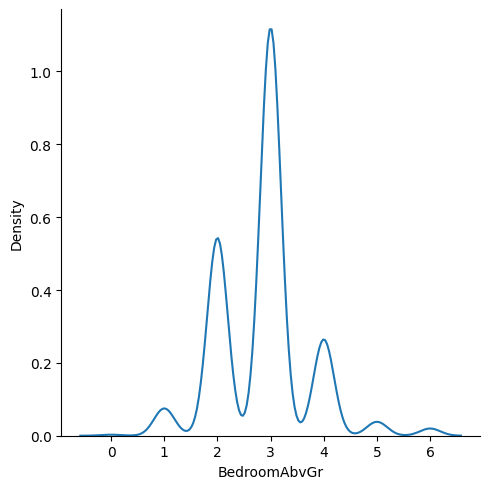

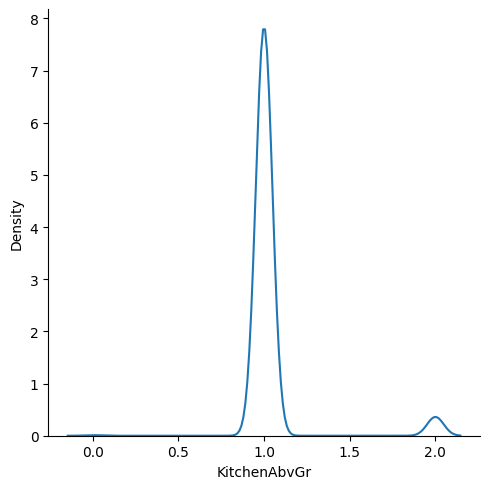

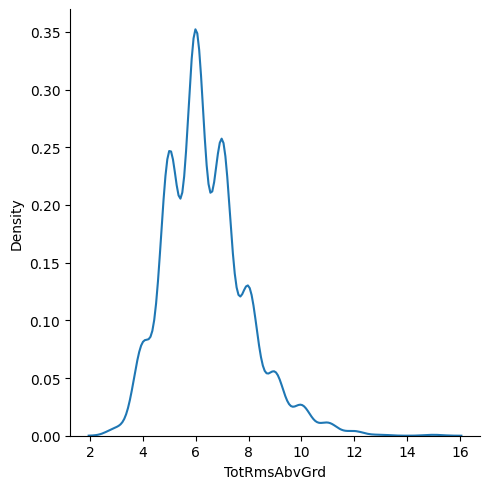

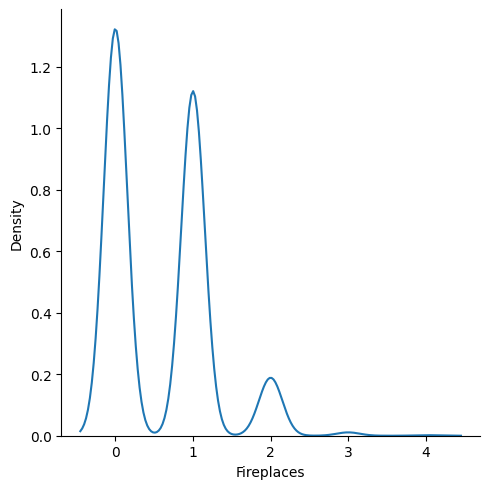

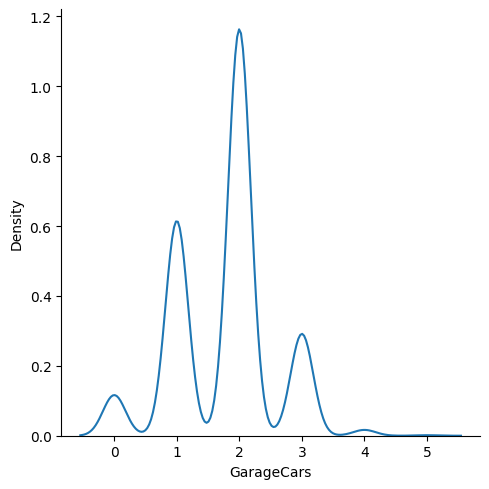

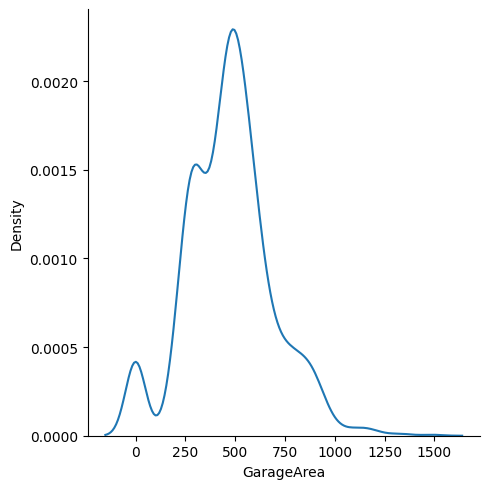

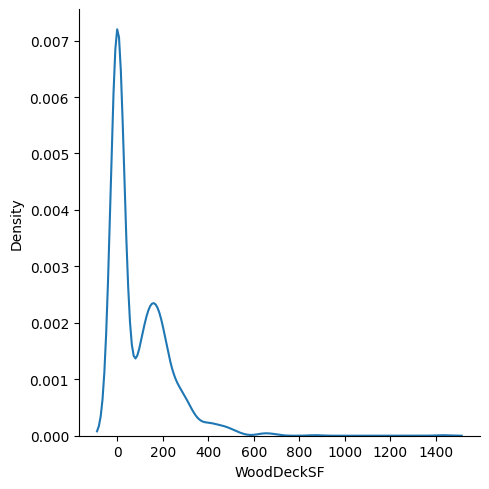

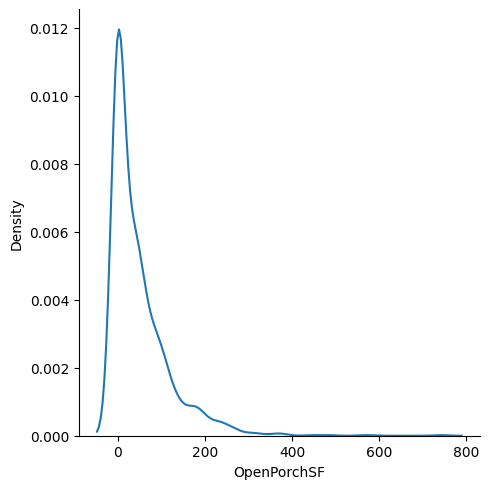

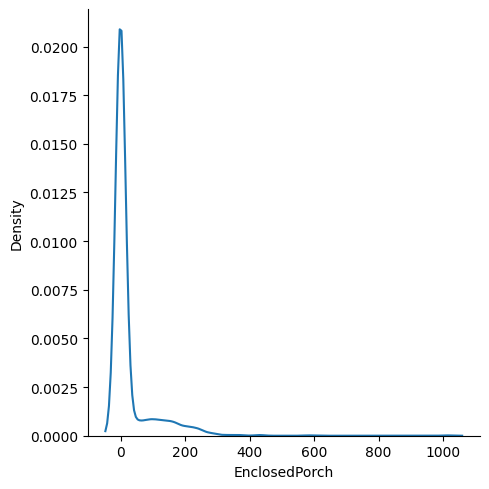

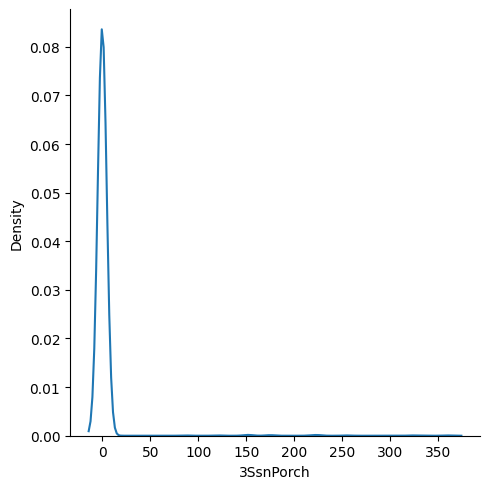

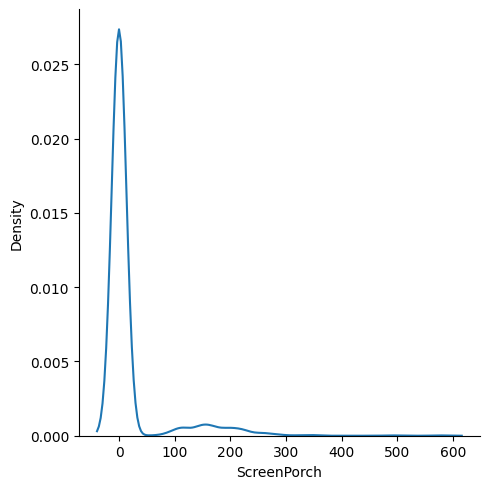

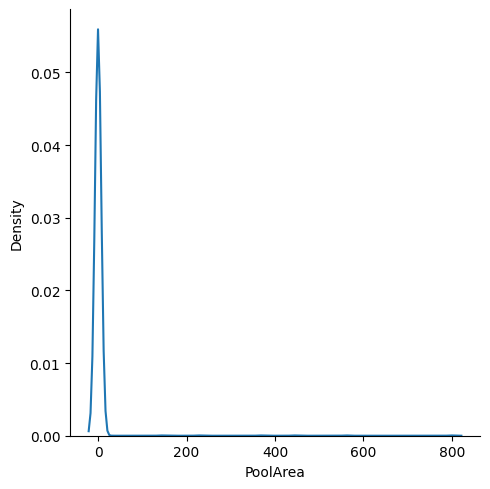

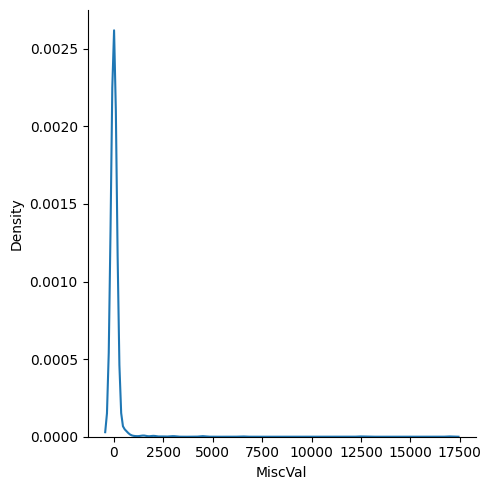

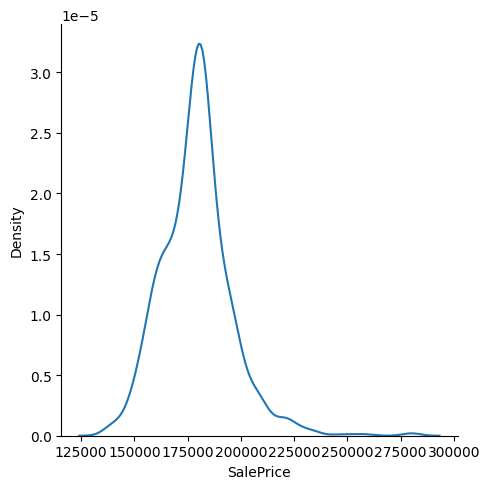

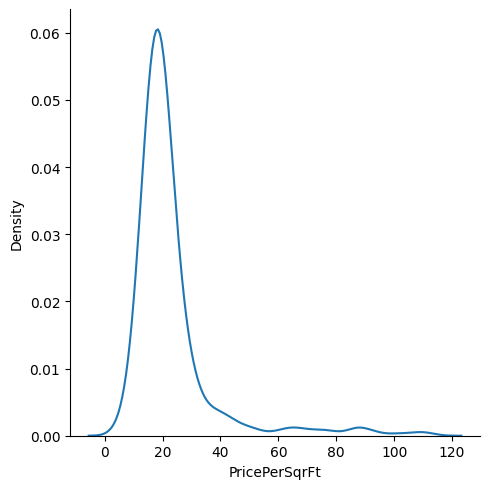

In [28]:
number_col_names = get_data_type(test_data_csv,PDataType.NUMERICAL)
for c in number_col_names:
    print(c)
    sns.displot(test_data_csv[c], kind = 'kde') # I have no idea what it means..


## DRAW correlation Matrix for PricePerSqrFt

SalePrice        1.000000
BedroomAbvGr     0.786022
LotArea          0.715795
TotRmsAbvGrd     0.625592
GrLivArea        0.566654
1stFlrSF         0.339335
2ndFlrSF         0.330785
FullBath         0.326312
GarageArea       0.250677
GarageCars       0.233109
HalfBath         0.223001
Fireplaces       0.213041
TotalBsmtSF      0.210655
LotFrontage      0.186717
BsmtUnfSF        0.180606
KitchenAbvGr     0.177035
OpenPorchSF      0.151314
MasVnrArea       0.148557
WoodDeckSF       0.109188
EnclosedPorch    0.094659
OverallQual      0.093643
MiscVal          0.081200
PoolArea         0.071271
ScreenPorch      0.041524
BsmtFinSF1       0.030766
LowQualFinSF     0.020544
BsmtFinSF2       0.002547
BsmtHalfBath    -0.007887
BsmtFullBath    -0.052707
3SsnPorch       -0.055704
OverallCond     -0.083753
MSSubClass      -0.205917
PricePerSqrFt   -0.438782
Name: SalePrice, dtype: float64


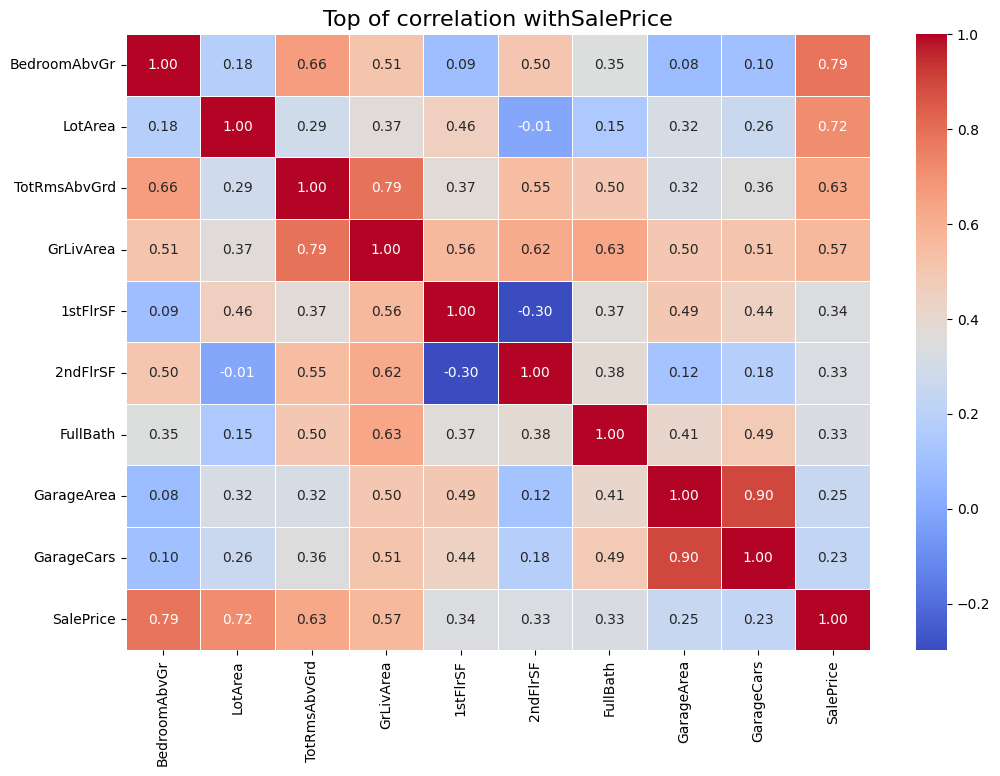

PricePerSqrFt    1.000000
MSSubClass       0.598185
2ndFlrSF         0.088818
HalfBath         0.083605
OverallCond      0.021271
BsmtHalfBath     0.015315
LowQualFinSF     0.002972
3SsnPorch        0.002130
KitchenAbvGr    -0.006337
MasVnrArea      -0.044673
PoolArea        -0.045316
MiscVal         -0.050155
BsmtFinSF2      -0.067814
ScreenPorch     -0.075507
EnclosedPorch   -0.081415
BsmtUnfSF       -0.098743
BsmtFullBath    -0.100586
OverallQual     -0.107167
FullBath        -0.110255
OpenPorchSF     -0.110518
WoodDeckSF      -0.111113
BedroomAbvGr    -0.113944
BsmtFinSF1      -0.136742
Fireplaces      -0.185254
GrLivArea       -0.226070
TotRmsAbvGrd    -0.226735
GarageCars      -0.232624
TotalBsmtSF     -0.264704
GarageArea      -0.269104
LotFrontage     -0.311846
1stFlrSF        -0.369847
SalePrice       -0.438782
LotArea         -0.628345
Name: PricePerSqrFt, dtype: float64


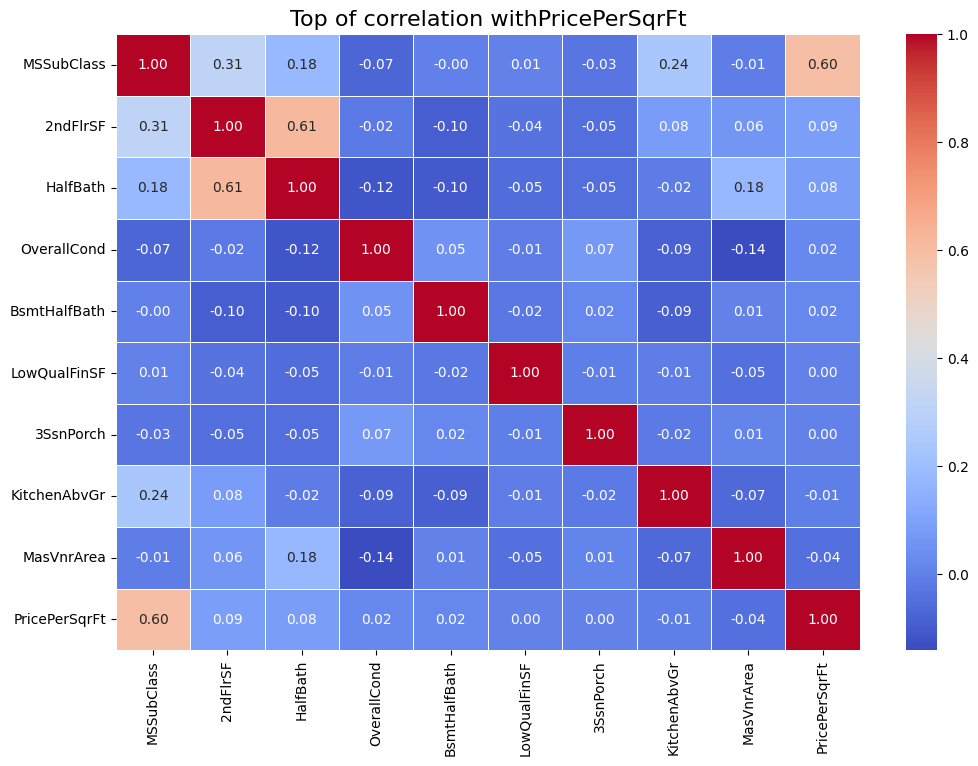

In [39]:
plot_correlation_for(test_data_csv,'SalePrice')
plot_correlation_for(test_data_csv,'PricePerSqrFt')

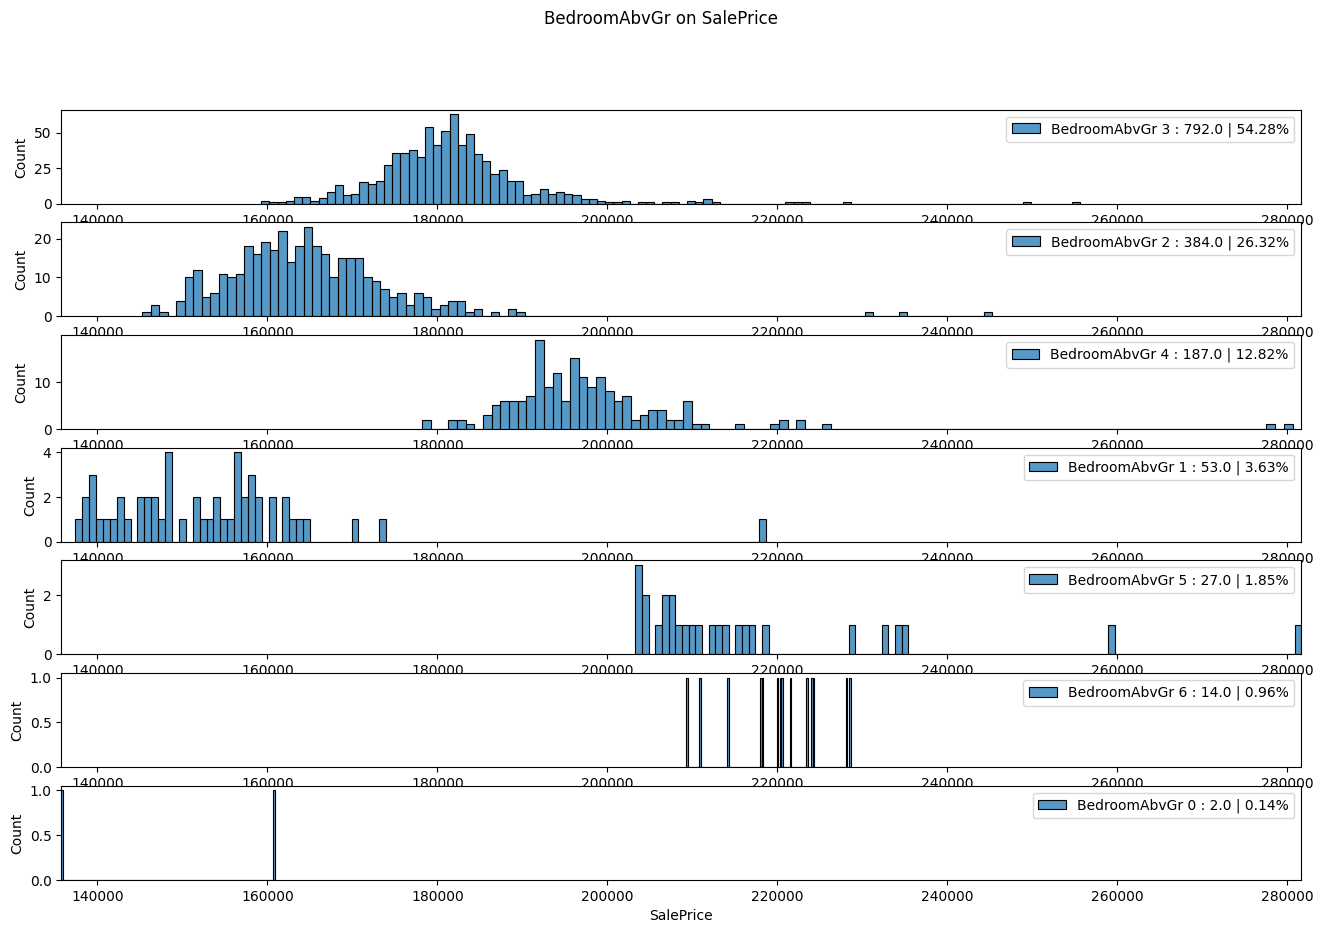

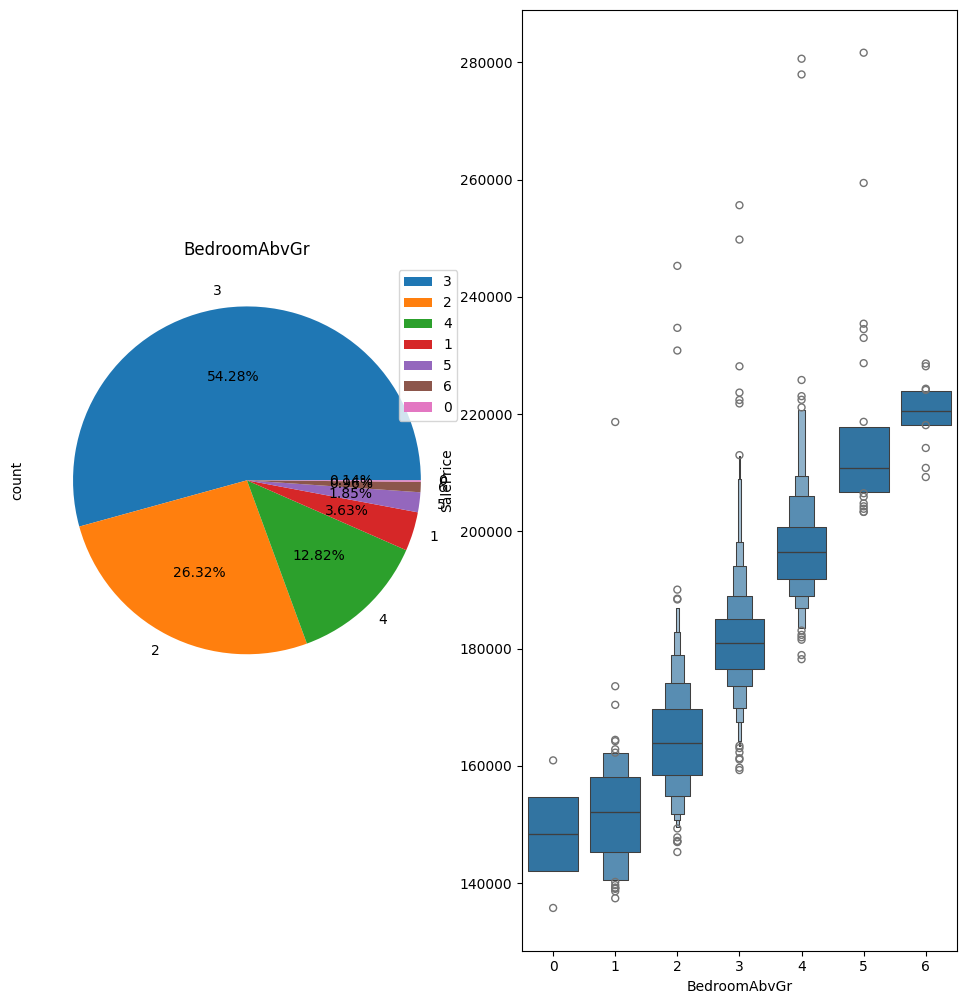

In [37]:
plot_unique_category(test_data_csv,'BedroomAbvGr','SalePrice');


## Generate OneHotEncoders

In [ ]:
import sys;
np.set_printoptions(threshold=sys.maxsize)
test_data_csv2 = pd.get_dummies(test_data_csv)
for c in test_data_csv2.columns:
    print(c)
print(len(test_data_csv2.columns))
print(len(test_data_csv.columns))

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.preprocessing import OneHotEncoder